## ICR - Identifying Age-Related Conditions
#### https://www.kaggle.com/competitions/icr-identify-age-related-conditions/code?competitionId=52784&sortBy=scoreAscending

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.express as px
import plotly.graph_objects as go
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold as KF, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, make_scorer, log_loss, balanced_accuracy_score
import seaborn as sns

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")
greeks = pd.read_csv('greeks.csv')

In [3]:
train

Id        AB          AF          AH          AM         AR  \
0    000ff2bfdfe9  0.209377  3109.03329   85.200147   22.394407   8.138688   
1    007255e47698  0.145282   978.76416   85.200147   36.968889   8.138688   
2    013f2bd269f5  0.470030  2635.10654   85.200147   32.360553   8.138688   
3    043ac50845d5  0.252107  3819.65177  120.201618   77.112203   8.138688   
4    044fb8a146ec  0.380297  3733.04844   85.200147   14.103738   8.138688   
..            ...       ...         ...         ...         ...        ...   
612  fd3dafe738fd  0.149555  3130.05946  123.763599    9.513984  13.020852   
613  fd895603f071  0.435846  5462.03438   85.200147   46.551007  15.973224   
614  fd8ef6377f76  0.427300  2459.10720  130.138587   55.355778  10.005552   
615  fe1942975e40  0.363205  1263.53524   85.200147   23.685856   8.138688   
616  ffcca4ded3bb  0.482849  2672.53426  546.663930  112.006102   8.138688   

           AX        AY         AZ          BC  ...         FL        FR  \
0    0.699861  0.025578   9.812214    5.555634  ...   7.298162   1.73855   
1    3.632190  0.025578  13.517790    1.229900  ...   0.173229   0.49706   
2    6.732840  0.025578  12.824570    1.229900  ...   7.709560   0.97556   
3    3.685344  0.025578  11.053708    1.229900  ...   6.122162   0.49706   
4    3.942255  0.054810   3.396778  102.151980  ...   8.153058  48.50134   
..        ...       ...        ...         ...  ...        ...       ...   
612  3.499305  0.077343   8.545512    2.804172  ...   0.173229   1.26092   
613  5.979825  0.025882  12.622906    3.777550  ...  10.223150   1.24236   
614  8.070549  0.025578  15.408390    1.229900  ...   0.173229   0.49706   
615  7.981959  0.025578   7.524588    1.229900  ...   9.256996   0.78764   
616  3.198099  0.116928   3.396778    7.948668  ...   0.173229   1.14492   

           FS         GB          GE            GF         GH          GI  \
0    0.094822  11.339138   72.611063   2003.810319  22.136229   69.834944   
1    0.568932   9.292698   72.611063  27981.562750  29.135430   32.131996   
2    1.198821  37.077772   88.609437  13676.957810  28.022851   35.192676   
3    0.284466  18.529584   82.416803   2094.262452  39.948656   90.493248   
4    0.121914  16.408728  146.109943   8524.370502  45.381316   36.262628   
..        ...        ...         ...           ...        ...         ...   
612  0.067730   8.967128  217.148554   8095.932828  24.640462   69.191944   
613  0.426699  35.896418  496.994214   3085.308063  29.648928  124.808872   
614  0.067730  19.962092  128.896894   6474.652866  26.166072  119.559420   
615  0.670527  24.594488   72.611063   1965.343176  25.116750   37.155112   
616  0.149006  13.673940   72.611063   6850.484442  45.745974  114.842372   

            GL  Class  
0     0.120343      1  
1    21.978000      0  
2     0.196941      0  
3     0.155829      0  
4     0.096614      1  
..         ...    ...  
612  21.978000      0  
613   0.145340      0  
614  21.978000      0  
615   0.184622      0  
616  21.978000      0  

[617 rows x 58 columns]

In [4]:
test

Id   AB   AF   AH   AM   AR   AX   AY   AZ   BC  ...   FI   FL  \
0  00eed32682bb  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1  010ebe33f668  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2  02fa521e1838  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3  040e15f562a2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4  046e85c7cc7f  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

    FR   FS   GB   GE   GF   GH   GI   GL  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 57 columns]

In [5]:
greeks

Id Alpha Beta Gamma Delta    Epsilon
0    000ff2bfdfe9     B    C     G     D  3/19/2019
1    007255e47698     A    C     M     B    Unknown
2    013f2bd269f5     A    C     M     B    Unknown
3    043ac50845d5     A    C     M     B    Unknown
4    044fb8a146ec     D    B     F     B  3/25/2020
..            ...   ...  ...   ...   ...        ...
612  fd3dafe738fd     A    B     M     B  9/13/2020
613  fd895603f071     A    B     M     B   9/8/2020
614  fd8ef6377f76     A    C     M     B  7/24/2019
615  fe1942975e40     A    C     M     B  1/31/2019
616  ffcca4ded3bb     A    C     M     B    Unknown

[617 rows x 6 columns]

In [6]:
colors = ['#00539C', '#EEA47F']
# Plotting pie chart
fig = px.pie(train, names='Class', 
             height=400, width=600, 
             hole=0.6, 
             title='Target Class Distribution',
             color_discrete_sequence=colors)
fig.update_traces(hovertemplate=None, textposition='outside', textinfo='percent', rotation=0)
fig.update_layout(margin=dict(t=100, b=30, l=0, r=0), showlegend=True,
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=20, color='#555', family="Lato, sans-serif"),
                  font=dict(size=17, color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))
fig.show()

In [7]:
train.dtypes

Id        object
AB       float64
AF       float64
AH       float64
AM       float64
AR       float64
AX       float64
AY       float64
AZ       float64
BC       float64
BD       float64
BN       float64
BP       float64
BQ       float64
BR       float64
BZ       float64
CB       float64
CC       float64
CD       float64
CF       float64
CH       float64
CL       float64
CR       float64
CS       float64
CU       float64
CW       float64
DA       float64
DE       float64
DF       float64
DH       float64
DI       float64
DL       float64
DN       float64
DU       float64
DV       float64
DY       float64
EB       float64
EE       float64
EG       float64
EH       float64
EJ        object
EL       float64
EP       float64
EU       float64
FC       float64
FD       float64
FE       float64
FI       float64
FL       float64
FR       float64
FS       float64
GB       float64
GE       float64
GF       float64
GH       float64
GI       float64
GL       float64
Class      int64
dtype: object

In [8]:
train.EJ

0      B
1      A
2      B
3      B
4      B
      ..
612    A
613    B
614    A
615    B
616    A
Name: EJ, Length: 617, dtype: object

In [9]:
encoding = {'A': 0, 'B': 1}
train.EJ = train.EJ.map(encoding)
test.EJ = test.EJ.map(encoding)

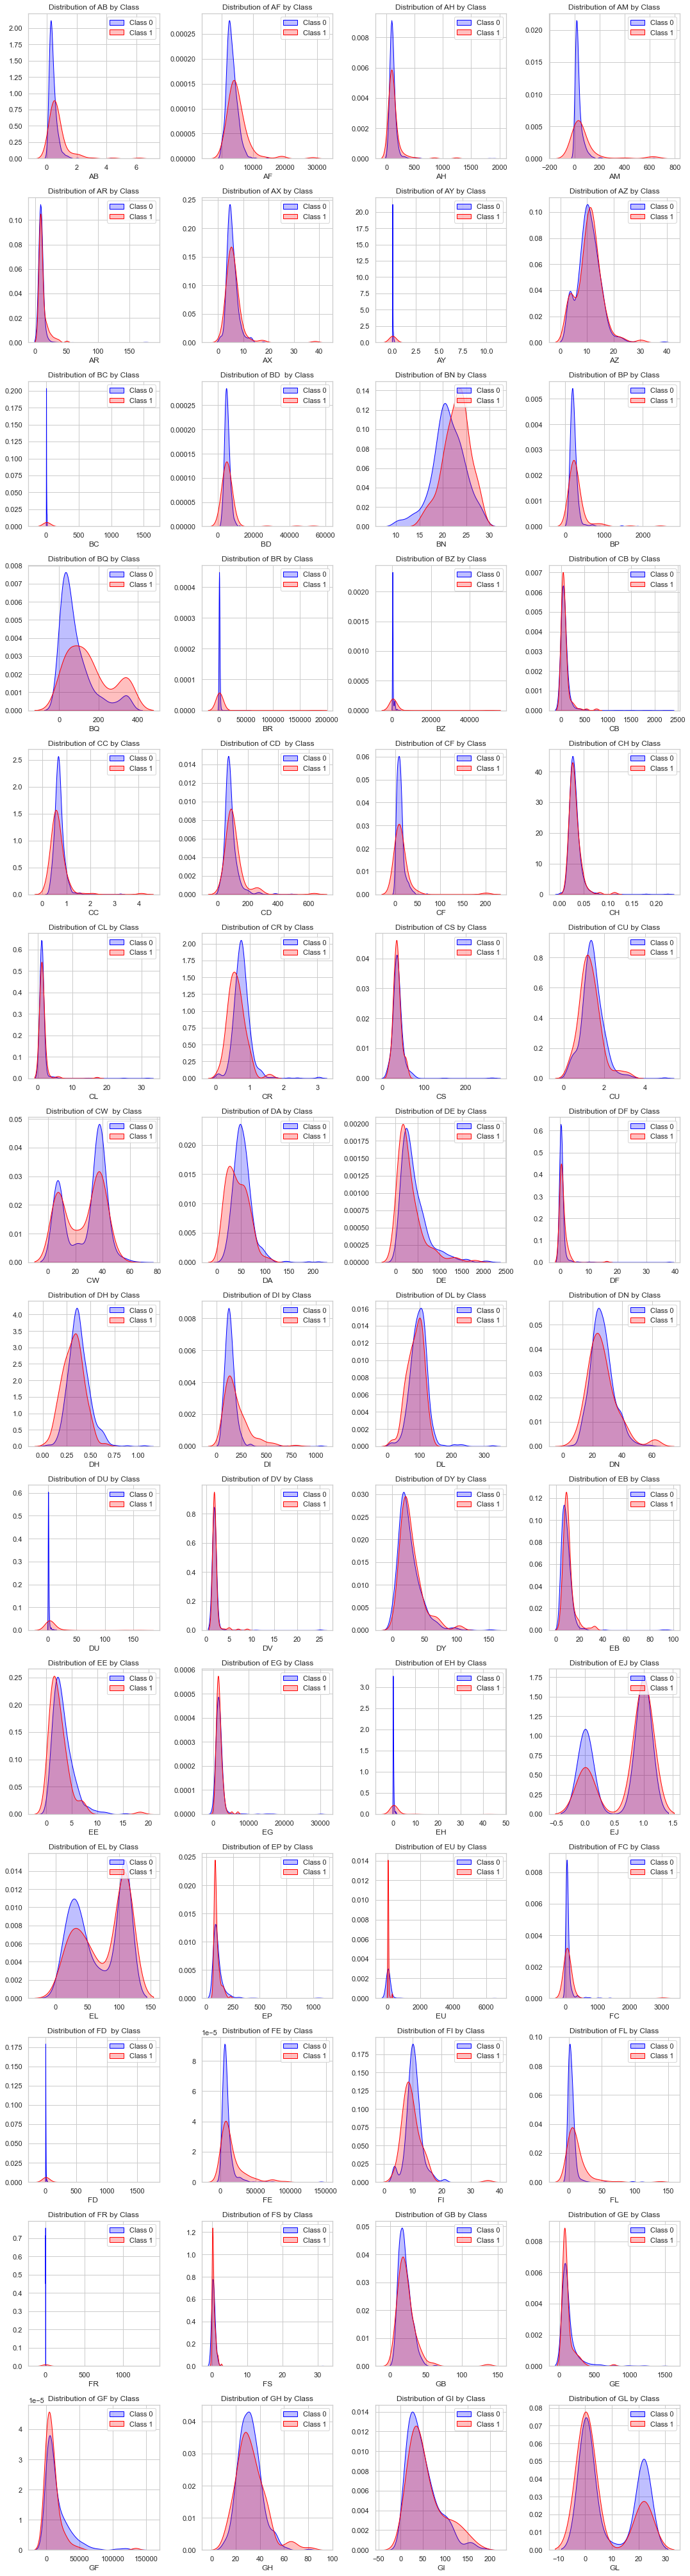

In [10]:
# Create a new DataFrame excluding 'Id' column
train_new = train.drop(columns=['Id'])

# Set the theme for seaborn
sns.set_theme(style='whitegrid')

features = train_new.columns.drop('Class')
num_plots = len(features)
num_cols = 4
num_rows = math.ceil(num_plots / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows))

for ind, feature in enumerate(features):
    i = ind // num_cols
    j = ind % num_cols
    
    # Create two separate data sets for each Class value
    data_0 = train_new[train_new['Class'] == 0][feature]
    data_1 = train_new[train_new['Class'] == 1][feature]
    
    sns.kdeplot(data=data_0, color='blue', ax=axs[i, j], fill=True, label='Class 0')
    sns.kdeplot(data=data_1, color='red', ax=axs[i, j], fill=True, label='Class 1')

    axs[i, j].set_title(f'Distribution of {feature} by Class')
    axs[i, j].set_ylabel('')  # removes the Density label
    axs[i, j].legend()

# Remove any unused subplots
for ind in range(num_plots, num_rows*num_cols):
    i = ind // num_cols
    j = ind % num_cols
    fig.delaxes(axs[i, j])

plt.tight_layout()
plt.show()

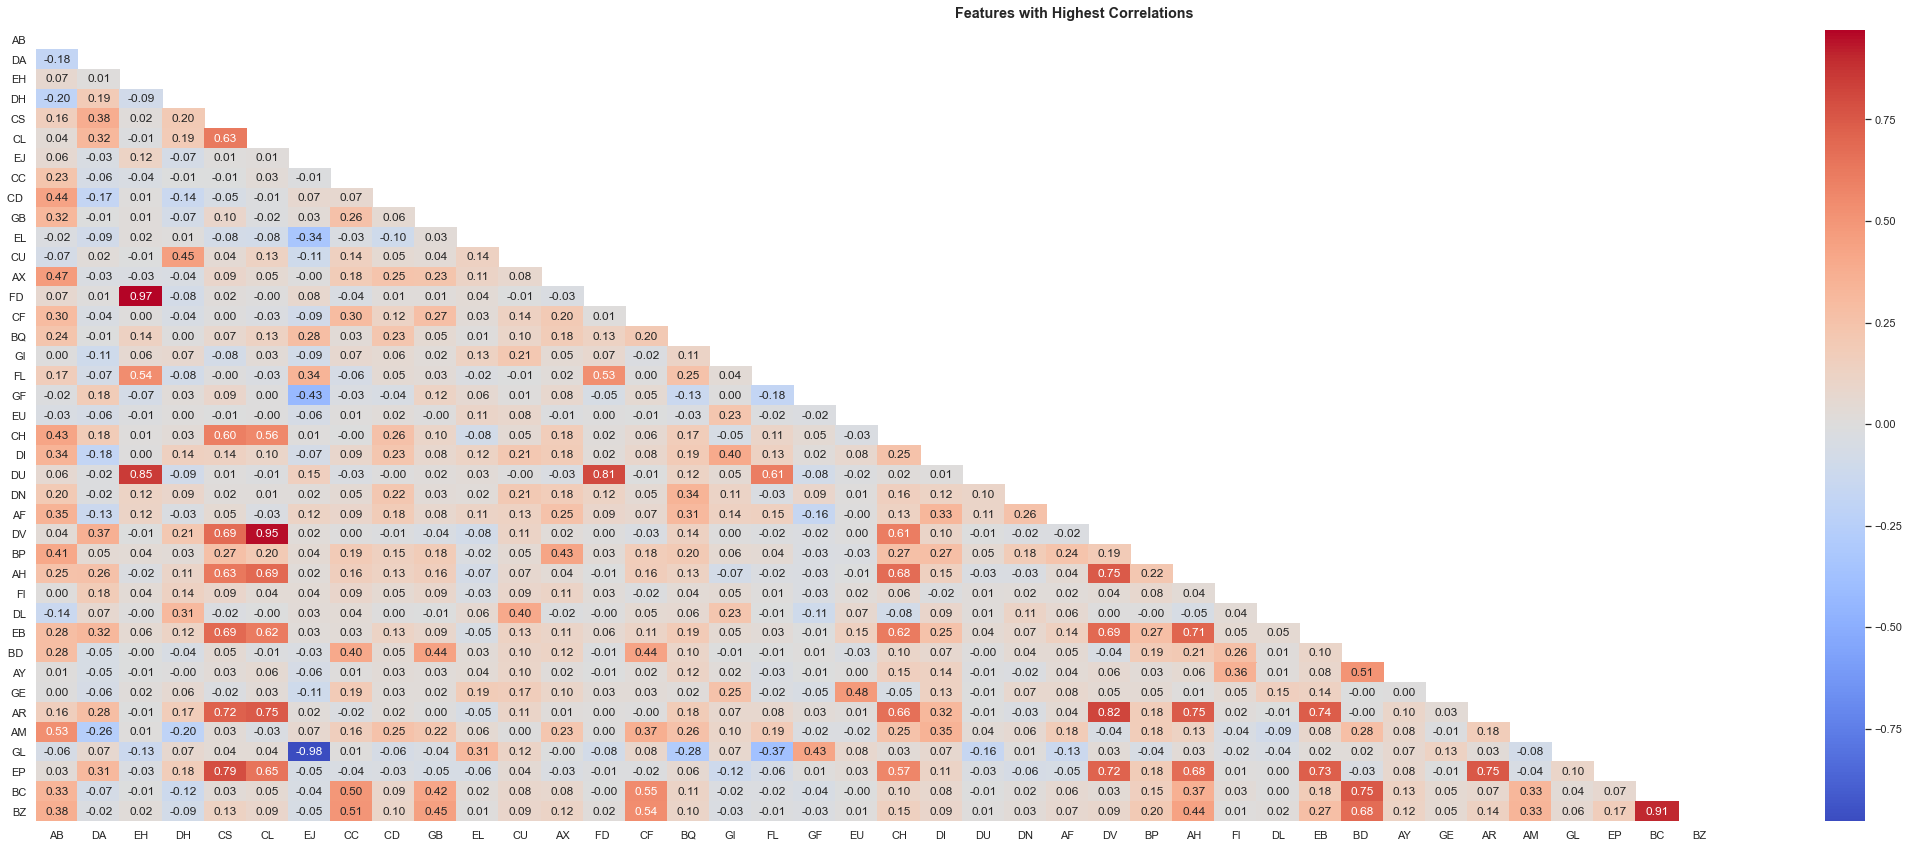

In [11]:
num_cols = train.columns.tolist()[1:-1]
correlations = train.loc[:,num_cols].corr().abs().unstack().sort_values(kind="quicksort",ascending=False).reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']] #preventing 1.0 corr
corr_max=correlations.level_0.head(150).tolist()
corr_max=list(set(corr_max)) #removing duplicates

corr_min=correlations.level_0.tail(34).tolist()
corr_min=list(set(corr_min)) #removing duplicates


correlation_train = train.loc[:,corr_max].corr()
mask = np.triu(correlation_train.corr())

plt.figure(figsize=(30, 12))
sns.heatmap(correlation_train,
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            linewidths=0.00,
            cbar=True)


plt.suptitle('Features with Highest Correlations',  weight='bold')
plt.tight_layout()

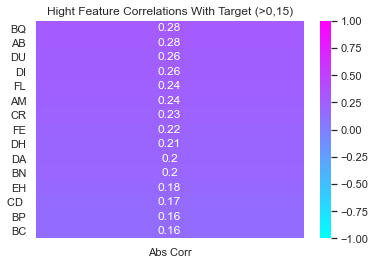

In [12]:
correlations = train.loc[:,num_cols].corrwith(train['Class']).to_frame()
correlations['Abs Corr'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('Abs Corr', ascending=False)['Abs Corr']
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(sorted_correlations.iloc[1:].to_frame()[sorted_correlations>=.15], cmap='cool', annot=True, vmin=-1, vmax=1, ax=ax)
plt.title('Hight Feature Correlations With Target (>0,15)')
plt.show()

In [13]:
nan_features_train = train.columns[train.isnull().sum() > 0]
nan_features_test = test.columns[test.isnull().sum() > 0]

nan_count_train = train[nan_features_train].isnull().sum()
nan_count_test = test[nan_features_test].isnull().sum()

print("Train features with NaN values:")
print(nan_features_train)
print("Number of NaN values in Train dataset:")
print(nan_count_train)

print("\nTest features with NaN values:")
print(nan_features_test)
print("Number of NaN values in Test dataset:")
print(nan_count_test)

Train features with NaN values:
Index(['BQ', 'CB', 'CC', 'DU', 'EL', 'FC', 'FL', 'FS', 'GL'], dtype='object')
Number of NaN values in Train dataset:
BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64

Test features with NaN values:
Index([], dtype='object')
Number of NaN values in Test dataset:
Series([], dtype: float64)


In [14]:
train_predict = train.drop(columns=['Id'])

In [15]:
def predict_missing_values(train):
    # Identify features with missing values
    missing_columns = train.columns[train.isnull().any()]

    for column in missing_columns:
        # Split data into features and target
        train_filled = train.dropna(subset=[column])
        X_train = train_filled.drop(columns=column)
        y_train = train_filled[column]

        # Create and fit a SimpleImputer to impute missing values
        imputer = SimpleImputer()
        X_train_imputed = imputer.fit_transform(X_train)

        # Create and train Random Forest regressor
        rf = RandomForestRegressor()
        rf.fit(X_train_imputed, y_train)

        # Impute missing values in the train dataset
        X_missing = train[train[column].isnull()].drop(columns=column)
        X_missing_imputed = imputer.transform(X_missing)
        predicted_values = rf.predict(X_missing_imputed)

        # Replace missing values with predicted values
        train.loc[train[column].isnull(), column] = predicted_values

    return train

In [16]:
train_predict  = predict_missing_values(train_predict)

In [17]:
train = pd.concat([train['Id'], train_predict], axis=1)

In [18]:
nan_features_train = train.columns[train.isnull().sum() > 0]

nan_count_train = train[nan_features_train].isnull().sum()

print("Train features with NaN values:")
print(nan_features_train)
print("Number of NaN values in Train dataset:")
print(nan_count_train)

Train features with NaN values:
Index([], dtype='object')
Number of NaN values in Train dataset:
Series([], dtype: float64)


In [19]:
train['Class'].value_counts()

0    509
1    108
Name: Class, dtype: int64

#### Prepare the Data

In [20]:
X = train.drop(columns=['Id','Class'])
y = train['Class']
test_y = test.drop(columns=['Id'])

In [21]:
preprocessor = StandardScaler()

#### Modeling

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
def hyperparameter_search(classifier_type, X_train, y_train):   
    
    scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
    # Define classifier and parameters based on the type
    if classifier_type == 'lgbm':
        classifier = LGBMClassifier(random_state=42)
        params = {
            'classifier__boosting_type': ['gbdt', 'dart', 'goss'],
            'classifier__num_leaves': [10, 20, 30, 40],
            'classifier__learning_rate': [0.1, 0.05, 0.01, 0.001],
            'classifier__n_estimators': [100, 200, 300, 400],
            'classifier__subsample': [0.8, 0.9, 1.0],
            'classifier__colsample_bytree': [0.8, 0.9, 1.0],
            'classifier__reg_alpha': [0.0, 0.1, 0.5],
            'classifier__reg_lambda': [0.0, 0.1, 0.5],
        }

    elif classifier_type == 'rf':
        classifier = RandomForestClassifier(random_state=42)
        params = {
            'classifier__n_estimators': [100, 200, 300, 400],
            'classifier__max_depth': [None, 5, 10, 15],
            'classifier__min_samples_split': [2, 5, 10, 20],
            'classifier__min_samples_leaf': [1, 2, 4, 8],
            'classifier__max_features': ['auto', 'sqrt'],
        }

    elif classifier_type == 'catboost':
        classifier = CatBoostClassifier(random_state=42)
        params = {
            'classifier__iterations': [100, 300],
            'classifier__learning_rate': [0.1, 0.01],
            'classifier__depth': [4, 8],
            'classifier__l2_leaf_reg': [1, 5],
            'classifier__colsample_bylevel': [0.8, 1.0],
        }

    elif classifier_type == 'xgboost':
        classifier = XGBClassifier(random_state=42)
        params = {
            'classifier__max_depth': [3, 5, 7, 9],
            'classifier__learning_rate': [0.1, 0.05, 0.01, 0.001],
            'classifier__n_estimators': [100, 200, 300, 400],
            'classifier__gamma': [0, 0.1, 0.2, 0.3],
            'classifier__subsample': [0.8, 0.9, 1.0],
            'classifier__colsample_bytree': [0.8, 0.9, 1.0],
            'classifier__reg_alpha': [0.0, 0.1, 0.5],
            'classifier__reg_lambda': [0.0, 0.1, 0.5],
        }

    elif classifier_type == 'extra_tree':
        classifier = ExtraTreesClassifier(random_state=42)
        params = {
            'classifier__n_estimators': [100, 200, 300, 400],
            'classifier__max_depth': [None, 5, 10, 15],
            'classifier__min_samples_split': [2, 5, 10, 20],
            'classifier__min_samples_leaf': [1, 2, 4, 8],
            'classifier__max_features': ['auto', 'sqrt'],
        }

    elif classifier_type == 'lrl1':
        classifier = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
        params = {
            'classifier__C': [0.1, 1, 10],
            'classifier__solver': ['liblinear'],
            'classifier__penalty': ['l1'],
            'classifier__fit_intercept': [True, False],
            'classifier__intercept_scaling': [1, 2],
        }

    else:
        return "Invalid classifier type"

    # Create pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', classifier)])
    start_time = time.time()

    # Perform randomized search
    random_search = RandomizedSearchCV(pipeline, params, n_iter=100, cv=5, scoring=scorer, verbose=0, n_jobs=-1, random_state=42)

    random_search.fit(X_train, y_train)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)
    
    # Print best parameters
    print(f"Best parameters for {classifier_type}: {random_search.best_params_}")
    print("Time taken for Randomized Search: %d minutes %d seconds" % (minutes, seconds))
    print("-----------------------------------------------------------------------")
    print("")
    return random_search.best_estimator_    

In [24]:
# Apply function and store best estimators
classifiers = ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'lrl1']
best_estimators = {}

for classifier in classifiers:
    best_estimator = hyperparameter_search(classifier, X_train, y_train)
    best_estimators[classifier] = best_estimator


Best parameters for lgbm: {'classifier__subsample': 0.9, 'classifier__reg_lambda': 0.5, 'classifier__reg_alpha': 0.0, 'classifier__num_leaves': 20, 'classifier__n_estimators': 400, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.9, 'classifier__boosting_type': 'dart'}
Time taken for Randomized Search: 0 minutes 7 seconds
-----------------------------------------------------------------------

Best parameters for rf: {'classifier__n_estimators': 400, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 10}
Time taken for Randomized Search: 0 minutes 20 seconds
-----------------------------------------------------------------------

0:	learn: 0.6205714	total: 56.5ms	remaining: 5.59s
1:	learn: 0.5628485	total: 58.8ms	remaining: 2.88s
2:	learn: 0.5014651	total: 61ms	remaining: 1.97s
3:	learn: 0.4460055	total: 63.2ms	remaining: 1.52s
4:	learn: 0.3993308	total: 65.2ms	remaining: 1.24s
5:	learn:

In [48]:
# Initialize variables
balanced_logloss_scores = []

# Iterate over classifiers
for classifier, best_estimator in best_estimators.items():
    # Fit the model on the training data
    best_estimator.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred_proba = best_estimator.predict_proba(X_valid)
    y_pred = y_pred_proba.argmax(axis=1)

    # Calculate balanced log loss
    balanced_logloss = log_loss(y_valid, y_pred_proba) / balanced_accuracy_score(y_valid, y_pred)
    balanced_logloss_scores.append(balanced_logloss)

    # Print balanced log loss for the classifier
    print(f"Balanced Log Loss for {classifier}: {balanced_logloss}")



Balanced Log Loss for lgbm: 0.15034772051597353
Balanced Log Loss for rf: 0.2848016745188866
0:	learn: 0.6205714	total: 1.73ms	remaining: 171ms
1:	learn: 0.5628485	total: 3.33ms	remaining: 163ms
2:	learn: 0.5014651	total: 4.7ms	remaining: 152ms
3:	learn: 0.4460055	total: 6.52ms	remaining: 156ms
4:	learn: 0.3993308	total: 7.8ms	remaining: 148ms
5:	learn: 0.3633532	total: 9.35ms	remaining: 147ms
6:	learn: 0.3335857	total: 10.9ms	remaining: 144ms
7:	learn: 0.3091231	total: 12.6ms	remaining: 145ms
8:	learn: 0.2910905	total: 13.9ms	remaining: 140ms
9:	learn: 0.2793605	total: 15.7ms	remaining: 141ms
10:	learn: 0.2647928	total: 17.1ms	remaining: 139ms
11:	learn: 0.2520744	total: 18.8ms	remaining: 138ms
12:	learn: 0.2442911	total: 20.3ms	remaining: 136ms
13:	learn: 0.2387279	total: 22.3ms	remaining: 137ms
14:	learn: 0.2283477	total: 23.8ms	remaining: 135ms
15:	learn: 0.2179776	total: 25.4ms	remaining: 134ms
16:	learn: 0.2081508	total: 27.2ms	remaining: 133ms
17:	learn: 0.2029105	total: 29.1ms	

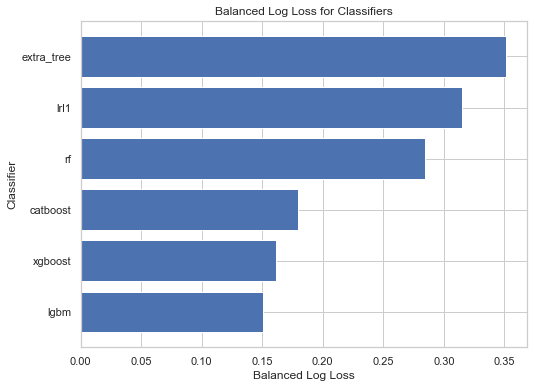

In [49]:
# Sort the balanced log loss scores and corresponding classifiers
sorted_scores = sorted(zip(balanced_logloss_scores, best_estimators.keys()))
sorted_scores, sorted_classifiers = zip(*sorted_scores)

# Plot the balanced log loss results
plt.figure(figsize=(8, 6))
plt.barh(sorted_classifiers, sorted_scores)  # Use barh for horizontal bar plot
plt.xlabel('Balanced Log Loss')
plt.ylabel('Classifier')
plt.title('Balanced Log Loss for Classifiers')
plt.show()

In [50]:
from sklearn.ensemble import VotingClassifier

# Create the ensemble model with voting='hard'
voting_model = VotingClassifier([
    ('xgb', best_estimators['xgboost']),
    ('lgbm', best_estimators['lgbm']),
    ('cat', best_estimators['catboost'])
], voting='soft')

# Fit the ensemble model on the training data
voting_model.fit(X_train, y_train)


0:	learn: 0.6205714	total: 1.48ms	remaining: 147ms
1:	learn: 0.5628485	total: 3.55ms	remaining: 174ms
2:	learn: 0.5014651	total: 4.95ms	remaining: 160ms
3:	learn: 0.4460055	total: 6.86ms	remaining: 165ms
4:	learn: 0.3993308	total: 8.5ms	remaining: 161ms
5:	learn: 0.3633532	total: 10.3ms	remaining: 162ms
6:	learn: 0.3335857	total: 11.6ms	remaining: 154ms
7:	learn: 0.3091231	total: 13.7ms	remaining: 158ms
8:	learn: 0.2910905	total: 15ms	remaining: 152ms
9:	learn: 0.2793605	total: 16.8ms	remaining: 151ms
10:	learn: 0.2647928	total: 18.3ms	remaining: 148ms
11:	learn: 0.2520744	total: 20.6ms	remaining: 151ms
12:	learn: 0.2442911	total: 22ms	remaining: 147ms
13:	learn: 0.2387279	total: 24.1ms	remaining: 148ms
14:	learn: 0.2283477	total: 25.6ms	remaining: 145ms
15:	learn: 0.2179776	total: 27.3ms	remaining: 144ms
16:	learn: 0.2081508	total: 28.8ms	remaining: 141ms
17:	learn: 0.2029105	total: 30.9ms	remaining: 141ms
18:	learn: 0.1962386	total: 32.2ms	remaining: 137ms
19:	learn: 0.1902409	total:

VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('preprocessor',
                                               StandardScaler()),
                                              ('classifier',
                                               XGBClassifier(base_score=0.5,
                                                             booster='gbtree',
                                                             callbacks=None,
                                                             colsample_bylevel=1,
                                                             colsample_bynode=1,
                                                             colsample_bytree=0.9,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=0.2,
                                                             gpu_id=-1,
                                                             grow_policy='depthwis...
                              Pipeline(steps=[('preprocessor',
                                               StandardScaler()),
                                              ('classifier',
                                               LGBMClassifier(boosting_type='dart',
                                                              colsample_bytree=0.9,
                                                              n_estimators=400,
                                                              num_leaves=20,
                                                              random_state=42,
                                                              reg_lambda=0.5,
                                                              subsample=0.9))])),
                             ('cat',
                              Pipeline(steps=[('preprocessor',
                                               StandardScaler()),
                                              ('classifier',
                                               <catboost.core.CatBoostClassifier object at 0x000001EE65469A90>)]))],
                 voting='soft')

In [51]:
y_pred_proba = voting_model.predict_proba(X_valid)
y_pred = voting_model.predict(X_valid)

# Calculate balanced log loss
balanced_logloss = log_loss(y_valid, y_pred_proba) / balanced_accuracy_score(y_valid, y_pred)
balanced_logloss_scores.append(balanced_logloss)


print(f"Balanced Log Loss for {'Ensemble model'}: {balanced_logloss}")

Balanced Log Loss for Ensemble model: 0.15611826869734793


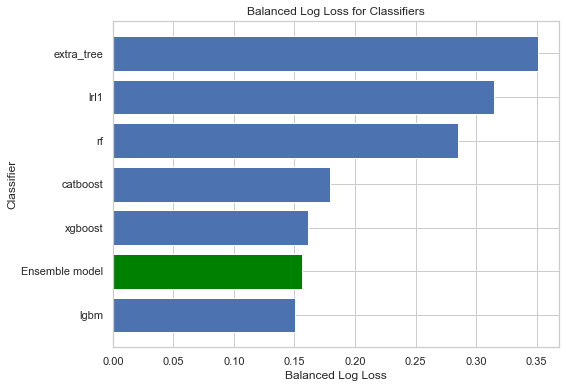

In [59]:
# Sort the balanced log loss scores and corresponding classifiers
sorted_scores = sorted(zip(balanced_logloss_scores + [balanced_logloss], list(best_estimators.keys()) + ['Ensemble model']))
sorted_scores, sorted_classifiers = zip(*sorted_scores)

# Plot the balanced log loss results
plt.figure(figsize=(8, 6))
plt.barh(sorted_classifiers, sorted_scores)  # Use barh for horizontal bar plot
plt.barh('Ensemble model', balanced_logloss, color='green')  # Add the 'Ensemble model' bar
plt.xlabel('Balanced Log Loss')
plt.ylabel('Classifier')
plt.title('Balanced Log Loss for Classifiers')
plt.show()

In [30]:
y_pred = voting_model.predict_proba(test_y)

In [31]:
threshold = 0.7  # Set the desired threshold value
#y_pred_proba_thresholded = np.where(y_pred >= threshold, 1, 0)
#y_pred_proba_thresholded

In [32]:
y_pred

array([[0.66322839, 0.33677162],
       [0.66322839, 0.33677162],
       [0.66322839, 0.33677162],
       [0.66322839, 0.33677162],
       [0.66322839, 0.33677162]])

In [33]:
output = pd.DataFrame({'id': test.Id,
                       'Class_0': y_pred[:,0],
                      'Class_1':y_pred[:,1]},
                     )
output

id   Class_0   Class_1
0  00eed32682bb  0.663228  0.336772
1  010ebe33f668  0.663228  0.336772
2  02fa521e1838  0.663228  0.336772
3  040e15f562a2  0.663228  0.336772
4  046e85c7cc7f  0.663228  0.336772

In [34]:
output.to_csv('submission.csv', index=False)

#### AutoML (Need to download the flaml Package)

In [36]:
### The competition do not allowed access to internet 
### Kaggle do not have this package

from flaml import AutoML

automl = AutoML()

automl_settings = {
    "time_budget": 10800,  # total running time in seconds
    "task": 'classification',  # task type
    "seed": 24545678,  # random seed
    "metric": 'log_loss',  
    "eval_method": 'cv',
    "n_splits": 7,
    "ensemble": True,
    "ensemble": {
        "final_estimator": RandomForestClassifier(),
        "passthrough": True,
        "n_estimators": 100,  # number of estimators for ensemble
        "learning_rate": 0.1  # learning rate for boosting
    }
}

pipeline_settings = {f"automl__{key}": value for key, value in automl_settings.items()}


In [37]:

automl_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ("automl", automl)
])


automl_pipeline 


Pipeline(steps=[('preprocessor', StandardScaler()),
                ('automl',
                 AutoML(append_log=False, auto_augment=True, custom_hp={},
                        cv_score_agg_func=None, early_stop=False,
                        ensemble=False, estimator_list='auto',
                        eval_method='auto', fit_kwargs_by_estimator={},
                        force_cancel=False, free_mem_ratio=0, hpo_method='auto',
                        keep_search_state=False, learner_selector='sample',
                        log_file_name='', log_training_metric=False,
                        log_type='better', max_iter=None, mem_thres=4294967296,
                        metric='auto', metric_constraints=[],
                        min_sample_size=10000, mlflow_logging=True,
                        model_history=False, n_concurrent_trials=1, n_jobs=-1,
                        n_splits=5, pred_time_limit=inf,
                        preserve_checkpoint=True, retrain_full=True, ...))])

In [38]:

automl_pipeline = automl_pipeline.fit(X_train, y_train, **pipeline_settings)


[flaml.automl.logger: 07-11 17:28:02] {1693} INFO - task = classification
[flaml.automl.logger: 07-11 17:28:02] {1700} INFO - Data split method: stratified
[flaml.automl.logger: 07-11 17:28:02] {1703} INFO - Evaluation method: cv
[flaml.automl.logger: 07-11 17:28:02] {1801} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 07-11 17:28:02] {1911} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-11 17:28:02] {2221} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-11 17:28:02] {2347} INFO - Estimated sufficient time budget=459s. Estimated necessary time budget=11s.
[flaml.automl.logger: 07-11 17:28:02] {2394} INFO -  at 0.1s,	estimator lgbm's best error=0.3762,	best estimator lgbm's best error=0.3762
[flaml.automl.logger: 07-11 17:28:02] {2221} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-11 17:28:02] {2394} INFO -  at 0.1s,	estimator lgbm's be

[flaml.automl.logger: 07-11 17:28:05] {2394} INFO -  at 2.7s,	estimator extra_tree's best error=0.3423,	best estimator lgbm's best error=0.2094
[flaml.automl.logger: 07-11 17:28:05] {2221} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 07-11 17:28:05] {2394} INFO -  at 2.8s,	estimator lgbm's best error=0.2094,	best estimator lgbm's best error=0.2094
[flaml.automl.logger: 07-11 17:28:05] {2221} INFO - iteration 35, current learner rf
[flaml.automl.logger: 07-11 17:28:05] {2394} INFO -  at 2.9s,	estimator rf's best error=0.3141,	best estimator lgbm's best error=0.2094
[flaml.automl.logger: 07-11 17:28:05] {2221} INFO - iteration 36, current learner extra_tree
[flaml.automl.logger: 07-11 17:28:05] {2394} INFO -  at 3.1s,	estimator extra_tree's best error=0.3423,	best estimator lgbm's best error=0.2094
[flaml.automl.logger: 07-11 17:28:05] {2221} INFO - iteration 37, current learner rf
[flaml.automl.logger: 07-11 17:28:05] {2394} INFO -  at 3.2s,	estimator rf's best error=

[flaml.automl.logger: 07-11 17:28:10] {2221} INFO - iteration 70, current learner xgboost
[flaml.automl.logger: 07-11 17:28:10] {2394} INFO -  at 8.1s,	estimator xgboost's best error=0.2142,	best estimator lgbm's best error=0.1888
[flaml.automl.logger: 07-11 17:28:10] {2221} INFO - iteration 71, current learner xgboost
[flaml.automl.logger: 07-11 17:28:10] {2394} INFO -  at 8.2s,	estimator xgboost's best error=0.2142,	best estimator lgbm's best error=0.1888
[flaml.automl.logger: 07-11 17:28:10] {2221} INFO - iteration 72, current learner extra_tree
[flaml.automl.logger: 07-11 17:28:11] {2394} INFO -  at 8.4s,	estimator extra_tree's best error=0.3356,	best estimator lgbm's best error=0.1888
[flaml.automl.logger: 07-11 17:28:11] {2221} INFO - iteration 73, current learner xgboost
[flaml.automl.logger: 07-11 17:28:11] {2394} INFO -  at 8.6s,	estimator xgboost's best error=0.2142,	best estimator lgbm's best error=0.1888
[flaml.automl.logger: 07-11 17:28:11] {2221} INFO - iteration 74, curr

[flaml.automl.logger: 07-11 17:28:18] {2394} INFO -  at 16.2s,	estimator rf's best error=0.2512,	best estimator lgbm's best error=0.1888
[flaml.automl.logger: 07-11 17:28:18] {2221} INFO - iteration 106, current learner catboost
[flaml.automl.logger: 07-11 17:28:19] {2394} INFO -  at 16.8s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1888
[flaml.automl.logger: 07-11 17:28:19] {2221} INFO - iteration 107, current learner extra_tree
[flaml.automl.logger: 07-11 17:28:19] {2394} INFO -  at 17.0s,	estimator extra_tree's best error=0.2629,	best estimator lgbm's best error=0.1888
[flaml.automl.logger: 07-11 17:28:19] {2221} INFO - iteration 108, current learner rf
[flaml.automl.logger: 07-11 17:28:19] {2394} INFO -  at 17.1s,	estimator rf's best error=0.2512,	best estimator lgbm's best error=0.1888
[flaml.automl.logger: 07-11 17:28:19] {2221} INFO - iteration 109, current learner extra_tree
[flaml.automl.logger: 07-11 17:28:20] {2394} INFO -  at 17.3s,	estimator

[flaml.automl.logger: 07-11 17:28:29] {2221} INFO - iteration 141, current learner extra_tree
[flaml.automl.logger: 07-11 17:28:30] {2394} INFO -  at 27.5s,	estimator extra_tree's best error=0.2232,	best estimator lgbm's best error=0.1811
[flaml.automl.logger: 07-11 17:28:30] {2221} INFO - iteration 142, current learner rf
[flaml.automl.logger: 07-11 17:28:30] {2394} INFO -  at 27.7s,	estimator rf's best error=0.2492,	best estimator lgbm's best error=0.1811
[flaml.automl.logger: 07-11 17:28:30] {2221} INFO - iteration 143, current learner extra_tree
[flaml.automl.logger: 07-11 17:28:30] {2394} INFO -  at 28.0s,	estimator extra_tree's best error=0.2232,	best estimator lgbm's best error=0.1811
[flaml.automl.logger: 07-11 17:28:30] {2221} INFO - iteration 144, current learner xgboost
[flaml.automl.logger: 07-11 17:28:30] {2394} INFO -  at 28.2s,	estimator xgboost's best error=0.2063,	best estimator lgbm's best error=0.1811
[flaml.automl.logger: 07-11 17:28:30] {2221} INFO - iteration 145,

[flaml.automl.logger: 07-11 17:28:50] {2221} INFO - iteration 177, current learner catboost
[flaml.automl.logger: 07-11 17:28:53] {2394} INFO -  at 50.6s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:28:53] {2221} INFO - iteration 178, current learner rf
[flaml.automl.logger: 07-11 17:28:53] {2394} INFO -  at 50.8s,	estimator rf's best error=0.2234,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:28:53] {2221} INFO - iteration 179, current learner catboost
[flaml.automl.logger: 07-11 17:28:58] {2394} INFO -  at 55.7s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:28:58] {2221} INFO - iteration 180, current learner xgboost
[flaml.automl.logger: 07-11 17:28:58] {2394} INFO -  at 55.9s,	estimator xgboost's best error=0.2063,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:28:58] {2221} INFO - iteration 181, current

[flaml.automl.logger: 07-11 17:29:10] {2394} INFO -  at 67.7s,	estimator xgboost's best error=0.1988,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:29:10] {2221} INFO - iteration 213, current learner extra_tree
[flaml.automl.logger: 07-11 17:29:10] {2394} INFO -  at 68.1s,	estimator extra_tree's best error=0.2200,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:29:10] {2221} INFO - iteration 214, current learner extra_tree
[flaml.automl.logger: 07-11 17:29:11] {2394} INFO -  at 69.0s,	estimator extra_tree's best error=0.2200,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:29:11] {2221} INFO - iteration 215, current learner catboost
[flaml.automl.logger: 07-11 17:29:14] {2394} INFO -  at 71.3s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:29:14] {2221} INFO - iteration 216, current learner extra_tree
[flaml.automl.logger: 07-11 17:29:14] {2394} INFO -

[flaml.automl.logger: 07-11 17:29:24] {2221} INFO - iteration 247, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:29:24] {2394} INFO -  at 82.0s,	estimator xgb_limitdepth's best error=0.2091,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:29:24] {2221} INFO - iteration 248, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:29:24] {2394} INFO -  at 82.1s,	estimator xgb_limitdepth's best error=0.2091,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:29:24] {2221} INFO - iteration 249, current learner rf
[flaml.automl.logger: 07-11 17:29:25] {2394} INFO -  at 82.7s,	estimator rf's best error=0.2216,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:29:25] {2221} INFO - iteration 250, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:29:25] {2394} INFO -  at 82.8s,	estimator xgb_limitdepth's best error=0.2091,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:29:25

[flaml.automl.logger: 07-11 17:29:37] {2394} INFO -  at 94.6s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:29:37] {2221} INFO - iteration 282, current learner rf
[flaml.automl.logger: 07-11 17:29:38] {2394} INFO -  at 95.4s,	estimator rf's best error=0.2216,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:29:38] {2221} INFO - iteration 283, current learner xgboost
[flaml.automl.logger: 07-11 17:29:38] {2394} INFO -  at 95.7s,	estimator xgboost's best error=0.1988,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:29:38] {2221} INFO - iteration 284, current learner xgboost
[flaml.automl.logger: 07-11 17:29:38] {2394} INFO -  at 96.0s,	estimator xgboost's best error=0.1988,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:29:38] {2221} INFO - iteration 285, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:29:38] {2394} INFO -  at 96.1s,	e

[flaml.automl.logger: 07-11 17:30:00] {2221} INFO - iteration 316, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:30:00] {2394} INFO -  at 117.5s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:30:00] {2221} INFO - iteration 317, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:30:00] {2394} INFO -  at 117.5s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:30:00] {2221} INFO - iteration 318, current learner rf
[flaml.automl.logger: 07-11 17:30:01] {2394} INFO -  at 118.3s,	estimator rf's best error=0.2186,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:30:01] {2221} INFO - iteration 319, current learner lgbm
[flaml.automl.logger: 07-11 17:30:01] {2394} INFO -  at 118.6s,	estimator lgbm's best error=0.1760,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:30:01] {2221} INFO - 

[flaml.automl.logger: 07-11 17:30:13] {2221} INFO - iteration 351, current learner extra_tree
[flaml.automl.logger: 07-11 17:30:15] {2394} INFO -  at 132.8s,	estimator extra_tree's best error=0.2183,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:30:15] {2221} INFO - iteration 352, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:30:15] {2394} INFO -  at 132.9s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:30:15] {2221} INFO - iteration 353, current learner extra_tree
[flaml.automl.logger: 07-11 17:30:16] {2394} INFO -  at 133.7s,	estimator extra_tree's best error=0.2183,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:30:16] {2221} INFO - iteration 354, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:30:16] {2394} INFO -  at 133.8s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07

[flaml.automl.logger: 07-11 17:30:33] {2221} INFO - iteration 386, current learner xgboost
[flaml.automl.logger: 07-11 17:30:33] {2394} INFO -  at 151.2s,	estimator xgboost's best error=0.1988,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:30:33] {2221} INFO - iteration 387, current learner xgboost
[flaml.automl.logger: 07-11 17:30:34] {2394} INFO -  at 151.5s,	estimator xgboost's best error=0.1988,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:30:34] {2221} INFO - iteration 388, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:30:34] {2394} INFO -  at 151.6s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:30:34] {2221} INFO - iteration 389, current learner rf
[flaml.automl.logger: 07-11 17:30:35] {2394} INFO -  at 153.0s,	estimator rf's best error=0.2184,	best estimator lgbm's best error=0.1760
[flaml.automl.logger: 07-11 17:30:35] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 17:30:47] {2221} INFO - iteration 421, current learner catboost
[flaml.automl.logger: 07-11 17:30:50] {2394} INFO -  at 168.0s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:30:50] {2221} INFO - iteration 422, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:30:50] {2394} INFO -  at 168.1s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:30:50] {2221} INFO - iteration 423, current learner xgboost
[flaml.automl.logger: 07-11 17:30:51] {2394} INFO -  at 168.4s,	estimator xgboost's best error=0.1988,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:30:51] {2221} INFO - iteration 424, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:30:51] {2394} INFO -  at 168.4s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:30:

[flaml.automl.logger: 07-11 17:31:06] {2221} INFO - iteration 456, current learner lgbm
[flaml.automl.logger: 07-11 17:31:06] {2394} INFO -  at 184.1s,	estimator lgbm's best error=0.1736,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:31:06] {2221} INFO - iteration 457, current learner extra_tree
[flaml.automl.logger: 07-11 17:31:08] {2394} INFO -  at 185.3s,	estimator extra_tree's best error=0.2183,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:31:08] {2221} INFO - iteration 458, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:31:08] {2394} INFO -  at 185.4s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:31:08] {2221} INFO - iteration 459, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:31:08] {2394} INFO -  at 185.5s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:31:08

[flaml.automl.logger: 07-11 17:31:19] {2394} INFO -  at 196.7s,	estimator lrl1's best error=0.2846,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:31:19] {2221} INFO - iteration 492, current learner lrl1
[flaml.automl.logger: 07-11 17:31:19] {2394} INFO -  at 196.9s,	estimator lrl1's best error=0.2846,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:31:19] {2221} INFO - iteration 493, current learner lrl1
[flaml.automl.logger: 07-11 17:31:19] {2394} INFO -  at 197.1s,	estimator lrl1's best error=0.2846,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:31:19] {2221} INFO - iteration 494, current learner lgbm
[flaml.automl.logger: 07-11 17:31:20] {2394} INFO -  at 197.4s,	estimator lgbm's best error=0.1736,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:31:20] {2221} INFO - iteration 495, current learner lrl1
[flaml.automl.logger: 07-11 17:31:20] {2394} INFO -  at 197.6s,	estimator lrl1's best er

[flaml.automl.logger: 07-11 17:31:27] {2221} INFO - iteration 527, current learner lrl1
[flaml.automl.logger: 07-11 17:31:27] {2394} INFO -  at 204.5s,	estimator lrl1's best error=0.2844,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:31:27] {2221} INFO - iteration 528, current learner lrl1
[flaml.automl.logger: 07-11 17:31:27] {2394} INFO -  at 204.7s,	estimator lrl1's best error=0.2844,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:31:27] {2221} INFO - iteration 529, current learner lrl1
[flaml.automl.logger: 07-11 17:31:27] {2394} INFO -  at 204.9s,	estimator lrl1's best error=0.2844,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:31:27] {2221} INFO - iteration 530, current learner lrl1
[flaml.automl.logger: 07-11 17:31:27] {2394} INFO -  at 205.1s,	estimator lrl1's best error=0.2844,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:31:27] {2221} INFO - iteration 531, current learner xgb_l

[flaml.automl.logger: 07-11 17:31:39] {2394} INFO -  at 217.1s,	estimator xgboost's best error=0.1988,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:31:39] {2221} INFO - iteration 563, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:31:39] {2394} INFO -  at 217.2s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:31:39] {2221} INFO - iteration 564, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:31:40] {2394} INFO -  at 217.3s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:31:40] {2221} INFO - iteration 565, current learner lrl1
[flaml.automl.logger: 07-11 17:31:40] {2394} INFO -  at 217.5s,	estimator lrl1's best error=0.2844,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:31:40] {2221} INFO - iteration 566, current learner lgbm
[flaml.automl.logger: 07-11 17:31:40] {2394} 

[flaml.automl.logger: 07-11 17:32:00] {2394} INFO -  at 237.2s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:32:00] {2221} INFO - iteration 598, current learner lrl1
[flaml.automl.logger: 07-11 17:32:00] {2394} INFO -  at 237.4s,	estimator lrl1's best error=0.2844,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:32:00] {2221} INFO - iteration 599, current learner lrl1
[flaml.automl.logger: 07-11 17:32:00] {2394} INFO -  at 237.6s,	estimator lrl1's best error=0.2844,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:32:00] {2221} INFO - iteration 600, current learner rf
[flaml.automl.logger: 07-11 17:32:00] {2394} INFO -  at 238.0s,	estimator rf's best error=0.2180,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:32:00] {2221} INFO - iteration 601, current learner rf
[flaml.automl.logger: 07-11 17:32:01] {2394} INFO -  at 238.3s,	estimator rf's best error=

[flaml.automl.logger: 07-11 17:32:15] {2221} INFO - iteration 633, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:32:15] {2394} INFO -  at 252.7s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:32:15] {2221} INFO - iteration 634, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:32:15] {2394} INFO -  at 252.7s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:32:15] {2221} INFO - iteration 635, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:32:15] {2394} INFO -  at 252.9s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1736
[flaml.automl.logger: 07-11 17:32:15] {2221} INFO - iteration 636, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:32:15] {2394} INFO -  at 252.9s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1736
[flaml.a

[flaml.automl.logger: 07-11 17:32:30] {2394} INFO -  at 267.6s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:32:30] {2221} INFO - iteration 669, current learner rf
[flaml.automl.logger: 07-11 17:32:31] {2394} INFO -  at 268.5s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:32:31] {2221} INFO - iteration 670, current learner xgboost
[flaml.automl.logger: 07-11 17:32:31] {2394} INFO -  at 268.8s,	estimator xgboost's best error=0.1988,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:32:31] {2221} INFO - iteration 671, current learner rf
[flaml.automl.logger: 07-11 17:32:32] {2394} INFO -  at 269.6s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:32:32] {2221} INFO - iteration 672, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:32:32] {2394} INFO -  at 269.7s,	estima

[flaml.automl.logger: 07-11 17:32:45] {2394} INFO -  at 282.7s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:32:45] {2221} INFO - iteration 704, current learner lrl1
[flaml.automl.logger: 07-11 17:32:45] {2394} INFO -  at 282.9s,	estimator lrl1's best error=0.2844,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:32:45] {2221} INFO - iteration 705, current learner extra_tree
[flaml.automl.logger: 07-11 17:32:47] {2394} INFO -  at 284.3s,	estimator extra_tree's best error=0.2181,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:32:47] {2221} INFO - iteration 706, current learner rf
[flaml.automl.logger: 07-11 17:32:47] {2394} INFO -  at 284.8s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:32:47] {2221} INFO - iteration 707, current learner lgbm
[flaml.automl.logger: 07-11 17:32:48] {2394} INFO -  at 285.3s,	estimator lgbm's b

[flaml.automl.logger: 07-11 17:33:01] {2221} INFO - iteration 739, current learner lrl1
[flaml.automl.logger: 07-11 17:33:01] {2394} INFO -  at 299.1s,	estimator lrl1's best error=0.2844,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:33:01] {2221} INFO - iteration 740, current learner rf
[flaml.automl.logger: 07-11 17:33:02] {2394} INFO -  at 300.1s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:33:02] {2221} INFO - iteration 741, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:33:02] {2394} INFO -  at 300.2s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:33:02] {2221} INFO - iteration 742, current learner extra_tree
[flaml.automl.logger: 07-11 17:33:05] {2394} INFO -  at 302.9s,	estimator extra_tree's best error=0.2179,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:33:05] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 17:33:26] {2221} INFO - iteration 774, current learner extra_tree
[flaml.automl.logger: 07-11 17:33:27] {2394} INFO -  at 325.1s,	estimator extra_tree's best error=0.2179,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:33:27] {2221} INFO - iteration 775, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:33:27] {2394} INFO -  at 325.2s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:33:27] {2221} INFO - iteration 776, current learner extra_tree
[flaml.automl.logger: 07-11 17:33:30] {2394} INFO -  at 328.1s,	estimator extra_tree's best error=0.2179,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:33:30] {2221} INFO - iteration 777, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:33:31] {2394} INFO -  at 328.3s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07

[flaml.automl.logger: 07-11 17:33:54] {2221} INFO - iteration 809, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:33:54] {2394} INFO -  at 351.4s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:33:54] {2221} INFO - iteration 810, current learner lrl1
[flaml.automl.logger: 07-11 17:33:54] {2394} INFO -  at 351.6s,	estimator lrl1's best error=0.2844,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:33:54] {2221} INFO - iteration 811, current learner xgboost
[flaml.automl.logger: 07-11 17:33:54] {2394} INFO -  at 351.9s,	estimator xgboost's best error=0.1988,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:33:54] {2221} INFO - iteration 812, current learner lrl1
[flaml.automl.logger: 07-11 17:33:54] {2394} INFO -  at 352.1s,	estimator lrl1's best error=0.2844,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:33:54] {2221} INFO - iteration 

[flaml.automl.logger: 07-11 17:34:17] {2221} INFO - iteration 844, current learner xgboost
[flaml.automl.logger: 07-11 17:34:17] {2394} INFO -  at 374.6s,	estimator xgboost's best error=0.1988,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:34:17] {2221} INFO - iteration 845, current learner xgboost
[flaml.automl.logger: 07-11 17:34:17] {2394} INFO -  at 374.9s,	estimator xgboost's best error=0.1988,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:34:17] {2221} INFO - iteration 846, current learner extra_tree
[flaml.automl.logger: 07-11 17:34:20] {2394} INFO -  at 377.8s,	estimator extra_tree's best error=0.2179,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:34:20] {2221} INFO - iteration 847, current learner lgbm
[flaml.automl.logger: 07-11 17:34:20] {2394} INFO -  at 378.0s,	estimator lgbm's best error=0.1733,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:34:20] {2221} INFO - iteration 84

[flaml.automl.logger: 07-11 17:34:36] {2221} INFO - iteration 879, current learner xgboost
[flaml.automl.logger: 07-11 17:34:36] {2394} INFO -  at 393.9s,	estimator xgboost's best error=0.1988,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:34:36] {2221} INFO - iteration 880, current learner lgbm
[flaml.automl.logger: 07-11 17:34:36] {2394} INFO -  at 394.1s,	estimator lgbm's best error=0.1733,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:34:36] {2221} INFO - iteration 881, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:34:37] {2394} INFO -  at 394.2s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:34:37] {2221} INFO - iteration 882, current learner lgbm
[flaml.automl.logger: 07-11 17:34:37] {2394} INFO -  at 394.6s,	estimator lgbm's best error=0.1733,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:34:37] {2221} INFO - iteration 

[flaml.automl.logger: 07-11 17:35:04] {2221} INFO - iteration 914, current learner lgbm
[flaml.automl.logger: 07-11 17:35:05] {2394} INFO -  at 422.4s,	estimator lgbm's best error=0.1733,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:35:05] {2221} INFO - iteration 915, current learner extra_tree
[flaml.automl.logger: 07-11 17:35:07] {2394} INFO -  at 425.1s,	estimator extra_tree's best error=0.2179,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:35:07] {2221} INFO - iteration 916, current learner lgbm
[flaml.automl.logger: 07-11 17:35:08] {2394} INFO -  at 425.3s,	estimator lgbm's best error=0.1733,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:35:08] {2221} INFO - iteration 917, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:35:08] {2394} INFO -  at 425.4s,	estimator xgb_limitdepth's best error=0.2005,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:35:08] {2221} INFO - iter

[flaml.automl.logger: 07-11 17:35:32] {2394} INFO -  at 450.1s,	estimator xgboost's best error=0.1968,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:35:32] {2221} INFO - iteration 950, current learner lrl1
[flaml.automl.logger: 07-11 17:35:33] {2394} INFO -  at 450.3s,	estimator lrl1's best error=0.2844,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:35:33] {2221} INFO - iteration 951, current learner lgbm
[flaml.automl.logger: 07-11 17:35:33] {2394} INFO -  at 450.8s,	estimator lgbm's best error=0.1733,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:35:33] {2221} INFO - iteration 952, current learner lrl1
[flaml.automl.logger: 07-11 17:35:33] {2394} INFO -  at 451.1s,	estimator lrl1's best error=0.2844,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:35:33] {2221} INFO - iteration 953, current learner rf
[flaml.automl.logger: 07-11 17:35:34] {2394} INFO -  at 451.8s,	estimator rf's best err

[flaml.automl.logger: 07-11 17:35:55] {2221} INFO - iteration 985, current learner rf
[flaml.automl.logger: 07-11 17:35:56] {2394} INFO -  at 473.9s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:35:56] {2221} INFO - iteration 986, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:35:56] {2394} INFO -  at 474.1s,	estimator xgb_limitdepth's best error=0.1958,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:35:56] {2221} INFO - iteration 987, current learner lgbm
[flaml.automl.logger: 07-11 17:35:57] {2394} INFO -  at 474.8s,	estimator lgbm's best error=0.1733,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:35:57] {2221} INFO - iteration 988, current learner lgbm
[flaml.automl.logger: 07-11 17:35:57] {2394} INFO -  at 475.1s,	estimator lgbm's best error=0.1733,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:35:57] {2221} INFO - iteration 989, curre

[flaml.automl.logger: 07-11 17:36:12] {2394} INFO -  at 489.7s,	estimator xgb_limitdepth's best error=0.1928,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:36:12] {2221} INFO - iteration 1020, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:36:12] {2394} INFO -  at 489.9s,	estimator xgb_limitdepth's best error=0.1928,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:36:12] {2221} INFO - iteration 1021, current learner lgbm
[flaml.automl.logger: 07-11 17:36:13] {2394} INFO -  at 490.4s,	estimator lgbm's best error=0.1733,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:36:13] {2221} INFO - iteration 1022, current learner catboost
[flaml.automl.logger: 07-11 17:36:16] {2394} INFO -  at 493.4s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:36:16] {2221} INFO - iteration 1023, current learner xgboost
[flaml.automl.logger: 07-11 17:36:16] {2394

[flaml.automl.logger: 07-11 17:36:24] {2221} INFO - iteration 1054, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:36:25] {2394} INFO -  at 502.3s,	estimator xgb_limitdepth's best error=0.1928,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:36:25] {2221} INFO - iteration 1055, current learner lrl1
[flaml.automl.logger: 07-11 17:36:25] {2394} INFO -  at 502.5s,	estimator lrl1's best error=0.2844,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:36:25] {2221} INFO - iteration 1056, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:36:25] {2394} INFO -  at 502.7s,	estimator xgb_limitdepth's best error=0.1928,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:36:25] {2221} INFO - iteration 1057, current learner xgboost
[flaml.automl.logger: 07-11 17:36:26] {2394} INFO -  at 504.0s,	estimator xgboost's best error=0.1968,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:36:26] 

[flaml.automl.logger: 07-11 17:36:37] {2221} INFO - iteration 1089, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:36:37] {2394} INFO -  at 514.7s,	estimator xgb_limitdepth's best error=0.1928,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:36:37] {2221} INFO - iteration 1090, current learner lgbm
[flaml.automl.logger: 07-11 17:36:37] {2394} INFO -  at 515.1s,	estimator lgbm's best error=0.1733,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:36:37] {2221} INFO - iteration 1091, current learner catboost
[flaml.automl.logger: 07-11 17:36:40] {2394} INFO -  at 517.7s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:36:40] {2221} INFO - iteration 1092, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:36:40] {2394} INFO -  at 518.0s,	estimator xgb_limitdepth's best error=0.1928,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:36:40

[flaml.automl.logger: 07-11 17:36:59] {2221} INFO - iteration 1124, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:36:59] {2394} INFO -  at 536.9s,	estimator xgb_limitdepth's best error=0.1928,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:36:59] {2221} INFO - iteration 1125, current learner lrl1
[flaml.automl.logger: 07-11 17:36:59] {2394} INFO -  at 537.1s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:36:59] {2221} INFO - iteration 1126, current learner lgbm
[flaml.automl.logger: 07-11 17:37:00] {2394} INFO -  at 537.7s,	estimator lgbm's best error=0.1733,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:37:00] {2221} INFO - iteration 1127, current learner lrl1
[flaml.automl.logger: 07-11 17:37:00] {2394} INFO -  at 537.9s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:37:00] {2221} INFO - iteration 11

[flaml.automl.logger: 07-11 17:37:07] {2394} INFO -  at 545.0s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:37:07] {2221} INFO - iteration 1160, current learner xgboost
[flaml.automl.logger: 07-11 17:37:08] {2394} INFO -  at 545.3s,	estimator xgboost's best error=0.1968,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:37:08] {2221} INFO - iteration 1161, current learner catboost
[flaml.automl.logger: 07-11 17:37:11] {2394} INFO -  at 548.3s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:37:11] {2221} INFO - iteration 1162, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:37:11] {2394} INFO -  at 548.6s,	estimator xgb_limitdepth's best error=0.1904,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:37:11] {2221} INFO - iteration 1163, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:37:11] {2

[flaml.automl.logger: 07-11 17:37:30] {2394} INFO -  at 568.2s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:37:30] {2221} INFO - iteration 1195, current learner extra_tree
[flaml.automl.logger: 07-11 17:37:33] {2394} INFO -  at 571.1s,	estimator extra_tree's best error=0.2179,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:37:33] {2221} INFO - iteration 1196, current learner lrl1
[flaml.automl.logger: 07-11 17:37:34] {2394} INFO -  at 571.3s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:37:34] {2221} INFO - iteration 1197, current learner lrl1
[flaml.automl.logger: 07-11 17:37:34] {2394} INFO -  at 571.5s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:37:34] {2221} INFO - iteration 1198, current learner lgbm
[flaml.automl.logger: 07-11 17:37:34] {2394} INFO -  at 572.0s,	estimato

[flaml.automl.logger: 07-11 17:37:56] {2394} INFO -  at 593.8s,	estimator xgb_limitdepth's best error=0.1904,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:37:56] {2221} INFO - iteration 1230, current learner lrl1
[flaml.automl.logger: 07-11 17:37:56] {2394} INFO -  at 594.1s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:37:56] {2221} INFO - iteration 1231, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:37:57] {2394} INFO -  at 594.3s,	estimator xgb_limitdepth's best error=0.1904,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:37:57] {2221} INFO - iteration 1232, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:37:57] {2394} INFO -  at 594.5s,	estimator xgb_limitdepth's best error=0.1904,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:37:57] {2221} INFO - iteration 1233, current learner xgboost
[flaml.automl.logger: 07-11 17:

[flaml.automl.logger: 07-11 17:38:23] {2394} INFO -  at 620.4s,	estimator xgboost's best error=0.1968,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:38:23] {2221} INFO - iteration 1265, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:38:23] {2394} INFO -  at 620.9s,	estimator xgb_limitdepth's best error=0.1904,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:38:23] {2221} INFO - iteration 1266, current learner rf
[flaml.automl.logger: 07-11 17:38:24] {2394} INFO -  at 621.7s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1733
[flaml.automl.logger: 07-11 17:38:24] {2221} INFO - iteration 1267, current learner lgbm
[flaml.automl.logger: 07-11 17:38:24] {2394} INFO -  at 622.0s,	estimator lgbm's best error=0.1732,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:38:24] {2221} INFO - iteration 1268, current learner lrl1
[flaml.automl.logger: 07-11 17:38:24] {2394} INFO -  at 622.2s,	e

[flaml.automl.logger: 07-11 17:38:44] {2394} INFO -  at 641.7s,	estimator xgboost's best error=0.1968,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:38:44] {2221} INFO - iteration 1300, current learner lrl1
[flaml.automl.logger: 07-11 17:38:44] {2394} INFO -  at 641.9s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:38:44] {2221} INFO - iteration 1301, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:38:44] {2394} INFO -  at 642.2s,	estimator xgb_limitdepth's best error=0.1904,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:38:44] {2221} INFO - iteration 1302, current learner lrl1
[flaml.automl.logger: 07-11 17:38:45] {2394} INFO -  at 642.4s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:38:45] {2221} INFO - iteration 1303, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:38:45] {2394} INFO -

[flaml.automl.logger: 07-11 17:39:08] {2221} INFO - iteration 1334, current learner catboost
[flaml.automl.logger: 07-11 17:39:12] {2394} INFO -  at 669.8s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:39:12] {2221} INFO - iteration 1335, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:39:12] {2394} INFO -  at 670.1s,	estimator xgb_limitdepth's best error=0.1904,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:39:12] {2221} INFO - iteration 1336, current learner lgbm
[flaml.automl.logger: 07-11 17:39:13] {2394} INFO -  at 670.7s,	estimator lgbm's best error=0.1732,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:39:13] {2221} INFO - iteration 1337, current learner rf
[flaml.automl.logger: 07-11 17:39:14] {2394} INFO -  at 671.8s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:39:14] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 17:39:30] {2394} INFO -  at 687.4s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:39:30] {2221} INFO - iteration 1369, current learner lgbm
[flaml.automl.logger: 07-11 17:39:30] {2394} INFO -  at 687.7s,	estimator lgbm's best error=0.1732,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:39:30] {2221} INFO - iteration 1370, current learner catboost
[flaml.automl.logger: 07-11 17:39:34] {2394} INFO -  at 692.0s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:39:34] {2221} INFO - iteration 1371, current learner lrl1
[flaml.automl.logger: 07-11 17:39:34] {2394} INFO -  at 692.2s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:39:34] {2221} INFO - iteration 1372, current learner lrl1
[flaml.automl.logger: 07-11 17:39:35] {2394} INFO -  at 692.4s,	estimator lr

[flaml.automl.logger: 07-11 17:39:51] {2221} INFO - iteration 1404, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:39:51] {2394} INFO -  at 709.0s,	estimator xgb_limitdepth's best error=0.1904,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:39:51] {2221} INFO - iteration 1405, current learner lrl1
[flaml.automl.logger: 07-11 17:39:51] {2394} INFO -  at 709.2s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:39:51] {2221} INFO - iteration 1406, current learner lrl1
[flaml.automl.logger: 07-11 17:39:52] {2394} INFO -  at 709.4s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:39:52] {2221} INFO - iteration 1407, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:39:52] {2394} INFO -  at 709.7s,	estimator xgb_limitdepth's best error=0.1904,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:39:52] {2221}

[flaml.automl.logger: 07-11 17:40:11] {2221} INFO - iteration 1439, current learner lrl1
[flaml.automl.logger: 07-11 17:40:11] {2394} INFO -  at 728.7s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:40:11] {2221} INFO - iteration 1440, current learner lrl1
[flaml.automl.logger: 07-11 17:40:11] {2394} INFO -  at 728.8s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:40:11] {2221} INFO - iteration 1441, current learner lrl1
[flaml.automl.logger: 07-11 17:40:11] {2394} INFO -  at 729.0s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:40:11] {2221} INFO - iteration 1442, current learner xgboost
[flaml.automl.logger: 07-11 17:40:13] {2394} INFO -  at 730.9s,	estimator xgboost's best error=0.1968,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:40:13] {2221} INFO - iteration 1443, current le

[flaml.automl.logger: 07-11 17:40:31] {2394} INFO -  at 748.6s,	estimator lgbm's best error=0.1732,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:40:31] {2221} INFO - iteration 1475, current learner extra_tree
[flaml.automl.logger: 07-11 17:40:33] {2394} INFO -  at 750.6s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:40:33] {2221} INFO - iteration 1476, current learner lgbm
[flaml.automl.logger: 07-11 17:40:33] {2394} INFO -  at 750.8s,	estimator lgbm's best error=0.1732,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:40:33] {2221} INFO - iteration 1477, current learner rf
[flaml.automl.logger: 07-11 17:40:34] {2394} INFO -  at 751.9s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1732
[flaml.automl.logger: 07-11 17:40:34] {2221} INFO - iteration 1478, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:40:34] {2394} INFO -  at 752.2s,	es

[flaml.automl.logger: 07-11 17:40:54] {2394} INFO -  at 771.8s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:40:54] {2221} INFO - iteration 1510, current learner rf
[flaml.automl.logger: 07-11 17:40:55] {2394} INFO -  at 772.5s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:40:55] {2221} INFO - iteration 1511, current learner lgbm
[flaml.automl.logger: 07-11 17:40:55] {2394} INFO -  at 772.8s,	estimator lgbm's best error=0.1728,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:40:55] {2221} INFO - iteration 1512, current learner xgboost
[flaml.automl.logger: 07-11 17:40:56] {2394} INFO -  at 773.6s,	estimator xgboost's best error=0.1968,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:40:56] {2221} INFO - iteration 1513, current learner catboost
[flaml.automl.logger: 07-11 17:41:00] {2394} INFO -  at 777.7s,	esti

[flaml.automl.logger: 07-11 17:41:15] {2221} INFO - iteration 1545, current learner lgbm
[flaml.automl.logger: 07-11 17:41:15] {2394} INFO -  at 793.0s,	estimator lgbm's best error=0.1728,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:41:15] {2221} INFO - iteration 1546, current learner lrl1
[flaml.automl.logger: 07-11 17:41:16] {2394} INFO -  at 793.3s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:41:16] {2221} INFO - iteration 1547, current learner lgbm
[flaml.automl.logger: 07-11 17:41:16] {2394} INFO -  at 793.9s,	estimator lgbm's best error=0.1728,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:41:16] {2221} INFO - iteration 1548, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:41:16] {2394} INFO -  at 794.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:41:16] {2221} INFO - iteration 15

[flaml.automl.logger: 07-11 17:41:33] {2221} INFO - iteration 1580, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:41:34] {2394} INFO -  at 811.5s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:41:34] {2221} INFO - iteration 1581, current learner lgbm
[flaml.automl.logger: 07-11 17:41:34] {2394} INFO -  at 811.8s,	estimator lgbm's best error=0.1728,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:41:34] {2221} INFO - iteration 1582, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:41:34] {2394} INFO -  at 812.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:41:34] {2221} INFO - iteration 1583, current learner extra_tree
[flaml.automl.logger: 07-11 17:41:36] {2394} INFO -  at 813.7s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:4

[flaml.automl.logger: 07-11 17:41:50] {2221} INFO - iteration 1615, current learner lgbm
[flaml.automl.logger: 07-11 17:41:51] {2394} INFO -  at 828.3s,	estimator lgbm's best error=0.1728,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:41:51] {2221} INFO - iteration 1616, current learner lgbm
[flaml.automl.logger: 07-11 17:41:51] {2394} INFO -  at 828.6s,	estimator lgbm's best error=0.1728,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:41:51] {2221} INFO - iteration 1617, current learner lrl1
[flaml.automl.logger: 07-11 17:41:51] {2394} INFO -  at 828.8s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:41:51] {2221} INFO - iteration 1618, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:41:51] {2394} INFO -  at 829.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:41:51] {2221} INFO - iteration 16

[flaml.automl.logger: 07-11 17:42:14] {2221} INFO - iteration 1650, current learner lrl1
[flaml.automl.logger: 07-11 17:42:14] {2394} INFO -  at 851.5s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:42:14] {2221} INFO - iteration 1651, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:42:14] {2394} INFO -  at 851.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:42:14] {2221} INFO - iteration 1652, current learner lrl1
[flaml.automl.logger: 07-11 17:42:14] {2394} INFO -  at 851.9s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:42:14] {2221} INFO - iteration 1653, current learner rf
[flaml.automl.logger: 07-11 17:42:15] {2394} INFO -  at 852.8s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:42:15] {2221} INFO - iteration 1654, 

[flaml.automl.logger: 07-11 17:42:31] {2221} INFO - iteration 1685, current learner lrl1
[flaml.automl.logger: 07-11 17:42:31] {2394} INFO -  at 868.7s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:42:31] {2221} INFO - iteration 1686, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:42:31] {2394} INFO -  at 869.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:42:31] {2221} INFO - iteration 1687, current learner lgbm
[flaml.automl.logger: 07-11 17:42:32] {2394} INFO -  at 869.7s,	estimator lgbm's best error=0.1728,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:42:32] {2221} INFO - iteration 1688, current learner lgbm
[flaml.automl.logger: 07-11 17:42:33] {2394} INFO -  at 870.3s,	estimator lgbm's best error=0.1728,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:42:33] {2221} INFO - iteration 16

[flaml.automl.logger: 07-11 17:42:52] {2394} INFO -  at 890.0s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:42:52] {2221} INFO - iteration 1721, current learner lgbm
[flaml.automl.logger: 07-11 17:42:53] {2394} INFO -  at 890.3s,	estimator lgbm's best error=0.1728,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:42:53] {2221} INFO - iteration 1722, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:42:53] {2394} INFO -  at 890.8s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:42:53] {2221} INFO - iteration 1723, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:42:53] {2394} INFO -  at 891.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1728
[flaml.automl.logger: 07-11 17:42:53] {2221} INFO - iteration 1724, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 

[flaml.automl.logger: 07-11 17:43:13] {2394} INFO -  at 911.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:43:13] {2221} INFO - iteration 1756, current learner lrl1
[flaml.automl.logger: 07-11 17:43:14] {2394} INFO -  at 911.4s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:43:14] {2221} INFO - iteration 1757, current learner rf
[flaml.automl.logger: 07-11 17:43:15] {2394} INFO -  at 912.3s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:43:15] {2221} INFO - iteration 1758, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:43:15] {2394} INFO -  at 913.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:43:15] {2221} INFO - iteration 1759, current learner xgboost
[flaml.automl.logger: 07-11 17:43:16] {2394} INFO -  at

[flaml.automl.logger: 07-11 17:43:37] {2394} INFO -  at 935.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:43:37] {2221} INFO - iteration 1791, current learner lrl1
[flaml.automl.logger: 07-11 17:43:37] {2394} INFO -  at 935.2s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:43:37] {2221} INFO - iteration 1792, current learner lrl1
[flaml.automl.logger: 07-11 17:43:38] {2394} INFO -  at 935.4s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:43:38] {2221} INFO - iteration 1793, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:43:38] {2394} INFO -  at 935.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:43:38] {2221} INFO - iteration 1794, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:43:38] {2394}

[flaml.automl.logger: 07-11 17:44:08] {2394} INFO -  at 965.4s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:44:08] {2221} INFO - iteration 1826, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:44:08] {2394} INFO -  at 965.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:44:08] {2221} INFO - iteration 1827, current learner lgbm
[flaml.automl.logger: 07-11 17:44:09] {2394} INFO -  at 966.4s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:44:09] {2221} INFO - iteration 1828, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:44:09] {2394} INFO -  at 966.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:44:09] {2221} INFO - iteration 1829, current learner lrl1
[flaml.automl.logger: 07-11 17:44:09] {23

[flaml.automl.logger: 07-11 17:44:27] {2221} INFO - iteration 1860, current learner lrl1
[flaml.automl.logger: 07-11 17:44:27] {2394} INFO -  at 985.2s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:44:27] {2221} INFO - iteration 1861, current learner lrl1
[flaml.automl.logger: 07-11 17:44:28] {2394} INFO -  at 985.4s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:44:28] {2221} INFO - iteration 1862, current learner xgboost
[flaml.automl.logger: 07-11 17:44:30] {2394} INFO -  at 987.9s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:44:30] {2221} INFO - iteration 1863, current learner lgbm
[flaml.automl.logger: 07-11 17:44:30] {2394} INFO -  at 988.1s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:44:30] {2221} INFO - iteration 1864, current le

[flaml.automl.logger: 07-11 17:44:50] {2221} INFO - iteration 1895, current learner lrl1
[flaml.automl.logger: 07-11 17:44:50] {2394} INFO -  at 1008.0s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:44:50] {2221} INFO - iteration 1896, current learner lgbm
[flaml.automl.logger: 07-11 17:44:51] {2394} INFO -  at 1008.3s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:44:51] {2221} INFO - iteration 1897, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:44:51] {2394} INFO -  at 1008.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:44:51] {2221} INFO - iteration 1898, current learner lrl1
[flaml.automl.logger: 07-11 17:44:51] {2394} INFO -  at 1008.9s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:44:51] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 17:45:15] {2221} INFO - iteration 1930, current learner xgboost
[flaml.automl.logger: 07-11 17:45:16] {2394} INFO -  at 1033.9s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:45:16] {2221} INFO - iteration 1931, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:45:17] {2394} INFO -  at 1034.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:45:17] {2221} INFO - iteration 1932, current learner lgbm
[flaml.automl.logger: 07-11 17:45:17] {2394} INFO -  at 1034.8s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:45:17] {2221} INFO - iteration 1933, current learner lrl1
[flaml.automl.logger: 07-11 17:45:17] {2394} INFO -  at 1035.0s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:45:17] {2221} INFO - it

[flaml.automl.logger: 07-11 17:45:34] {2221} INFO - iteration 1965, current learner xgboost
[flaml.automl.logger: 07-11 17:45:35] {2394} INFO -  at 1052.9s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:45:35] {2221} INFO - iteration 1966, current learner xgboost
[flaml.automl.logger: 07-11 17:45:37] {2394} INFO -  at 1054.7s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:45:37] {2221} INFO - iteration 1967, current learner lrl1
[flaml.automl.logger: 07-11 17:45:37] {2394} INFO -  at 1054.9s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:45:37] {2221} INFO - iteration 1968, current learner lrl1
[flaml.automl.logger: 07-11 17:45:37] {2394} INFO -  at 1055.1s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:45:37] {2221} INFO - iteration 1969, 

[flaml.automl.logger: 07-11 17:46:00] {2394} INFO -  at 1078.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:46:00] {2221} INFO - iteration 2001, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:46:01] {2394} INFO -  at 1078.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:46:01] {2221} INFO - iteration 2002, current learner xgboost
[flaml.automl.logger: 07-11 17:46:02] {2394} INFO -  at 1079.6s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:46:02] {2221} INFO - iteration 2003, current learner lgbm
[flaml.automl.logger: 07-11 17:46:02] {2394} INFO -  at 1080.1s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:46:02] {2221} INFO - iteration 2004, current learner lrl1
[flaml.automl.logger: 07-11 17:46:03] {2394}

[flaml.automl.logger: 07-11 17:46:27] {2394} INFO -  at 1104.7s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:46:27] {2221} INFO - iteration 2036, current learner lgbm
[flaml.automl.logger: 07-11 17:46:28] {2394} INFO -  at 1105.3s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:46:28] {2221} INFO - iteration 2037, current learner lgbm
[flaml.automl.logger: 07-11 17:46:28] {2394} INFO -  at 1105.6s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:46:28] {2221} INFO - iteration 2038, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:46:28] {2394} INFO -  at 1105.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:46:28] {2221} INFO - iteration 2039, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:46:29] {2394} INFO - 

[flaml.automl.logger: 07-11 17:46:51] {2394} INFO -  at 1128.8s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:46:51] {2221} INFO - iteration 2071, current learner lgbm
[flaml.automl.logger: 07-11 17:46:51] {2394} INFO -  at 1129.0s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:46:51] {2221} INFO - iteration 2072, current learner lgbm
[flaml.automl.logger: 07-11 17:46:52] {2394} INFO -  at 1129.5s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:46:52] {2221} INFO - iteration 2073, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:46:52] {2394} INFO -  at 1129.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:46:52] {2221} INFO - iteration 2074, current learner lgbm
[flaml.automl.logger: 07-11 17:46:53] {2394} INFO -  at 1130

[flaml.automl.logger: 07-11 17:47:19] {2394} INFO -  at 1157.2s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:47:19] {2221} INFO - iteration 2106, current learner rf
[flaml.automl.logger: 07-11 17:47:20] {2394} INFO -  at 1158.2s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:47:20] {2221} INFO - iteration 2107, current learner xgboost
[flaml.automl.logger: 07-11 17:47:22] {2394} INFO -  at 1160.1s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:47:22] {2221} INFO - iteration 2108, current learner extra_tree
[flaml.automl.logger: 07-11 17:47:25] {2394} INFO -  at 1162.3s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:47:25] {2221} INFO - iteration 2109, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:47:25] {2394} INFO -  at 11

[flaml.automl.logger: 07-11 17:47:48] {2394} INFO -  at 1185.7s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:47:48] {2221} INFO - iteration 2141, current learner extra_tree
[flaml.automl.logger: 07-11 17:47:50] {2394} INFO -  at 1187.5s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:47:50] {2221} INFO - iteration 2142, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:47:50] {2394} INFO -  at 1187.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:47:50] {2221} INFO - iteration 2143, current learner lgbm
[flaml.automl.logger: 07-11 17:47:50] {2394} INFO -  at 1188.2s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:47:50] {2221} INFO - iteration 2144, current learner catboost
[flaml.automl.logger: 07-11 17:47:53] {2

[flaml.automl.logger: 07-11 17:48:20] {2221} INFO - iteration 2175, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:48:21] {2394} INFO -  at 1218.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:48:21] {2221} INFO - iteration 2176, current learner lgbm
[flaml.automl.logger: 07-11 17:48:21] {2394} INFO -  at 1218.8s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:48:21] {2221} INFO - iteration 2177, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:48:21] {2394} INFO -  at 1219.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:48:21] {2221} INFO - iteration 2178, current learner catboost
[flaml.automl.logger: 07-11 17:48:24] {2394} INFO -  at 1221.8s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:4

[flaml.automl.logger: 07-11 17:48:52] {2221} INFO - iteration 2210, current learner lgbm
[flaml.automl.logger: 07-11 17:48:53] {2394} INFO -  at 1250.6s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:48:53] {2221} INFO - iteration 2211, current learner lrl1
[flaml.automl.logger: 07-11 17:48:53] {2394} INFO -  at 1250.8s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:48:53] {2221} INFO - iteration 2212, current learner rf
[flaml.automl.logger: 07-11 17:48:54] {2394} INFO -  at 1251.4s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:48:54] {2221} INFO - iteration 2213, current learner lrl1
[flaml.automl.logger: 07-11 17:48:54] {2394} INFO -  at 1251.6s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:48:54] {2221} INFO - iteration 2214, current learner 

[flaml.automl.logger: 07-11 17:49:23] {2221} INFO - iteration 2245, current learner lgbm
[flaml.automl.logger: 07-11 17:49:23] {2394} INFO -  at 1280.7s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:49:23] {2221} INFO - iteration 2246, current learner rf
[flaml.automl.logger: 07-11 17:49:24] {2394} INFO -  at 1281.4s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:49:24] {2221} INFO - iteration 2247, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:49:24] {2394} INFO -  at 1281.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:49:24] {2221} INFO - iteration 2248, current learner catboost
[flaml.automl.logger: 07-11 17:49:27] {2394} INFO -  at 1284.3s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:49:27] {2221} INFO - iter

[flaml.automl.logger: 07-11 17:49:46] {2221} INFO - iteration 2280, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:49:46] {2394} INFO -  at 1304.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:49:46] {2221} INFO - iteration 2281, current learner lgbm
[flaml.automl.logger: 07-11 17:49:47] {2394} INFO -  at 1304.6s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:49:47] {2221} INFO - iteration 2282, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:49:48] {2394} INFO -  at 1305.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:49:48] {2221} INFO - iteration 2283, current learner extra_tree
[flaml.automl.logger: 07-11 17:49:50] {2394} INFO -  at 1307.6s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 

[flaml.automl.logger: 07-11 17:50:12] {2221} INFO - iteration 2315, current learner catboost
[flaml.automl.logger: 07-11 17:50:15] {2394} INFO -  at 1332.3s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:50:15] {2221} INFO - iteration 2316, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:50:15] {2394} INFO -  at 1332.5s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:50:15] {2221} INFO - iteration 2317, current learner extra_tree
[flaml.automl.logger: 07-11 17:50:16] {2394} INFO -  at 1334.0s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:50:16] {2221} INFO - iteration 2318, current learner lrl1
[flaml.automl.logger: 07-11 17:50:16] {2394} INFO -  at 1334.2s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:50:16] {2

[flaml.automl.logger: 07-11 17:50:37] {2221} INFO - iteration 2350, current learner rf
[flaml.automl.logger: 07-11 17:50:38] {2394} INFO -  at 1355.7s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:50:38] {2221} INFO - iteration 2351, current learner lrl1
[flaml.automl.logger: 07-11 17:50:38] {2394} INFO -  at 1355.9s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:50:38] {2221} INFO - iteration 2352, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:50:39] {2394} INFO -  at 1356.4s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:50:39] {2221} INFO - iteration 2353, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:50:39] {2394} INFO -  at 1356.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:50:39] {2221}

[flaml.automl.logger: 07-11 17:51:07] {2221} INFO - iteration 2385, current learner lgbm
[flaml.automl.logger: 07-11 17:51:07] {2394} INFO -  at 1385.0s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:51:07] {2221} INFO - iteration 2386, current learner rf
[flaml.automl.logger: 07-11 17:51:08] {2394} INFO -  at 1385.7s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:51:08] {2221} INFO - iteration 2387, current learner lgbm
[flaml.automl.logger: 07-11 17:51:08] {2394} INFO -  at 1386.1s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:51:08] {2221} INFO - iteration 2388, current learner lrl1
[flaml.automl.logger: 07-11 17:51:09] {2394} INFO -  at 1386.4s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:51:09] {2221} INFO - iteration 2389, current learner 

[flaml.automl.logger: 07-11 17:51:34] {2394} INFO -  at 1411.3s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:51:34] {2221} INFO - iteration 2421, current learner lgbm
[flaml.automl.logger: 07-11 17:51:34] {2394} INFO -  at 1411.8s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:51:34] {2221} INFO - iteration 2422, current learner lgbm
[flaml.automl.logger: 07-11 17:51:34] {2394} INFO -  at 1412.0s,	estimator lgbm's best error=0.1717,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:51:34] {2221} INFO - iteration 2423, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:51:35] {2394} INFO -  at 1412.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1717
[flaml.automl.logger: 07-11 17:51:35] {2221} INFO - iteration 2424, current learner lgbm
[flaml.automl.logger: 07-11 17:51:35] {2394} INFO -  a

[flaml.automl.logger: 07-11 17:51:57] {2394} INFO -  at 1434.5s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:51:57] {2221} INFO - iteration 2456, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:51:57] {2394} INFO -  at 1434.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:51:57] {2221} INFO - iteration 2457, current learner xgboost
[flaml.automl.logger: 07-11 17:51:58] {2394} INFO -  at 1435.5s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:51:58] {2221} INFO - iteration 2458, current learner lrl1
[flaml.automl.logger: 07-11 17:51:58] {2394} INFO -  at 1435.8s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:51:58] {2221} INFO - iteration 2459, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:51:58] 

[flaml.automl.logger: 07-11 17:52:26] {2394} INFO -  at 1463.7s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:52:26] {2221} INFO - iteration 2491, current learner xgboost
[flaml.automl.logger: 07-11 17:52:27] {2394} INFO -  at 1464.8s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:52:27] {2221} INFO - iteration 2492, current learner catboost
[flaml.automl.logger: 07-11 17:52:30] {2394} INFO -  at 1467.3s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:52:30] {2221} INFO - iteration 2493, current learner xgboost
[flaml.automl.logger: 07-11 17:52:30] {2394} INFO -  at 1468.1s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:52:30] {2221} INFO - iteration 2494, current learner lgbm
[flaml.automl.logger: 07-11 17:52:31] {2394} INFO -  at 1

[flaml.automl.logger: 07-11 17:53:06] {2394} INFO -  at 1503.9s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:53:06] {2221} INFO - iteration 2526, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:53:06] {2394} INFO -  at 1504.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:53:06] {2221} INFO - iteration 2527, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:53:07] {2394} INFO -  at 1504.5s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:53:07] {2221} INFO - iteration 2528, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:53:07] {2394} INFO -  at 1504.8s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:53:07] {2221} INFO - iteration 2529, current learner lrl1
[flaml.automl.logger

[flaml.automl.logger: 07-11 17:53:27] {2394} INFO -  at 1525.0s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:53:27] {2221} INFO - iteration 2561, current learner xgboost
[flaml.automl.logger: 07-11 17:53:28] {2394} INFO -  at 1526.2s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:53:28] {2221} INFO - iteration 2562, current learner rf
[flaml.automl.logger: 07-11 17:53:29] {2394} INFO -  at 1526.9s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:53:29] {2221} INFO - iteration 2563, current learner extra_tree
[flaml.automl.logger: 07-11 17:53:30] {2394} INFO -  at 1528.1s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:53:30] {2221} INFO - iteration 2564, current learner catboost
[flaml.automl.logger: 07-11 17:53:33] {2394} INFO -  at 1531.2

[flaml.automl.logger: 07-11 17:53:55] {2221} INFO - iteration 2596, current learner lgbm
[flaml.automl.logger: 07-11 17:53:55] {2394} INFO -  at 1553.1s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:53:55] {2221} INFO - iteration 2597, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:53:56] {2394} INFO -  at 1553.4s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:53:56] {2221} INFO - iteration 2598, current learner rf
[flaml.automl.logger: 07-11 17:53:56] {2394} INFO -  at 1554.1s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:53:56] {2221} INFO - iteration 2599, current learner xgboost
[flaml.automl.logger: 07-11 17:53:57] {2394} INFO -  at 1555.2s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:53:57] {2221} INFO - iterat

[flaml.automl.logger: 07-11 17:54:24] {2221} INFO - iteration 2631, current learner lrl1
[flaml.automl.logger: 07-11 17:54:24] {2394} INFO -  at 1582.2s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:54:24] {2221} INFO - iteration 2632, current learner xgboost
[flaml.automl.logger: 07-11 17:54:26] {2394} INFO -  at 1583.7s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:54:26] {2221} INFO - iteration 2633, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:54:26] {2394} INFO -  at 1584.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:54:26] {2221} INFO - iteration 2634, current learner lrl1
[flaml.automl.logger: 07-11 17:54:27] {2394} INFO -  at 1584.3s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:54:27] {2221} INFO - it

[flaml.automl.logger: 07-11 17:54:47] {2221} INFO - iteration 2666, current learner lgbm
[flaml.automl.logger: 07-11 17:54:47] {2394} INFO -  at 1605.0s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:54:47] {2221} INFO - iteration 2667, current learner rf
[flaml.automl.logger: 07-11 17:54:48] {2394} INFO -  at 1606.0s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:54:48] {2221} INFO - iteration 2668, current learner extra_tree
[flaml.automl.logger: 07-11 17:54:50] {2394} INFO -  at 1608.0s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:54:50] {2221} INFO - iteration 2669, current learner catboost
[flaml.automl.logger: 07-11 17:54:53] {2394} INFO -  at 1610.5s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:54:53] {2221} INFO - iteration 26

[flaml.automl.logger: 07-11 17:55:17] {2394} INFO -  at 1634.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:55:17] {2221} INFO - iteration 2702, current learner lrl1
[flaml.automl.logger: 07-11 17:55:17] {2394} INFO -  at 1635.2s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:55:17] {2221} INFO - iteration 2703, current learner rf
[flaml.automl.logger: 07-11 17:55:18] {2394} INFO -  at 1636.0s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:55:18] {2221} INFO - iteration 2704, current learner lrl1
[flaml.automl.logger: 07-11 17:55:19] {2394} INFO -  at 1636.2s,	estimator lrl1's best error=0.2843,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:55:19] {2221} INFO - iteration 2705, current learner xgboost
[flaml.automl.logger: 07-11 17:55:19] {2394} INFO -  at 1636.7s,	estima

[flaml.automl.logger: 07-11 17:55:43] {2394} INFO -  at 1661.0s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:55:43] {2221} INFO - iteration 2737, current learner lrl1
[flaml.automl.logger: 07-11 17:55:43] {2394} INFO -  at 1661.2s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:55:43] {2221} INFO - iteration 2738, current learner catboost
[flaml.automl.logger: 07-11 17:55:46] {2394} INFO -  at 1663.9s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:55:46] {2221} INFO - iteration 2739, current learner lgbm
[flaml.automl.logger: 07-11 17:55:47] {2394} INFO -  at 1664.2s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:55:47] {2221} INFO - iteration 2740, current learner lgbm
[flaml.automl.logger: 07-11 17:55:47] {2394} INFO -  at 1664.6s,	est

[flaml.automl.logger: 07-11 17:56:03] {2394} INFO -  at 1681.2s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:56:03] {2221} INFO - iteration 2772, current learner lrl1
[flaml.automl.logger: 07-11 17:56:04] {2394} INFO -  at 1681.4s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:56:04] {2221} INFO - iteration 2773, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:56:04] {2394} INFO -  at 1681.8s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:56:04] {2221} INFO - iteration 2774, current learner xgboost
[flaml.automl.logger: 07-11 17:56:05] {2394} INFO -  at 1682.9s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:56:05] {2221} INFO - iteration 2775, current learner xgboost
[flaml.automl.logger: 07-11 17:56:06] {2394} INFO -

[flaml.automl.logger: 07-11 17:56:23] {2221} INFO - iteration 2807, current learner lgbm
[flaml.automl.logger: 07-11 17:56:24] {2394} INFO -  at 1701.4s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:56:24] {2221} INFO - iteration 2808, current learner extra_tree
[flaml.automl.logger: 07-11 17:56:26] {2394} INFO -  at 1704.0s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:56:26] {2221} INFO - iteration 2809, current learner lrl1
[flaml.automl.logger: 07-11 17:56:26] {2394} INFO -  at 1704.2s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:56:26] {2221} INFO - iteration 2810, current learner lgbm
[flaml.automl.logger: 07-11 17:56:27] {2394} INFO -  at 1704.6s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:56:27] {2221} INFO - iteration 2811, 

[flaml.automl.logger: 07-11 17:56:45] {2394} INFO -  at 1723.2s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:56:45] {2221} INFO - iteration 2843, current learner xgboost
[flaml.automl.logger: 07-11 17:56:47] {2394} INFO -  at 1724.5s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:56:47] {2221} INFO - iteration 2844, current learner xgboost
[flaml.automl.logger: 07-11 17:56:47] {2394} INFO -  at 1725.1s,	estimator xgboost's best error=0.1940,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:56:47] {2221} INFO - iteration 2845, current learner lrl1
[flaml.automl.logger: 07-11 17:56:48] {2394} INFO -  at 1725.4s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:56:48] {2221} INFO - iteration 2846, current learner lgbm
[flaml.automl.logger: 07-11 17:56:48] {2394} INFO -  at 1725.6s,	

[flaml.automl.logger: 07-11 17:57:09] {2394} INFO -  at 1747.2s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:57:09] {2221} INFO - iteration 2878, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:57:10] {2394} INFO -  at 1747.5s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:57:10] {2221} INFO - iteration 2879, current learner rf
[flaml.automl.logger: 07-11 17:57:11] {2394} INFO -  at 1748.5s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:57:11] {2221} INFO - iteration 2880, current learner catboost
[flaml.automl.logger: 07-11 17:57:14] {2394} INFO -  at 1751.9s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:57:14] {2221} INFO - iteration 2881, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:57:14] {2394} I

[flaml.automl.logger: 07-11 17:57:38] {2394} INFO -  at 1775.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:57:38] {2221} INFO - iteration 2913, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:57:38] {2394} INFO -  at 1775.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:57:38] {2221} INFO - iteration 2914, current learner rf
[flaml.automl.logger: 07-11 17:57:39] {2394} INFO -  at 1776.7s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:57:39] {2221} INFO - iteration 2915, current learner lgbm
[flaml.automl.logger: 07-11 17:57:39] {2394} INFO -  at 1777.2s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:57:39] {2221} INFO - iteration 2916, current learner catboost
[flaml.automl.logger: 07-11 17:57:42] {2394} INFO 

[flaml.automl.logger: 07-11 17:58:04] {2394} INFO -  at 1802.1s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:58:04] {2221} INFO - iteration 2948, current learner lgbm
[flaml.automl.logger: 07-11 17:58:05] {2394} INFO -  at 1802.3s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:58:05] {2221} INFO - iteration 2949, current learner extra_tree
[flaml.automl.logger: 07-11 17:58:06] {2394} INFO -  at 1803.8s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:58:06] {2221} INFO - iteration 2950, current learner rf
[flaml.automl.logger: 07-11 17:58:07] {2394} INFO -  at 1804.5s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:58:07] {2221} INFO - iteration 2951, current learner lgbm
[flaml.automl.logger: 07-11 17:58:07] {2394} INFO -  at 1804.9s,	estimator

[flaml.automl.logger: 07-11 17:58:32] {2394} INFO -  at 1829.7s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:58:32] {2221} INFO - iteration 2983, current learner rf
[flaml.automl.logger: 07-11 17:58:33] {2394} INFO -  at 1830.6s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:58:33] {2221} INFO - iteration 2984, current learner rf
[flaml.automl.logger: 07-11 17:58:33] {2394} INFO -  at 1831.1s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:58:33] {2221} INFO - iteration 2985, current learner rf
[flaml.automl.logger: 07-11 17:58:34] {2394} INFO -  at 1832.2s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:58:34] {2221} INFO - iteration 2986, current learner xgboost
[flaml.automl.logger: 07-11 17:58:36] {2394} INFO -  at 1833.5s,	estimator xgboost's best

[flaml.automl.logger: 07-11 17:58:54] {2221} INFO - iteration 3018, current learner lgbm
[flaml.automl.logger: 07-11 17:58:54] {2394} INFO -  at 1852.2s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:58:54] {2221} INFO - iteration 3019, current learner lrl1
[flaml.automl.logger: 07-11 17:58:55] {2394} INFO -  at 1852.4s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:58:55] {2221} INFO - iteration 3020, current learner lrl1
[flaml.automl.logger: 07-11 17:58:55] {2394} INFO -  at 1852.6s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:58:55] {2221} INFO - iteration 3021, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 17:58:55] {2394} INFO -  at 1853.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:58:55] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 17:59:16] {2394} INFO -  at 1873.5s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:59:16] {2221} INFO - iteration 3054, current learner rf
[flaml.automl.logger: 07-11 17:59:17] {2394} INFO -  at 1874.5s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:59:17] {2221} INFO - iteration 3055, current learner lrl1
[flaml.automl.logger: 07-11 17:59:17] {2394} INFO -  at 1874.7s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:59:17] {2221} INFO - iteration 3056, current learner lgbm
[flaml.automl.logger: 07-11 17:59:17] {2394} INFO -  at 1875.0s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:59:17] {2221} INFO - iteration 3057, current learner lgbm
[flaml.automl.logger: 07-11 17:59:18] {2394} INFO -  at 1875.4s,	estimator lgbm's be

[flaml.automl.logger: 07-11 17:59:41] {2394} INFO -  at 1898.3s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:59:41] {2221} INFO - iteration 3089, current learner lgbm
[flaml.automl.logger: 07-11 17:59:41] {2394} INFO -  at 1898.5s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:59:41] {2221} INFO - iteration 3090, current learner lrl1
[flaml.automl.logger: 07-11 17:59:41] {2394} INFO -  at 1898.7s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:59:41] {2221} INFO - iteration 3091, current learner lrl1
[flaml.automl.logger: 07-11 17:59:41] {2394} INFO -  at 1898.9s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 17:59:41] {2221} INFO - iteration 3092, current learner rf
[flaml.automl.logger: 07-11 17:59:42] {2394} INFO -  at 1899.5s,	estimator rf's be

[flaml.automl.logger: 07-11 18:00:07] {2221} INFO - iteration 3124, current learner lgbm
[flaml.automl.logger: 07-11 18:00:08] {2394} INFO -  at 1925.4s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:00:08] {2221} INFO - iteration 3125, current learner lrl1
[flaml.automl.logger: 07-11 18:00:08] {2394} INFO -  at 1925.7s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:00:08] {2221} INFO - iteration 3126, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:00:08] {2394} INFO -  at 1926.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:00:08] {2221} INFO - iteration 3127, current learner lgbm
[flaml.automl.logger: 07-11 18:00:09] {2394} INFO -  at 1926.7s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:00:09] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 18:00:29] {2221} INFO - iteration 3159, current learner lgbm
[flaml.automl.logger: 07-11 18:00:29] {2394} INFO -  at 1946.7s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:00:29] {2221} INFO - iteration 3160, current learner lrl1
[flaml.automl.logger: 07-11 18:00:29] {2394} INFO -  at 1946.9s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:00:29] {2221} INFO - iteration 3161, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:00:30] {2394} INFO -  at 1947.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:00:30] {2221} INFO - iteration 3162, current learner lgbm
[flaml.automl.logger: 07-11 18:00:30] {2394} INFO -  at 1947.8s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:00:30] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 18:00:53] {2221} INFO - iteration 3194, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:00:53] {2394} INFO -  at 1970.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:00:53] {2221} INFO - iteration 3195, current learner rf
[flaml.automl.logger: 07-11 18:00:54] {2394} INFO -  at 1971.5s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:00:54] {2221} INFO - iteration 3196, current learner lgbm
[flaml.automl.logger: 07-11 18:00:54] {2394} INFO -  at 1971.8s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:00:54] {2221} INFO - iteration 3197, current learner rf
[flaml.automl.logger: 07-11 18:00:55] {2394} INFO -  at 1972.7s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:00:55] {2221} INFO - iteration 3198, 

[flaml.automl.logger: 07-11 18:01:21] {2394} INFO -  at 1998.8s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:01:21] {2221} INFO - iteration 3230, current learner lgbm
[flaml.automl.logger: 07-11 18:01:22] {2394} INFO -  at 1999.6s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:01:22] {2221} INFO - iteration 3231, current learner rf
[flaml.automl.logger: 07-11 18:01:22] {2394} INFO -  at 2000.2s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:01:22] {2221} INFO - iteration 3232, current learner lrl1
[flaml.automl.logger: 07-11 18:01:23] {2394} INFO -  at 2000.4s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:01:23] {2221} INFO - iteration 3233, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:01:23] {2394} INFO -  at 2000.7s,	est

[flaml.automl.logger: 07-11 18:01:43] {2221} INFO - iteration 3264, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:01:44] {2394} INFO -  at 2021.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:01:44] {2221} INFO - iteration 3265, current learner lrl1
[flaml.automl.logger: 07-11 18:01:44] {2394} INFO -  at 2021.5s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:01:44] {2221} INFO - iteration 3266, current learner lrl1
[flaml.automl.logger: 07-11 18:01:44] {2394} INFO -  at 2021.7s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:01:44] {2221} INFO - iteration 3267, current learner lrl1
[flaml.automl.logger: 07-11 18:01:44] {2394} INFO -  at 2021.9s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:01:44] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 18:02:08] {2221} INFO - iteration 3299, current learner extra_tree
[flaml.automl.logger: 07-11 18:02:10] {2394} INFO -  at 2047.6s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:02:10] {2221} INFO - iteration 3300, current learner xgboost
[flaml.automl.logger: 07-11 18:02:11] {2394} INFO -  at 2048.9s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:02:11] {2221} INFO - iteration 3301, current learner rf
[flaml.automl.logger: 07-11 18:02:12] {2394} INFO -  at 2049.4s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:02:12] {2221} INFO - iteration 3302, current learner rf
[flaml.automl.logger: 07-11 18:02:13] {2394} INFO -  at 2050.3s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:02:13] {2221} INFO - iteration 3303, cu

[flaml.automl.logger: 07-11 18:02:31] {2221} INFO - iteration 3334, current learner lrl1
[flaml.automl.logger: 07-11 18:02:32] {2394} INFO -  at 2069.3s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:02:32] {2221} INFO - iteration 3335, current learner lrl1
[flaml.automl.logger: 07-11 18:02:32] {2394} INFO -  at 2069.5s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:02:32] {2221} INFO - iteration 3336, current learner rf
[flaml.automl.logger: 07-11 18:02:33] {2394} INFO -  at 2070.3s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:02:33] {2221} INFO - iteration 3337, current learner lrl1
[flaml.automl.logger: 07-11 18:02:33] {2394} INFO -  at 2070.4s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:02:33] {2221} INFO - iteration 3338, current learner 

[flaml.automl.logger: 07-11 18:02:56] {2221} INFO - iteration 3369, current learner rf
[flaml.automl.logger: 07-11 18:02:57] {2394} INFO -  at 2094.3s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:02:57] {2221} INFO - iteration 3370, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:02:57] {2394} INFO -  at 2094.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:02:57] {2221} INFO - iteration 3371, current learner lrl1
[flaml.automl.logger: 07-11 18:02:57] {2394} INFO -  at 2094.8s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:02:57] {2221} INFO - iteration 3372, current learner lrl1
[flaml.automl.logger: 07-11 18:02:57] {2394} INFO -  at 2095.0s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:02:57] {2221} INFO - iteration 33

[flaml.automl.logger: 07-11 18:03:13] {2394} INFO -  at 2110.9s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:03:13] {2221} INFO - iteration 3405, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:03:13] {2394} INFO -  at 2111.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:03:13] {2221} INFO - iteration 3406, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:03:14] {2394} INFO -  at 2111.5s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:03:14] {2221} INFO - iteration 3407, current learner lrl1
[flaml.automl.logger: 07-11 18:03:14] {2394} INFO -  at 2111.7s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:03:14] {2221} INFO - iteration 3408, current learner lgbm
[flaml.automl.logger: 07-11 18:03:14] {2

[flaml.automl.logger: 07-11 18:03:35] {2394} INFO -  at 2132.8s,	estimator rf's best error=0.2179,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:03:35] {2221} INFO - iteration 3440, current learner xgboost
[flaml.automl.logger: 07-11 18:03:35] {2394} INFO -  at 2133.2s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:03:35] {2221} INFO - iteration 3441, current learner xgboost
[flaml.automl.logger: 07-11 18:03:38] {2394} INFO -  at 2135.7s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:03:38] {2221} INFO - iteration 3442, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:03:38] {2394} INFO -  at 2136.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:03:38] {2221} INFO - iteration 3443, current learner rf
[flaml.automl.logger: 07-11 18:03:39] {2394} INFO - 

[flaml.automl.logger: 07-11 18:03:59] {2394} INFO -  at 2156.7s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:03:59] {2221} INFO - iteration 3475, current learner lrl1
[flaml.automl.logger: 07-11 18:03:59] {2394} INFO -  at 2156.9s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:03:59] {2221} INFO - iteration 3476, current learner lgbm
[flaml.automl.logger: 07-11 18:04:00] {2394} INFO -  at 2157.4s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:04:00] {2221} INFO - iteration 3477, current learner lrl1
[flaml.automl.logger: 07-11 18:04:00] {2394} INFO -  at 2157.6s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:04:00] {2221} INFO - iteration 3478, current learner lrl1
[flaml.automl.logger: 07-11 18:04:00] {2394} INFO -  at 2157.8s,	estimator

[flaml.automl.logger: 07-11 18:04:22] {2394} INFO -  at 2179.7s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:04:22] {2221} INFO - iteration 3510, current learner lgbm
[flaml.automl.logger: 07-11 18:04:22] {2394} INFO -  at 2180.1s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:04:22] {2221} INFO - iteration 3511, current learner extra_tree
[flaml.automl.logger: 07-11 18:04:24] {2394} INFO -  at 2181.5s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:04:24] {2221} INFO - iteration 3512, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:04:24] {2394} INFO -  at 2181.8s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:04:24] {2221} INFO - iteration 3513, current learner lgbm
[flaml.automl.logger: 07-11 18:04:24] {239

[flaml.automl.logger: 07-11 18:04:44] {2221} INFO - iteration 3545, current learner lrl1
[flaml.automl.logger: 07-11 18:04:45] {2394} INFO -  at 2202.3s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:04:45] {2221} INFO - iteration 3546, current learner lgbm
[flaml.automl.logger: 07-11 18:04:45] {2394} INFO -  at 2202.8s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:04:45] {2221} INFO - iteration 3547, current learner rf
[flaml.automl.logger: 07-11 18:04:46] {2394} INFO -  at 2203.5s,	estimator rf's best error=0.2177,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:04:46] {2221} INFO - iteration 3548, current learner catboost
[flaml.automl.logger: 07-11 18:04:49] {2394} INFO -  at 2206.5s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:04:49] {2221} INFO - iteration 3549, current 

[flaml.automl.logger: 07-11 18:05:07] {2394} INFO -  at 2224.6s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:05:07] {2221} INFO - iteration 3581, current learner lgbm
[flaml.automl.logger: 07-11 18:05:07] {2394} INFO -  at 2225.1s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:05:07] {2221} INFO - iteration 3582, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:05:08] {2394} INFO -  at 2225.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:05:08] {2221} INFO - iteration 3583, current learner lgbm
[flaml.automl.logger: 07-11 18:05:08] {2394} INFO -  at 2225.5s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:05:08] {2221} INFO - iteration 3584, current learner lrl1
[flaml.automl.logger: 07-11 18:05:08] {2394} INFO -  at 2

[flaml.automl.logger: 07-11 18:05:32] {2221} INFO - iteration 3616, current learner extra_tree
[flaml.automl.logger: 07-11 18:05:34] {2394} INFO -  at 2251.3s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:05:34] {2221} INFO - iteration 3617, current learner lrl1
[flaml.automl.logger: 07-11 18:05:34] {2394} INFO -  at 2251.4s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:05:34] {2221} INFO - iteration 3618, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:05:34] {2394} INFO -  at 2251.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:05:34] {2221} INFO - iteration 3619, current learner xgboost
[flaml.automl.logger: 07-11 18:05:35] {2394} INFO -  at 2253.0s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:05:35] {222

[flaml.automl.logger: 07-11 18:05:52] {2394} INFO -  at 2269.6s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:05:52] {2221} INFO - iteration 3652, current learner rf
[flaml.automl.logger: 07-11 18:05:53] {2394} INFO -  at 2270.4s,	estimator rf's best error=0.2177,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:05:53] {2221} INFO - iteration 3653, current learner lgbm
[flaml.automl.logger: 07-11 18:05:53] {2394} INFO -  at 2270.6s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:05:53] {2221} INFO - iteration 3654, current learner rf
[flaml.automl.logger: 07-11 18:05:54] {2394} INFO -  at 2271.3s,	estimator rf's best error=0.2177,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:05:54] {2221} INFO - iteration 3655, current learner lrl1
[flaml.automl.logger: 07-11 18:05:54] {2394} INFO -  at 2271.5s,	estimator lrl1's best e

[flaml.automl.logger: 07-11 18:06:14] {2394} INFO -  at 2291.4s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:06:14] {2221} INFO - iteration 3687, current learner lrl1
[flaml.automl.logger: 07-11 18:06:14] {2394} INFO -  at 2291.6s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:06:14] {2221} INFO - iteration 3688, current learner xgboost
[flaml.automl.logger: 07-11 18:06:14] {2394} INFO -  at 2292.1s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:06:14] {2221} INFO - iteration 3689, current learner extra_tree
[flaml.automl.logger: 07-11 18:06:16] {2394} INFO -  at 2294.2s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:06:16] {2221} INFO - iteration 3690, current learner lgbm
[flaml.automl.logger: 07-11 18:06:17] {2394} INFO -  at 

[flaml.automl.logger: 07-11 18:06:40] {2221} INFO - iteration 3722, current learner catboost
[flaml.automl.logger: 07-11 18:06:43] {2394} INFO -  at 2320.4s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:06:43] {2221} INFO - iteration 3723, current learner catboost
[flaml.automl.logger: 07-11 18:06:45] {2394} INFO -  at 2322.8s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:06:45] {2221} INFO - iteration 3724, current learner lgbm
[flaml.automl.logger: 07-11 18:06:45] {2394} INFO -  at 2323.2s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:06:45] {2221} INFO - iteration 3725, current learner xgboost
[flaml.automl.logger: 07-11 18:06:47] {2394} INFO -  at 2324.3s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:06:47] {2221} INFO - iterat

[flaml.automl.logger: 07-11 18:07:06] {2221} INFO - iteration 3757, current learner extra_tree
[flaml.automl.logger: 07-11 18:07:08] {2394} INFO -  at 2345.4s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:07:08] {2221} INFO - iteration 3758, current learner lgbm
[flaml.automl.logger: 07-11 18:07:08] {2394} INFO -  at 2345.8s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:07:08] {2221} INFO - iteration 3759, current learner xgboost
[flaml.automl.logger: 07-11 18:07:09] {2394} INFO -  at 2346.6s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:07:09] {2221} INFO - iteration 3760, current learner lrl1
[flaml.automl.logger: 07-11 18:07:09] {2394} INFO -  at 2346.8s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:07:09] {2221} INFO - iteration 

[flaml.automl.logger: 07-11 18:07:32] {2221} INFO - iteration 3792, current learner lgbm
[flaml.automl.logger: 07-11 18:07:32] {2394} INFO -  at 2369.7s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:07:32] {2221} INFO - iteration 3793, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:07:32] {2394} INFO -  at 2370.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:07:32] {2221} INFO - iteration 3794, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:07:33] {2394} INFO -  at 2370.4s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:07:33] {2221} INFO - iteration 3795, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:07:33] {2394} INFO -  at 2370.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger

[flaml.automl.logger: 07-11 18:07:56] {2221} INFO - iteration 3827, current learner rf
[flaml.automl.logger: 07-11 18:07:56] {2394} INFO -  at 2393.9s,	estimator rf's best error=0.2177,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:07:56] {2221} INFO - iteration 3828, current learner lrl1
[flaml.automl.logger: 07-11 18:07:56] {2394} INFO -  at 2394.1s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:07:56] {2221} INFO - iteration 3829, current learner lgbm
[flaml.automl.logger: 07-11 18:07:57] {2394} INFO -  at 2394.5s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:07:57] {2221} INFO - iteration 3830, current learner lgbm
[flaml.automl.logger: 07-11 18:07:57] {2394} INFO -  at 2394.8s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:07:57] {2221} INFO - iteration 3831, current learner 

[flaml.automl.logger: 07-11 18:08:15] {2221} INFO - iteration 3862, current learner xgboost
[flaml.automl.logger: 07-11 18:08:15] {2394} INFO -  at 2412.8s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:08:15] {2221} INFO - iteration 3863, current learner lgbm
[flaml.automl.logger: 07-11 18:08:15] {2394} INFO -  at 2413.2s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:08:15] {2221} INFO - iteration 3864, current learner lrl1
[flaml.automl.logger: 07-11 18:08:16] {2394} INFO -  at 2413.4s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:08:16] {2221} INFO - iteration 3865, current learner lrl1
[flaml.automl.logger: 07-11 18:08:16] {2394} INFO -  at 2413.6s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:08:16] {2221} INFO - iteration 3866, curren

[flaml.automl.logger: 07-11 18:08:32] {2221} INFO - iteration 3897, current learner lrl1
[flaml.automl.logger: 07-11 18:08:32] {2394} INFO -  at 2429.7s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:08:32] {2221} INFO - iteration 3898, current learner lrl1
[flaml.automl.logger: 07-11 18:08:32] {2394} INFO -  at 2429.9s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:08:32] {2221} INFO - iteration 3899, current learner lrl1
[flaml.automl.logger: 07-11 18:08:32] {2394} INFO -  at 2430.1s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:08:32] {2221} INFO - iteration 3900, current learner lrl1
[flaml.automl.logger: 07-11 18:08:32] {2394} INFO -  at 2430.2s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:08:32] {2221} INFO - iteration 3901, current lear

[flaml.automl.logger: 07-11 18:08:54] {2394} INFO -  at 2451.9s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:08:54] {2221} INFO - iteration 3933, current learner rf
[flaml.automl.logger: 07-11 18:08:55] {2394} INFO -  at 2452.5s,	estimator rf's best error=0.2176,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:08:55] {2221} INFO - iteration 3934, current learner extra_tree
[flaml.automl.logger: 07-11 18:08:57] {2394} INFO -  at 2454.3s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:08:57] {2221} INFO - iteration 3935, current learner lrl1
[flaml.automl.logger: 07-11 18:08:57] {2394} INFO -  at 2454.5s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:08:57] {2221} INFO - iteration 3936, current learner lrl1
[flaml.automl.logger: 07-11 18:08:57] {2394} INFO -  at 2454.7s,	estimat

[flaml.automl.logger: 07-11 18:09:16] {2221} INFO - iteration 3968, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:09:17] {2394} INFO -  at 2474.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:09:17] {2221} INFO - iteration 3969, current learner lgbm
[flaml.automl.logger: 07-11 18:09:17] {2394} INFO -  at 2474.6s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:09:17] {2221} INFO - iteration 3970, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:09:17] {2394} INFO -  at 2474.8s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:09:17] {2221} INFO - iteration 3971, current learner lgbm
[flaml.automl.logger: 07-11 18:09:18] {2394} INFO -  at 2475.2s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:09:18] {2

[flaml.automl.logger: 07-11 18:09:39] {2394} INFO -  at 2497.2s,	estimator rf's best error=0.2176,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:09:39] {2221} INFO - iteration 4004, current learner lgbm
[flaml.automl.logger: 07-11 18:09:40] {2394} INFO -  at 2497.8s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:09:40] {2221} INFO - iteration 4005, current learner catboost
[flaml.automl.logger: 07-11 18:09:43] {2394} INFO -  at 2500.8s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:09:43] {2221} INFO - iteration 4006, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:09:43] {2394} INFO -  at 2501.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:09:43] {2221} INFO - iteration 4007, current learner rf
[flaml.automl.logger: 07-11 18:09:44] {2394} INFO -  at 

[flaml.automl.logger: 07-11 18:10:07] {2221} INFO - iteration 4039, current learner extra_tree
[flaml.automl.logger: 07-11 18:10:09] {2394} INFO -  at 2526.8s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:10:09] {2221} INFO - iteration 4040, current learner xgboost
[flaml.automl.logger: 07-11 18:10:11] {2394} INFO -  at 2528.6s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:10:11] {2221} INFO - iteration 4041, current learner lrl1
[flaml.automl.logger: 07-11 18:10:11] {2394} INFO -  at 2528.8s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:10:11] {2221} INFO - iteration 4042, current learner rf
[flaml.automl.logger: 07-11 18:10:12] {2394} INFO -  at 2529.4s,	estimator rf's best error=0.2176,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:10:12] {2221} INFO - iteration 4043

[flaml.automl.logger: 07-11 18:10:30] {2394} INFO -  at 2547.3s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:10:30] {2221} INFO - iteration 4075, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:10:30] {2394} INFO -  at 2547.5s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:10:30] {2221} INFO - iteration 4076, current learner rf
[flaml.automl.logger: 07-11 18:10:31] {2394} INFO -  at 2548.3s,	estimator rf's best error=0.2176,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:10:31] {2221} INFO - iteration 4077, current learner xgboost
[flaml.automl.logger: 07-11 18:10:31] {2394} INFO -  at 2548.8s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:10:31] {2221} INFO - iteration 4078, current learner rf
[flaml.automl.logger: 07-11 18:10:32] {2394} INFO -  a

[flaml.automl.logger: 07-11 18:10:50] {2221} INFO - iteration 4110, current learner rf
[flaml.automl.logger: 07-11 18:10:50] {2394} INFO -  at 2568.0s,	estimator rf's best error=0.2176,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:10:50] {2221} INFO - iteration 4111, current learner xgboost
[flaml.automl.logger: 07-11 18:10:53] {2394} INFO -  at 2571.0s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:10:53] {2221} INFO - iteration 4112, current learner rf
[flaml.automl.logger: 07-11 18:10:54] {2394} INFO -  at 2571.9s,	estimator rf's best error=0.2176,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:10:54] {2221} INFO - iteration 4113, current learner lrl1
[flaml.automl.logger: 07-11 18:10:54] {2394} INFO -  at 2572.0s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:10:54] {2221} INFO - iteration 4114, current learne

[flaml.automl.logger: 07-11 18:11:17] {2394} INFO -  at 2594.9s,	estimator rf's best error=0.2176,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:11:17] {2221} INFO - iteration 4146, current learner rf
[flaml.automl.logger: 07-11 18:11:18] {2394} INFO -  at 2595.6s,	estimator rf's best error=0.2176,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:11:18] {2221} INFO - iteration 4147, current learner lgbm
[flaml.automl.logger: 07-11 18:11:18] {2394} INFO -  at 2596.0s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:11:18] {2221} INFO - iteration 4148, current learner rf
[flaml.automl.logger: 07-11 18:11:19] {2394} INFO -  at 2596.7s,	estimator rf's best error=0.2176,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:11:19] {2221} INFO - iteration 4149, current learner lgbm
[flaml.automl.logger: 07-11 18:11:19] {2394} INFO -  at 2597.1s,	estimator lgbm's best err

[flaml.automl.logger: 07-11 18:11:43] {2394} INFO -  at 2620.2s,	estimator rf's best error=0.2176,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:11:43] {2221} INFO - iteration 4181, current learner catboost
[flaml.automl.logger: 07-11 18:11:45] {2394} INFO -  at 2623.2s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:11:45] {2221} INFO - iteration 4182, current learner rf
[flaml.automl.logger: 07-11 18:11:46] {2394} INFO -  at 2623.9s,	estimator rf's best error=0.2176,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:11:46] {2221} INFO - iteration 4183, current learner extra_tree
[flaml.automl.logger: 07-11 18:11:48] {2394} INFO -  at 2625.5s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:11:48] {2221} INFO - iteration 4184, current learner xgboost
[flaml.automl.logger: 07-11 18:11:49] {2394} INFO -  at 2627.2s

[flaml.automl.logger: 07-11 18:12:12] {2221} INFO - iteration 4216, current learner lgbm
[flaml.automl.logger: 07-11 18:12:12] {2394} INFO -  at 2649.8s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:12:12] {2221} INFO - iteration 4217, current learner lgbm
[flaml.automl.logger: 07-11 18:12:12] {2394} INFO -  at 2650.2s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:12:12] {2221} INFO - iteration 4218, current learner lgbm
[flaml.automl.logger: 07-11 18:12:13] {2394} INFO -  at 2650.8s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:12:13] {2221} INFO - iteration 4219, current learner lgbm
[flaml.automl.logger: 07-11 18:12:13] {2394} INFO -  at 2651.0s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:12:13] {2221} INFO - iteration 4220, current lear

[flaml.automl.logger: 07-11 18:12:40] {2394} INFO -  at 2677.4s,	estimator rf's best error=0.2176,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:12:40] {2221} INFO - iteration 4252, current learner lgbm
[flaml.automl.logger: 07-11 18:12:40] {2394} INFO -  at 2677.8s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:12:40] {2221} INFO - iteration 4253, current learner xgboost
[flaml.automl.logger: 07-11 18:12:41] {2394} INFO -  at 2678.3s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:12:41] {2221} INFO - iteration 4254, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:12:41] {2394} INFO -  at 2678.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:12:41] {2221} INFO - iteration 4255, current learner rf
[flaml.automl.logger: 07-11 18:12:42] {2394} INFO -  at 26

[flaml.automl.logger: 07-11 18:12:57] {2221} INFO - iteration 4287, current learner rf
[flaml.automl.logger: 07-11 18:12:57] {2394} INFO -  at 2695.2s,	estimator rf's best error=0.2176,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:12:57] {2221} INFO - iteration 4288, current learner rf
[flaml.automl.logger: 07-11 18:12:58] {2394} INFO -  at 2696.0s,	estimator rf's best error=0.2176,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:12:58] {2221} INFO - iteration 4289, current learner lrl1
[flaml.automl.logger: 07-11 18:12:58] {2394} INFO -  at 2696.2s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:12:58] {2221} INFO - iteration 4290, current learner lrl1
[flaml.automl.logger: 07-11 18:12:59] {2394} INFO -  at 2696.4s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:12:59] {2221} INFO - iteration 4291, current learner lrl1

[flaml.automl.logger: 07-11 18:13:22] {2394} INFO -  at 2719.4s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:13:22] {2221} INFO - iteration 4323, current learner lrl1
[flaml.automl.logger: 07-11 18:13:22] {2394} INFO -  at 2719.6s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:13:22] {2221} INFO - iteration 4324, current learner lrl1
[flaml.automl.logger: 07-11 18:13:22] {2394} INFO -  at 2719.8s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:13:22] {2221} INFO - iteration 4325, current learner lrl1
[flaml.automl.logger: 07-11 18:13:22] {2394} INFO -  at 2720.0s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:13:22] {2221} INFO - iteration 4326, current learner lrl1
[flaml.automl.logger: 07-11 18:13:22] {2394} INFO -  at 2720.2s,	estimator lrl1'

[flaml.automl.logger: 07-11 18:13:47] {2221} INFO - iteration 4358, current learner xgboost
[flaml.automl.logger: 07-11 18:13:47] {2394} INFO -  at 2744.9s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:13:47] {2221} INFO - iteration 4359, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:13:48] {2394} INFO -  at 2745.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:13:48] {2221} INFO - iteration 4360, current learner extra_tree
[flaml.automl.logger: 07-11 18:13:50] {2394} INFO -  at 2747.3s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:13:50] {2221} INFO - iteration 4361, current learner lrl1
[flaml.automl.logger: 07-11 18:13:50] {2394} INFO -  at 2747.4s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:13:50] {222

[flaml.automl.logger: 07-11 18:14:19] {2394} INFO -  at 2776.5s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:14:19] {2221} INFO - iteration 4394, current learner lgbm
[flaml.automl.logger: 07-11 18:14:19] {2394} INFO -  at 2776.8s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:14:19] {2221} INFO - iteration 4395, current learner lrl1
[flaml.automl.logger: 07-11 18:14:19] {2394} INFO -  at 2777.0s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:14:19] {2221} INFO - iteration 4396, current learner lrl1
[flaml.automl.logger: 07-11 18:14:19] {2394} INFO -  at 2777.2s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:14:19] {2221} INFO - iteration 4397, current learner rf
[flaml.automl.logger: 07-11 18:14:20] {2394} INFO -  at 2777.9s,	estimator rf's

[flaml.automl.logger: 07-11 18:14:46] {2221} INFO - iteration 4429, current learner lgbm
[flaml.automl.logger: 07-11 18:14:46] {2394} INFO -  at 2803.6s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:14:46] {2221} INFO - iteration 4430, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:14:46] {2394} INFO -  at 2803.8s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:14:46] {2221} INFO - iteration 4431, current learner rf
[flaml.automl.logger: 07-11 18:14:47] {2394} INFO -  at 2804.9s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:14:47] {2221} INFO - iteration 4432, current learner xgboost
[flaml.automl.logger: 07-11 18:14:49] {2394} INFO -  at 2806.9s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:14:49] {2221} INFO - iterat

[flaml.automl.logger: 07-11 18:15:10] {2394} INFO -  at 2827.7s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:15:10] {2221} INFO - iteration 4465, current learner catboost
[flaml.automl.logger: 07-11 18:15:12] {2394} INFO -  at 2830.2s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:15:12] {2221} INFO - iteration 4466, current learner lgbm
[flaml.automl.logger: 07-11 18:15:13] {2394} INFO -  at 2830.4s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:15:13] {2221} INFO - iteration 4467, current learner rf
[flaml.automl.logger: 07-11 18:15:13] {2394} INFO -  at 2831.2s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:15:13] {2221} INFO - iteration 4468, current learner xgboost
[flaml.automl.logger: 07-11 18:15:15] {2394} INFO -  at 2833.0s,	estimato

[flaml.automl.logger: 07-11 18:15:41] {2221} INFO - iteration 4500, current learner xgboost
[flaml.automl.logger: 07-11 18:15:43] {2394} INFO -  at 2860.4s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:15:43] {2221} INFO - iteration 4501, current learner lgbm
[flaml.automl.logger: 07-11 18:15:43] {2394} INFO -  at 2860.7s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:15:43] {2221} INFO - iteration 4502, current learner xgboost
[flaml.automl.logger: 07-11 18:15:44] {2394} INFO -  at 2861.6s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:15:44] {2221} INFO - iteration 4503, current learner rf
[flaml.automl.logger: 07-11 18:15:45] {2394} INFO -  at 2862.5s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:15:45] {2221} INFO - iteration 4504, curr

[flaml.automl.logger: 07-11 18:16:04] {2221} INFO - iteration 4536, current learner rf
[flaml.automl.logger: 07-11 18:16:05] {2394} INFO -  at 2882.5s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:16:05] {2221} INFO - iteration 4537, current learner xgboost
[flaml.automl.logger: 07-11 18:16:07] {2394} INFO -  at 2884.3s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:16:07] {2221} INFO - iteration 4538, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:16:07] {2394} INFO -  at 2884.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:16:07] {2221} INFO - iteration 4539, current learner catboost
[flaml.automl.logger: 07-11 18:16:09] {2394} INFO -  at 2887.1s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:16:09] {2221} INFO 

[flaml.automl.logger: 07-11 18:16:33] {2221} INFO - iteration 4571, current learner rf
[flaml.automl.logger: 07-11 18:16:34] {2394} INFO -  at 2911.4s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:16:34] {2221} INFO - iteration 4572, current learner xgboost
[flaml.automl.logger: 07-11 18:16:35] {2394} INFO -  at 2912.5s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:16:35] {2221} INFO - iteration 4573, current learner lrl1
[flaml.automl.logger: 07-11 18:16:35] {2394} INFO -  at 2912.7s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:16:35] {2221} INFO - iteration 4574, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:16:35] {2394} INFO -  at 2912.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:16:35] {2221} INFO - iterat

[flaml.automl.logger: 07-11 18:16:52] {2221} INFO - iteration 4607, current learner rf
[flaml.automl.logger: 07-11 18:16:53] {2394} INFO -  at 2930.4s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:16:53] {2221} INFO - iteration 4608, current learner rf
[flaml.automl.logger: 07-11 18:16:53] {2394} INFO -  at 2931.1s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:16:53] {2221} INFO - iteration 4609, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:16:54] {2394} INFO -  at 2931.5s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:16:54] {2221} INFO - iteration 4610, current learner lrl1
[flaml.automl.logger: 07-11 18:16:54] {2394} INFO -  at 2931.7s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:16:54] {2221} INFO - iteration 4611, 

[flaml.automl.logger: 07-11 18:17:15] {2394} INFO -  at 2953.2s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:17:15] {2221} INFO - iteration 4643, current learner lgbm
[flaml.automl.logger: 07-11 18:17:16] {2394} INFO -  at 2953.6s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:17:16] {2221} INFO - iteration 4644, current learner rf
[flaml.automl.logger: 07-11 18:17:17] {2394} INFO -  at 2954.4s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:17:17] {2221} INFO - iteration 4645, current learner xgboost
[flaml.automl.logger: 07-11 18:17:19] {2394} INFO -  at 2956.9s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:17:19] {2221} INFO - iteration 4646, current learner lrl1
[flaml.automl.logger: 07-11 18:17:19] {2394} INFO -  at 2957.2s,	estimator lrl

[flaml.automl.logger: 07-11 18:17:45] {2221} INFO - iteration 4678, current learner lrl1
[flaml.automl.logger: 07-11 18:17:45] {2394} INFO -  at 2983.1s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:17:45] {2221} INFO - iteration 4679, current learner lgbm
[flaml.automl.logger: 07-11 18:17:46] {2394} INFO -  at 2983.6s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:17:46] {2221} INFO - iteration 4680, current learner xgboost
[flaml.automl.logger: 07-11 18:17:47] {2394} INFO -  at 2984.5s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:17:47] {2221} INFO - iteration 4681, current learner catboost
[flaml.automl.logger: 07-11 18:17:49] {2394} INFO -  at 2987.0s,	estimator catboost's best error=0.2208,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:17:49] {2221} INFO - iteration 4682

[flaml.automl.logger: 07-11 18:18:09] {2221} INFO - iteration 4713, current learner lrl1
[flaml.automl.logger: 07-11 18:18:09] {2394} INFO -  at 3006.8s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:18:09] {2221} INFO - iteration 4714, current learner rf
[flaml.automl.logger: 07-11 18:18:10] {2394} INFO -  at 3007.5s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:18:10] {2221} INFO - iteration 4715, current learner catboost
[flaml.automl.logger: 07-11 18:18:13] {2394} INFO -  at 3011.1s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:18:13] {2221} INFO - iteration 4716, current learner lrl1
[flaml.automl.logger: 07-11 18:18:14] {2394} INFO -  at 3011.3s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:18:14] {2221} INFO - iteration 4717, current 

[flaml.automl.logger: 07-11 18:18:46] {2221} INFO - iteration 4748, current learner rf
[flaml.automl.logger: 07-11 18:18:47] {2394} INFO -  at 3045.2s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:18:47] {2221} INFO - iteration 4749, current learner lgbm
[flaml.automl.logger: 07-11 18:18:48] {2394} INFO -  at 3045.6s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:18:48] {2221} INFO - iteration 4750, current learner xgboost
[flaml.automl.logger: 07-11 18:18:49] {2394} INFO -  at 3046.6s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:18:49] {2221} INFO - iteration 4751, current learner rf
[flaml.automl.logger: 07-11 18:18:50] {2394} INFO -  at 3047.3s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:18:50] {2221} INFO - iteration 4752, current learne

[flaml.automl.logger: 07-11 18:19:09] {2221} INFO - iteration 4783, current learner lrl1
[flaml.automl.logger: 07-11 18:19:10] {2394} INFO -  at 3067.3s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:19:10] {2221} INFO - iteration 4784, current learner lrl1
[flaml.automl.logger: 07-11 18:19:10] {2394} INFO -  at 3067.5s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:19:10] {2221} INFO - iteration 4785, current learner rf
[flaml.automl.logger: 07-11 18:19:10] {2394} INFO -  at 3068.2s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:19:10] {2221} INFO - iteration 4786, current learner xgboost
[flaml.automl.logger: 07-11 18:19:12] {2394} INFO -  at 3069.9s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:19:12] {2221} INFO - iteration 4787, current le

[flaml.automl.logger: 07-11 18:19:37] {2394} INFO -  at 3095.0s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:19:37] {2221} INFO - iteration 4819, current learner lrl1
[flaml.automl.logger: 07-11 18:19:38] {2394} INFO -  at 3095.2s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:19:38] {2221} INFO - iteration 4820, current learner rf
[flaml.automl.logger: 07-11 18:19:39] {2394} INFO -  at 3096.3s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:19:39] {2221} INFO - iteration 4821, current learner lrl1
[flaml.automl.logger: 07-11 18:19:39] {2394} INFO -  at 3096.4s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:19:39] {2221} INFO - iteration 4822, current learner rf
[flaml.automl.logger: 07-11 18:19:40] {2394} INFO -  at 3097.3s,	estimator rf's bes

[flaml.automl.logger: 07-11 18:19:59] {2394} INFO -  at 3117.1s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:19:59] {2221} INFO - iteration 4854, current learner lrl1
[flaml.automl.logger: 07-11 18:20:00] {2394} INFO -  at 3117.3s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:20:00] {2221} INFO - iteration 4855, current learner xgboost
[flaml.automl.logger: 07-11 18:20:00] {2394} INFO -  at 3118.0s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:20:00] {2221} INFO - iteration 4856, current learner lrl1
[flaml.automl.logger: 07-11 18:20:00] {2394} INFO -  at 3118.2s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:20:00] {2221} INFO - iteration 4857, current learner extra_tree
[flaml.automl.logger: 07-11 18:20:02] {2394} INFO -  at 3120.0s,	est

[flaml.automl.logger: 07-11 18:20:32] {2221} INFO - iteration 4889, current learner lgbm
[flaml.automl.logger: 07-11 18:20:33] {2394} INFO -  at 3150.4s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:20:33] {2221} INFO - iteration 4890, current learner lrl1
[flaml.automl.logger: 07-11 18:20:33] {2394} INFO -  at 3150.7s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:20:33] {2221} INFO - iteration 4891, current learner lgbm
[flaml.automl.logger: 07-11 18:20:33] {2394} INFO -  at 3151.1s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:20:33] {2221} INFO - iteration 4892, current learner rf
[flaml.automl.logger: 07-11 18:20:34] {2394} INFO -  at 3152.1s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:20:34] {2221} INFO - iteration 4893, current learner 

[flaml.automl.logger: 07-11 18:21:05] {2394} INFO -  at 3183.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:21:05] {2221} INFO - iteration 4925, current learner catboost
[flaml.automl.logger: 07-11 18:21:10] {2394} INFO -  at 3187.5s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:21:10] {2221} INFO - iteration 4926, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:21:10] {2394} INFO -  at 3188.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:21:10] {2221} INFO - iteration 4927, current learner rf
[flaml.automl.logger: 07-11 18:21:11] {2394} INFO -  at 3189.2s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:21:11] {2221} INFO - iteration 4928, current learner lrl1
[flaml.automl.logger: 07-11 18:21:12] {2394} I

[flaml.automl.logger: 07-11 18:21:41] {2221} INFO - iteration 4960, current learner lrl1
[flaml.automl.logger: 07-11 18:21:41] {2394} INFO -  at 3218.6s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:21:41] {2221} INFO - iteration 4961, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:21:41] {2394} INFO -  at 3219.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:21:41] {2221} INFO - iteration 4962, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:21:42] {2394} INFO -  at 3219.4s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:21:42] {2221} INFO - iteration 4963, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:21:42] {2394} INFO -  at 3219.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger

[flaml.automl.logger: 07-11 18:22:03] {2221} INFO - iteration 4995, current learner xgboost
[flaml.automl.logger: 07-11 18:22:05] {2394} INFO -  at 3242.2s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:22:05] {2221} INFO - iteration 4996, current learner xgboost
[flaml.automl.logger: 07-11 18:22:05] {2394} INFO -  at 3243.2s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:22:05] {2221} INFO - iteration 4997, current learner rf
[flaml.automl.logger: 07-11 18:22:07] {2394} INFO -  at 3244.5s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:22:07] {2221} INFO - iteration 4998, current learner lrl1
[flaml.automl.logger: 07-11 18:22:07] {2394} INFO -  at 3244.7s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:22:07] {2221} INFO - iteration 4999, curr

[flaml.automl.logger: 07-11 18:22:29] {2394} INFO -  at 3266.4s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:22:29] {2221} INFO - iteration 5031, current learner extra_tree
[flaml.automl.logger: 07-11 18:22:31] {2394} INFO -  at 3268.6s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:22:31] {2221} INFO - iteration 5032, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:22:31] {2394} INFO -  at 3269.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:22:31] {2221} INFO - iteration 5033, current learner extra_tree
[flaml.automl.logger: 07-11 18:22:33] {2394} INFO -  at 3271.1s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:22:33] {2221} INFO - iteration 5034, current learner lgbm
[flaml.automl.logger: 07-11 18:22:34

[flaml.automl.logger: 07-11 18:23:05] {2394} INFO -  at 3302.3s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:23:05] {2221} INFO - iteration 5066, current learner lrl1
[flaml.automl.logger: 07-11 18:23:05] {2394} INFO -  at 3302.5s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:23:05] {2221} INFO - iteration 5067, current learner extra_tree
[flaml.automl.logger: 07-11 18:23:07] {2394} INFO -  at 3304.5s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:23:07] {2221} INFO - iteration 5068, current learner lrl1
[flaml.automl.logger: 07-11 18:23:07] {2394} INFO -  at 3304.7s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:23:07] {2221} INFO - iteration 5069, current learner rf
[flaml.automl.logger: 07-11 18:23:08] {2394} INFO -  at 3305.5s,	e

[flaml.automl.logger: 07-11 18:23:34] {2221} INFO - iteration 5101, current learner xgboost
[flaml.automl.logger: 07-11 18:23:38] {2394} INFO -  at 3335.5s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:23:38] {2221} INFO - iteration 5102, current learner lgbm
[flaml.automl.logger: 07-11 18:23:38] {2394} INFO -  at 3335.9s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:23:38] {2221} INFO - iteration 5103, current learner rf
[flaml.automl.logger: 07-11 18:23:39] {2394} INFO -  at 3337.0s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:23:39] {2221} INFO - iteration 5104, current learner rf
[flaml.automl.logger: 07-11 18:23:40] {2394} INFO -  at 3337.7s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:23:40] {2221} INFO - iteration 5105, current learne

[flaml.automl.logger: 07-11 18:23:58] {2221} INFO - iteration 5136, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:23:58] {2394} INFO -  at 3356.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:23:58] {2221} INFO - iteration 5137, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:23:59] {2394} INFO -  at 3356.4s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:23:59] {2221} INFO - iteration 5138, current learner rf
[flaml.automl.logger: 07-11 18:24:00] {2394} INFO -  at 3357.3s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:24:00] {2221} INFO - iteration 5139, current learner lgbm
[flaml.automl.logger: 07-11 18:24:00] {2394} INFO -  at 3357.8s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:24:00] {2221}

[flaml.automl.logger: 07-11 18:24:21] {2221} INFO - iteration 5171, current learner lrl1
[flaml.automl.logger: 07-11 18:24:21] {2394} INFO -  at 3378.6s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:24:21] {2221} INFO - iteration 5172, current learner xgboost
[flaml.automl.logger: 07-11 18:24:23] {2394} INFO -  at 3380.7s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:24:23] {2221} INFO - iteration 5173, current learner extra_tree
[flaml.automl.logger: 07-11 18:24:25] {2394} INFO -  at 3382.7s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:24:25] {2221} INFO - iteration 5174, current learner lrl1
[flaml.automl.logger: 07-11 18:24:25] {2394} INFO -  at 3382.9s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:24:25] {2221} INFO - iteration 

[flaml.automl.logger: 07-11 18:24:50] {2221} INFO - iteration 5206, current learner lrl1
[flaml.automl.logger: 07-11 18:24:51] {2394} INFO -  at 3408.3s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:24:51] {2221} INFO - iteration 5207, current learner lrl1
[flaml.automl.logger: 07-11 18:24:51] {2394} INFO -  at 3408.5s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:24:51] {2221} INFO - iteration 5208, current learner xgboost
[flaml.automl.logger: 07-11 18:24:53] {2394} INFO -  at 3410.4s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:24:53] {2221} INFO - iteration 5209, current learner xgboost
[flaml.automl.logger: 07-11 18:24:53] {2394} INFO -  at 3411.0s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:24:53] {2221} INFO - iteration 5210, 

[flaml.automl.logger: 07-11 18:25:21] {2394} INFO -  at 3438.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:25:21] {2221} INFO - iteration 5242, current learner xgboost
[flaml.automl.logger: 07-11 18:25:22] {2394} INFO -  at 3440.0s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:25:22] {2221} INFO - iteration 5243, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:25:23] {2394} INFO -  at 3440.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:25:23] {2221} INFO - iteration 5244, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:25:23] {2394} INFO -  at 3440.5s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:25:23] {2221} INFO - iteration 5245, current learner lrl1
[flaml.automl.logger: 07

[flaml.automl.logger: 07-11 18:25:49] {2394} INFO -  at 3466.9s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:25:49] {2221} INFO - iteration 5277, current learner xgboost
[flaml.automl.logger: 07-11 18:25:51] {2394} INFO -  at 3468.3s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:25:51] {2221} INFO - iteration 5278, current learner lgbm
[flaml.automl.logger: 07-11 18:25:51] {2394} INFO -  at 3468.9s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:25:51] {2221} INFO - iteration 5279, current learner extra_tree
[flaml.automl.logger: 07-11 18:25:53] {2394} INFO -  at 3470.7s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:25:53] {2221} INFO - iteration 5280, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:25:53] {2394} INFO

[flaml.automl.logger: 07-11 18:26:15] {2221} INFO - iteration 5311, current learner xgboost
[flaml.automl.logger: 07-11 18:26:16] {2394} INFO -  at 3493.8s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:26:16] {2221} INFO - iteration 5312, current learner rf
[flaml.automl.logger: 07-11 18:26:17] {2394} INFO -  at 3494.7s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:26:17] {2221} INFO - iteration 5313, current learner extra_tree
[flaml.automl.logger: 07-11 18:26:19] {2394} INFO -  at 3497.2s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:26:19] {2221} INFO - iteration 5314, current learner lrl1
[flaml.automl.logger: 07-11 18:26:20] {2394} INFO -  at 3497.4s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:26:20] {2221} INFO - iteration 5315

[flaml.automl.logger: 07-11 18:26:40] {2394} INFO -  at 3517.6s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:26:40] {2221} INFO - iteration 5347, current learner rf
[flaml.automl.logger: 07-11 18:26:41] {2394} INFO -  at 3518.3s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:26:41] {2221} INFO - iteration 5348, current learner rf
[flaml.automl.logger: 07-11 18:26:41] {2394} INFO -  at 3519.2s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:26:41] {2221} INFO - iteration 5349, current learner extra_tree
[flaml.automl.logger: 07-11 18:26:44] {2394} INFO -  at 3521.7s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:26:44] {2221} INFO - iteration 5350, current learner lrl1
[flaml.automl.logger: 07-11 18:26:44] {2394} INFO -  at 3521.9s,	estimator lrl

[flaml.automl.logger: 07-11 18:27:11] {2221} INFO - iteration 5382, current learner lgbm
[flaml.automl.logger: 07-11 18:27:12] {2394} INFO -  at 3549.4s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:27:12] {2221} INFO - iteration 5383, current learner xgboost
[flaml.automl.logger: 07-11 18:27:14] {2394} INFO -  at 3551.7s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:27:14] {2221} INFO - iteration 5384, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:27:14] {2394} INFO -  at 3552.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:27:14] {2221} INFO - iteration 5385, current learner lrl1
[flaml.automl.logger: 07-11 18:27:15] {2394} INFO -  at 3552.2s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:27:15] {2221} INFO - it

[flaml.automl.logger: 07-11 18:27:40] {2221} INFO - iteration 5417, current learner rf
[flaml.automl.logger: 07-11 18:27:41] {2394} INFO -  at 3578.6s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:27:41] {2221} INFO - iteration 5418, current learner lrl1
[flaml.automl.logger: 07-11 18:27:41] {2394} INFO -  at 3578.8s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:27:41] {2221} INFO - iteration 5419, current learner lrl1
[flaml.automl.logger: 07-11 18:27:41] {2394} INFO -  at 3579.0s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:27:41] {2221} INFO - iteration 5420, current learner rf
[flaml.automl.logger: 07-11 18:27:42] {2394} INFO -  at 3579.8s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:27:42] {2221} INFO - iteration 5421, current learner extr

[flaml.automl.logger: 07-11 18:28:11] {2221} INFO - iteration 5452, current learner rf
[flaml.automl.logger: 07-11 18:28:12] {2394} INFO -  at 3609.6s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:28:12] {2221} INFO - iteration 5453, current learner rf
[flaml.automl.logger: 07-11 18:28:13] {2394} INFO -  at 3610.3s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:28:13] {2221} INFO - iteration 5454, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:28:13] {2394} INFO -  at 3610.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:28:13] {2221} INFO - iteration 5455, current learner rf
[flaml.automl.logger: 07-11 18:28:14] {2394} INFO -  at 3611.7s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:28:14] {2221} INFO - iteration 5456, curr

[flaml.automl.logger: 07-11 18:28:35] {2221} INFO - iteration 5487, current learner extra_tree
[flaml.automl.logger: 07-11 18:28:38] {2394} INFO -  at 3635.4s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:28:38] {2221} INFO - iteration 5488, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:28:38] {2394} INFO -  at 3635.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:28:38] {2221} INFO - iteration 5489, current learner lrl1
[flaml.automl.logger: 07-11 18:28:38] {2394} INFO -  at 3635.9s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:28:38] {2221} INFO - iteration 5490, current learner lgbm
[flaml.automl.logger: 07-11 18:28:39] {2394} INFO -  at 3636.5s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:28:39] {2221} INF

[flaml.automl.logger: 07-11 18:29:08] {2221} INFO - iteration 5522, current learner xgboost
[flaml.automl.logger: 07-11 18:29:10] {2394} INFO -  at 3667.3s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:29:10] {2221} INFO - iteration 5523, current learner lrl1
[flaml.automl.logger: 07-11 18:29:10] {2394} INFO -  at 3667.5s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:29:10] {2221} INFO - iteration 5524, current learner lrl1
[flaml.automl.logger: 07-11 18:29:10] {2394} INFO -  at 3667.7s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:29:10] {2221} INFO - iteration 5525, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:29:10] {2394} INFO -  at 3668.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:29:10] {2221} INFO - it

[flaml.automl.logger: 07-11 18:29:30] {2221} INFO - iteration 5557, current learner extra_tree
[flaml.automl.logger: 07-11 18:29:31] {2394} INFO -  at 3688.6s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:29:31] {2221} INFO - iteration 5558, current learner lgbm
[flaml.automl.logger: 07-11 18:29:31] {2394} INFO -  at 3689.1s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:29:31] {2221} INFO - iteration 5559, current learner lgbm
[flaml.automl.logger: 07-11 18:29:32] {2394} INFO -  at 3689.4s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:29:32] {2221} INFO - iteration 5560, current learner lgbm
[flaml.automl.logger: 07-11 18:29:32] {2394} INFO -  at 3690.0s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:29:32] {2221} INFO - iteration 5561, 

[flaml.automl.logger: 07-11 18:29:59] {2394} INFO -  at 3717.1s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:29:59] {2221} INFO - iteration 5593, current learner rf
[flaml.automl.logger: 07-11 18:30:00] {2394} INFO -  at 3718.0s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:30:00] {2221} INFO - iteration 5594, current learner rf
[flaml.automl.logger: 07-11 18:30:01] {2394} INFO -  at 3718.9s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:30:01] {2221} INFO - iteration 5595, current learner lrl1
[flaml.automl.logger: 07-11 18:30:01] {2394} INFO -  at 3719.1s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:30:01] {2221} INFO - iteration 5596, current learner lrl1
[flaml.automl.logger: 07-11 18:30:02] {2394} INFO -  at 3719.2s,	estimator lrl1's bes

[flaml.automl.logger: 07-11 18:30:30] {2394} INFO -  at 3747.4s,	estimator rf's best error=0.2172,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:30:30] {2221} INFO - iteration 5628, current learner xgboost
[flaml.automl.logger: 07-11 18:30:30] {2394} INFO -  at 3747.8s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:30:30] {2221} INFO - iteration 5629, current learner lrl1
[flaml.automl.logger: 07-11 18:30:30] {2394} INFO -  at 3748.0s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:30:30] {2221} INFO - iteration 5630, current learner lgbm
[flaml.automl.logger: 07-11 18:30:30] {2394} INFO -  at 3748.2s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:30:30] {2221} INFO - iteration 5631, current learner lrl1
[flaml.automl.logger: 07-11 18:30:31] {2394} INFO -  at 3748.5s,	estimator l

[flaml.automl.logger: 07-11 18:31:01] {2221} INFO - iteration 5662, current learner rf
[flaml.automl.logger: 07-11 18:31:02] {2394} INFO -  at 3779.5s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:31:02] {2221} INFO - iteration 5663, current learner xgboost
[flaml.automl.logger: 07-11 18:31:03] {2394} INFO -  at 3780.9s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:31:03] {2221} INFO - iteration 5664, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:31:04] {2394} INFO -  at 3781.4s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:31:04] {2221} INFO - iteration 5665, current learner lrl1
[flaml.automl.logger: 07-11 18:31:04] {2394} INFO -  at 3781.6s,	estimator lrl1's best error=0.2840,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:31:04] {2221} INFO - iterat

[flaml.automl.logger: 07-11 18:31:27] {2394} INFO -  at 3804.9s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:31:27] {2221} INFO - iteration 5698, current learner rf
[flaml.automl.logger: 07-11 18:31:28] {2394} INFO -  at 3805.9s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:31:28] {2221} INFO - iteration 5699, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:31:29] {2394} INFO -  at 3806.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:31:29] {2221} INFO - iteration 5700, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:31:29] {2394} INFO -  at 3806.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:31:29] {2221} INFO - iteration 5701, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 

[flaml.automl.logger: 07-11 18:32:00] {2394} INFO -  at 3837.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:32:00] {2221} INFO - iteration 5733, current learner rf
[flaml.automl.logger: 07-11 18:32:01] {2394} INFO -  at 3838.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:32:01] {2221} INFO - iteration 5734, current learner rf
[flaml.automl.logger: 07-11 18:32:02] {2394} INFO -  at 3839.4s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:32:02] {2221} INFO - iteration 5735, current learner lrl1
[flaml.automl.logger: 07-11 18:32:02] {2394} INFO -  at 3839.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:32:02] {2221} INFO - iteration 5736, current learner lgbm
[flaml.automl.logger: 07-11 18:32:02] {2394} INFO -  at 3839.8s,	estimator lgbm's best e

[flaml.automl.logger: 07-11 18:32:24] {2394} INFO -  at 3862.1s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:32:24] {2221} INFO - iteration 5768, current learner lgbm
[flaml.automl.logger: 07-11 18:32:25] {2394} INFO -  at 3862.4s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:32:25] {2221} INFO - iteration 5769, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:32:25] {2394} INFO -  at 3862.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:32:25] {2221} INFO - iteration 5770, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:32:25] {2394} INFO -  at 3863.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:32:25] {2221} INFO - iteration 5771, current learner rf
[flaml.automl.logger: 07-11 18:32:26

[flaml.automl.logger: 07-11 18:32:50] {2394} INFO -  at 3887.9s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:32:50] {2221} INFO - iteration 5803, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:32:51] {2394} INFO -  at 3888.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:32:51] {2221} INFO - iteration 5804, current learner rf
[flaml.automl.logger: 07-11 18:32:52] {2394} INFO -  at 3889.3s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:32:52] {2221} INFO - iteration 5805, current learner xgboost
[flaml.automl.logger: 07-11 18:32:54] {2394} INFO -  at 3891.7s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:32:54] {2221} INFO - iteration 5806, current learner lrl1
[flaml.automl.logger: 07-11 18:32:54] {2394} INFO -  at 38

[flaml.automl.logger: 07-11 18:33:24] {2221} INFO - iteration 5838, current learner lgbm
[flaml.automl.logger: 07-11 18:33:24] {2394} INFO -  at 3922.1s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:33:24] {2221} INFO - iteration 5839, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:33:25] {2394} INFO -  at 3922.5s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:33:25] {2221} INFO - iteration 5840, current learner extra_tree
[flaml.automl.logger: 07-11 18:33:27] {2394} INFO -  at 3924.7s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:33:27] {2221} INFO - iteration 5841, current learner catboost
[flaml.automl.logger: 07-11 18:33:31] {2394} INFO -  at 3928.5s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:33:31] {2

[flaml.automl.logger: 07-11 18:33:51] {2221} INFO - iteration 5873, current learner lrl1
[flaml.automl.logger: 07-11 18:33:51] {2394} INFO -  at 3948.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:33:51] {2221} INFO - iteration 5874, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:33:51] {2394} INFO -  at 3949.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:33:51] {2221} INFO - iteration 5875, current learner rf
[flaml.automl.logger: 07-11 18:33:52] {2394} INFO -  at 3950.0s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:33:52] {2221} INFO - iteration 5876, current learner xgboost
[flaml.automl.logger: 07-11 18:33:55] {2394} INFO -  at 3952.6s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:33:55] {2221} INFO - iterat

[flaml.automl.logger: 07-11 18:34:16] {2394} INFO -  at 3973.4s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:34:16] {2221} INFO - iteration 5909, current learner xgboost
[flaml.automl.logger: 07-11 18:34:17] {2394} INFO -  at 3974.4s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:34:17] {2221} INFO - iteration 5910, current learner rf
[flaml.automl.logger: 07-11 18:34:18] {2394} INFO -  at 3975.4s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:34:18] {2221} INFO - iteration 5911, current learner lrl1
[flaml.automl.logger: 07-11 18:34:18] {2394} INFO -  at 3975.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:34:18] {2221} INFO - iteration 5912, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:34:18] {2394} INFO -  at 3976.0s,	est

[flaml.automl.logger: 07-11 18:34:43] {2394} INFO -  at 4000.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:34:43] {2221} INFO - iteration 5944, current learner lgbm
[flaml.automl.logger: 07-11 18:34:43] {2394} INFO -  at 4001.0s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:34:43] {2221} INFO - iteration 5945, current learner lgbm
[flaml.automl.logger: 07-11 18:34:44] {2394} INFO -  at 4001.3s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:34:44] {2221} INFO - iteration 5946, current learner lrl1
[flaml.automl.logger: 07-11 18:34:44] {2394} INFO -  at 4001.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:34:44] {2221} INFO - iteration 5947, current learner lrl1
[flaml.automl.logger: 07-11 18:34:44] {2394} INFO -  at 4001.7s,	estim

[flaml.automl.logger: 07-11 18:35:12] {2394} INFO -  at 4029.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:35:12] {2221} INFO - iteration 5979, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:35:12] {2394} INFO -  at 4029.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:35:12] {2221} INFO - iteration 5980, current learner lgbm
[flaml.automl.logger: 07-11 18:35:12] {2394} INFO -  at 4030.0s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:35:12] {2221} INFO - iteration 5981, current learner xgboost
[flaml.automl.logger: 07-11 18:35:14] {2394} INFO -  at 4031.7s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:35:14] {2221} INFO - iteration 5982, current learner rf
[flaml.automl.logger: 07-11 18:35:15] {2394} I

[flaml.automl.logger: 07-11 18:35:37] {2394} INFO -  at 4055.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:35:37] {2221} INFO - iteration 6014, current learner lgbm
[flaml.automl.logger: 07-11 18:35:38] {2394} INFO -  at 4055.8s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:35:38] {2221} INFO - iteration 6015, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:35:38] {2394} INFO -  at 4056.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:35:38] {2221} INFO - iteration 6016, current learner xgboost
[flaml.automl.logger: 07-11 18:35:42] {2394} INFO -  at 4059.5s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:35:42] {2221} INFO - iteration 6017, current learner lrl1
[flaml.automl.logger: 07-11 18:35:42] {2394} INFO -  a

[flaml.automl.logger: 07-11 18:36:10] {2221} INFO - iteration 6048, current learner catboost
[flaml.automl.logger: 07-11 18:36:12] {2394} INFO -  at 4090.1s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:36:12] {2221} INFO - iteration 6049, current learner rf
[flaml.automl.logger: 07-11 18:36:13] {2394} INFO -  at 4091.0s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:36:13] {2221} INFO - iteration 6050, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:36:14] {2394} INFO -  at 4091.5s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:36:14] {2221} INFO - iteration 6051, current learner rf
[flaml.automl.logger: 07-11 18:36:14] {2394} INFO -  at 4092.2s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:36:14] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 18:36:41] {2221} INFO - iteration 6083, current learner extra_tree
[flaml.automl.logger: 07-11 18:36:43] {2394} INFO -  at 4120.9s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:36:43] {2221} INFO - iteration 6084, current learner rf
[flaml.automl.logger: 07-11 18:36:44] {2394} INFO -  at 4121.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:36:44] {2221} INFO - iteration 6085, current learner catboost
[flaml.automl.logger: 07-11 18:36:48] {2394} INFO -  at 4125.4s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:36:48] {2221} INFO - iteration 6086, current learner rf
[flaml.automl.logger: 07-11 18:36:49] {2394} INFO -  at 4126.3s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:36:49] {2221} INFO - iteration 6087, 

[flaml.automl.logger: 07-11 18:37:15] {2221} INFO - iteration 6118, current learner lrl1
[flaml.automl.logger: 07-11 18:37:15] {2394} INFO -  at 4153.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:37:15] {2221} INFO - iteration 6119, current learner lrl1
[flaml.automl.logger: 07-11 18:37:16] {2394} INFO -  at 4153.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:37:16] {2221} INFO - iteration 6120, current learner extra_tree
[flaml.automl.logger: 07-11 18:37:17] {2394} INFO -  at 4154.9s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:37:17] {2221} INFO - iteration 6121, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:37:18] {2394} INFO -  at 4155.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:37:18] {2221} INF

[flaml.automl.logger: 07-11 18:37:46] {2221} INFO - iteration 6153, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:37:46] {2394} INFO -  at 4183.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:37:46] {2221} INFO - iteration 6154, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:37:47] {2394} INFO -  at 4184.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:37:47] {2221} INFO - iteration 6155, current learner rf
[flaml.automl.logger: 07-11 18:37:47] {2394} INFO -  at 4185.1s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:37:47] {2221} INFO - iteration 6156, current learner extra_tree
[flaml.automl.logger: 07-11 18:37:49] {2394} INFO -  at 4186.8s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:3

[flaml.automl.logger: 07-11 18:38:09] {2221} INFO - iteration 6188, current learner lgbm
[flaml.automl.logger: 07-11 18:38:09] {2394} INFO -  at 4206.8s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:38:09] {2221} INFO - iteration 6189, current learner lgbm
[flaml.automl.logger: 07-11 18:38:09] {2394} INFO -  at 4207.1s,	estimator lgbm's best error=0.1694,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:38:09] {2221} INFO - iteration 6190, current learner lrl1
[flaml.automl.logger: 07-11 18:38:10] {2394} INFO -  at 4207.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:38:10] {2221} INFO - iteration 6191, current learner xgboost
[flaml.automl.logger: 07-11 18:38:11] {2394} INFO -  at 4209.0s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:38:11] {2221} INFO - iteration 6192, curren

[flaml.automl.logger: 07-11 18:38:29] {2394} INFO -  at 4227.1s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:38:29] {2221} INFO - iteration 6224, current learner xgboost
[flaml.automl.logger: 07-11 18:38:30] {2394} INFO -  at 4227.9s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:38:30] {2221} INFO - iteration 6225, current learner lrl1
[flaml.automl.logger: 07-11 18:38:30] {2394} INFO -  at 4228.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:38:30] {2221} INFO - iteration 6226, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:38:31] {2394} INFO -  at 4228.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1694
[flaml.automl.logger: 07-11 18:38:31] {2221} INFO - iteration 6227, current learner lrl1
[flaml.automl.logger: 07-11 18:38:31] {2394} INFO -  at 

[flaml.automl.logger: 07-11 18:38:55] {2394} INFO -  at 4252.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:38:55] {2221} INFO - iteration 6259, current learner catboost
[flaml.automl.logger: 07-11 18:38:59] {2394} INFO -  at 4256.6s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:38:59] {2221} INFO - iteration 6260, current learner xgboost
[flaml.automl.logger: 07-11 18:39:00] {2394} INFO -  at 4257.4s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:39:00] {2221} INFO - iteration 6261, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:39:00] {2394} INFO -  at 4257.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:39:00] {2221} INFO - iteration 6262, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:39:01

[flaml.automl.logger: 07-11 18:39:31] {2394} INFO -  at 4288.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:39:31] {2221} INFO - iteration 6294, current learner rf
[flaml.automl.logger: 07-11 18:39:32] {2394} INFO -  at 4289.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:39:32] {2221} INFO - iteration 6295, current learner lrl1
[flaml.automl.logger: 07-11 18:39:32] {2394} INFO -  at 4289.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:39:32] {2221} INFO - iteration 6296, current learner lgbm
[flaml.automl.logger: 07-11 18:39:32] {2394} INFO -  at 4290.2s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:39:32] {2221} INFO - iteration 6297, current learner lrl1
[flaml.automl.logger: 07-11 18:39:33] {2394} INFO -  at 4290.5s,	estimator lrl1's be

[flaml.automl.logger: 07-11 18:40:01] {2221} INFO - iteration 6329, current learner rf
[flaml.automl.logger: 07-11 18:40:02] {2394} INFO -  at 4319.4s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:40:02] {2221} INFO - iteration 6330, current learner lrl1
[flaml.automl.logger: 07-11 18:40:02] {2394} INFO -  at 4319.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:40:02] {2221} INFO - iteration 6331, current learner xgboost
[flaml.automl.logger: 07-11 18:40:03] {2394} INFO -  at 4320.7s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:40:03] {2221} INFO - iteration 6332, current learner rf
[flaml.automl.logger: 07-11 18:40:04] {2394} INFO -  at 4321.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:40:04] {2221} INFO - iteration 6333, current learne

[flaml.automl.logger: 07-11 18:40:26] {2221} INFO - iteration 6364, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:40:26] {2394} INFO -  at 4343.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:40:26] {2221} INFO - iteration 6365, current learner rf
[flaml.automl.logger: 07-11 18:40:27] {2394} INFO -  at 4344.3s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:40:27] {2221} INFO - iteration 6366, current learner lrl1
[flaml.automl.logger: 07-11 18:40:27] {2394} INFO -  at 4344.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:40:27] {2221} INFO - iteration 6367, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:40:27] {2394} INFO -  at 4344.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:40:27] {2221}

[flaml.automl.logger: 07-11 18:40:47] {2221} INFO - iteration 6399, current learner lgbm
[flaml.automl.logger: 07-11 18:40:47] {2394} INFO -  at 4364.7s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:40:47] {2221} INFO - iteration 6400, current learner catboost
[flaml.automl.logger: 07-11 18:40:52] {2394} INFO -  at 4369.7s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:40:52] {2221} INFO - iteration 6401, current learner lrl1
[flaml.automl.logger: 07-11 18:40:52] {2394} INFO -  at 4369.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:40:52] {2221} INFO - iteration 6402, current learner rf
[flaml.automl.logger: 07-11 18:40:53] {2394} INFO -  at 4370.6s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:40:53] {2221} INFO - iteration 6403, current 

[flaml.automl.logger: 07-11 18:41:30] {2394} INFO -  at 4407.9s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:41:30] {2221} INFO - iteration 6435, current learner rf
[flaml.automl.logger: 07-11 18:41:31] {2394} INFO -  at 4408.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:41:31] {2221} INFO - iteration 6436, current learner lgbm
[flaml.automl.logger: 07-11 18:41:31] {2394} INFO -  at 4408.9s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:41:31] {2221} INFO - iteration 6437, current learner rf
[flaml.automl.logger: 07-11 18:41:32] {2394} INFO -  at 4409.9s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:41:32] {2221} INFO - iteration 6438, current learner rf
[flaml.automl.logger: 07-11 18:41:33] {2394} INFO -  at 4410.8s,	estimator rf's best error

[flaml.automl.logger: 07-11 18:42:01] {2394} INFO -  at 4438.6s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:42:01] {2221} INFO - iteration 6470, current learner rf
[flaml.automl.logger: 07-11 18:42:02] {2394} INFO -  at 4439.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:42:02] {2221} INFO - iteration 6471, current learner lrl1
[flaml.automl.logger: 07-11 18:42:02] {2394} INFO -  at 4439.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:42:02] {2221} INFO - iteration 6472, current learner lrl1
[flaml.automl.logger: 07-11 18:42:02] {2394} INFO -  at 4440.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:42:02] {2221} INFO - iteration 6473, current learner rf
[flaml.automl.logger: 07-11 18:42:04] {2394} INFO -  at 4441.3s,	estimator rf's be

[flaml.automl.logger: 07-11 18:42:31] {2221} INFO - iteration 6505, current learner lgbm
[flaml.automl.logger: 07-11 18:42:32] {2394} INFO -  at 4469.3s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:42:32] {2221} INFO - iteration 6506, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:42:32] {2394} INFO -  at 4469.8s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:42:32] {2221} INFO - iteration 6507, current learner xgboost
[flaml.automl.logger: 07-11 18:42:35] {2394} INFO -  at 4472.5s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:42:35] {2221} INFO - iteration 6508, current learner lrl1
[flaml.automl.logger: 07-11 18:42:35] {2394} INFO -  at 4472.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:42:35] {2221} INFO - it

[flaml.automl.logger: 07-11 18:42:55] {2221} INFO - iteration 6540, current learner lrl1
[flaml.automl.logger: 07-11 18:42:55] {2394} INFO -  at 4492.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:42:55] {2221} INFO - iteration 6541, current learner rf
[flaml.automl.logger: 07-11 18:42:56] {2394} INFO -  at 4493.5s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:42:56] {2221} INFO - iteration 6542, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:42:56] {2394} INFO -  at 4493.8s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:42:56] {2221} INFO - iteration 6543, current learner lrl1
[flaml.automl.logger: 07-11 18:42:56] {2394} INFO -  at 4494.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:42:56] {2221} INFO - iteration 65

[flaml.automl.logger: 07-11 18:43:32] {2221} INFO - iteration 6575, current learner catboost
[flaml.automl.logger: 07-11 18:43:34] {2394} INFO -  at 4532.0s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:43:34] {2221} INFO - iteration 6576, current learner rf
[flaml.automl.logger: 07-11 18:43:35] {2394} INFO -  at 4532.9s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:43:35] {2221} INFO - iteration 6577, current learner rf
[flaml.automl.logger: 07-11 18:43:36] {2394} INFO -  at 4533.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:43:36] {2221} INFO - iteration 6578, current learner extra_tree
[flaml.automl.logger: 07-11 18:43:38] {2394} INFO -  at 4535.3s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:43:38] {2221} INFO - iteration 6579, 

[flaml.automl.logger: 07-11 18:44:05] {2221} INFO - iteration 6611, current learner lgbm
[flaml.automl.logger: 07-11 18:44:05] {2394} INFO -  at 4562.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:44:05] {2221} INFO - iteration 6612, current learner catboost
[flaml.automl.logger: 07-11 18:44:08] {2394} INFO -  at 4566.1s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:44:08] {2221} INFO - iteration 6613, current learner catboost
[flaml.automl.logger: 07-11 18:44:12] {2394} INFO -  at 4569.5s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:44:12] {2221} INFO - iteration 6614, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:44:12] {2394} INFO -  at 4569.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:44:12] {2221}

[flaml.automl.logger: 07-11 18:44:37] {2221} INFO - iteration 6646, current learner catboost
[flaml.automl.logger: 07-11 18:44:40] {2394} INFO -  at 4597.3s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:44:40] {2221} INFO - iteration 6647, current learner lrl1
[flaml.automl.logger: 07-11 18:44:40] {2394} INFO -  at 4597.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:44:40] {2221} INFO - iteration 6648, current learner lrl1
[flaml.automl.logger: 07-11 18:44:40] {2394} INFO -  at 4597.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:44:40] {2221} INFO - iteration 6649, current learner rf
[flaml.automl.logger: 07-11 18:44:41] {2394} INFO -  at 4598.5s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:44:41] {2221} INFO - iteration 6650, current 

[flaml.automl.logger: 07-11 18:45:04] {2221} INFO - iteration 6681, current learner lrl1
[flaml.automl.logger: 07-11 18:45:04] {2394} INFO -  at 4621.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:45:04] {2221} INFO - iteration 6682, current learner rf
[flaml.automl.logger: 07-11 18:45:05] {2394} INFO -  at 4622.8s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:45:05] {2221} INFO - iteration 6683, current learner xgboost
[flaml.automl.logger: 07-11 18:45:07] {2394} INFO -  at 4624.3s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:45:07] {2221} INFO - iteration 6684, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:45:07] {2394} INFO -  at 4624.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:45:07] {2221} INFO - iterat

[flaml.automl.logger: 07-11 18:45:35] {2394} INFO -  at 4653.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:45:35] {2221} INFO - iteration 6717, current learner catboost
[flaml.automl.logger: 07-11 18:45:38] {2394} INFO -  at 4655.9s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:45:38] {2221} INFO - iteration 6718, current learner lgbm
[flaml.automl.logger: 07-11 18:45:38] {2394} INFO -  at 4656.1s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:45:38] {2221} INFO - iteration 6719, current learner rf
[flaml.automl.logger: 07-11 18:45:39] {2394} INFO -  at 4656.8s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:45:39] {2221} INFO - iteration 6720, current learner rf
[flaml.automl.logger: 07-11 18:45:40] {2394} INFO -  at 4657.7s,	estimator rf'

[flaml.automl.logger: 07-11 18:46:07] {2394} INFO -  at 4684.4s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:46:07] {2221} INFO - iteration 6752, current learner catboost
[flaml.automl.logger: 07-11 18:46:10] {2394} INFO -  at 4687.6s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:46:10] {2221} INFO - iteration 6753, current learner catboost
[flaml.automl.logger: 07-11 18:46:13] {2394} INFO -  at 4690.6s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:46:13] {2221} INFO - iteration 6754, current learner lrl1
[flaml.automl.logger: 07-11 18:46:13] {2394} INFO -  at 4690.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:46:13] {2221} INFO - iteration 6755, current learner rf
[flaml.automl.logger: 07-11 18:46:14] {2394} INFO -  at 

[flaml.automl.logger: 07-11 18:46:37] {2394} INFO -  at 4714.8s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:46:37] {2221} INFO - iteration 6787, current learner lrl1
[flaml.automl.logger: 07-11 18:46:37] {2394} INFO -  at 4715.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:46:37] {2221} INFO - iteration 6788, current learner lrl1
[flaml.automl.logger: 07-11 18:46:37] {2394} INFO -  at 4715.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:46:37] {2221} INFO - iteration 6789, current learner lrl1
[flaml.automl.logger: 07-11 18:46:38] {2394} INFO -  at 4715.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:46:38] {2221} INFO - iteration 6790, current learner catboost
[flaml.automl.logger: 07-11 18:46:42] {2394} INFO -  at 4719.6s,	estimator cat

[flaml.automl.logger: 07-11 18:47:01] {2221} INFO - iteration 6822, current learner rf
[flaml.automl.logger: 07-11 18:47:02] {2394} INFO -  at 4739.8s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:47:02] {2221} INFO - iteration 6823, current learner lgbm
[flaml.automl.logger: 07-11 18:47:02] {2394} INFO -  at 4740.0s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:47:02] {2221} INFO - iteration 6824, current learner rf
[flaml.automl.logger: 07-11 18:47:03] {2394} INFO -  at 4740.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:47:03] {2221} INFO - iteration 6825, current learner lrl1
[flaml.automl.logger: 07-11 18:47:03] {2394} INFO -  at 4740.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:47:03] {2221} INFO - iteration 6826, current learner lrl1

[flaml.automl.logger: 07-11 18:47:30] {2394} INFO -  at 4768.0s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:47:30] {2221} INFO - iteration 6858, current learner lrl1
[flaml.automl.logger: 07-11 18:47:30] {2394} INFO -  at 4768.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:47:30] {2221} INFO - iteration 6859, current learner lgbm
[flaml.automl.logger: 07-11 18:47:31] {2394} INFO -  at 4768.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:47:31] {2221} INFO - iteration 6860, current learner lgbm
[flaml.automl.logger: 07-11 18:47:31] {2394} INFO -  at 4768.8s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:47:31] {2221} INFO - iteration 6861, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:47:31] {2394} INFO -  at 4769.2s,	e

[flaml.automl.logger: 07-11 18:47:58] {2221} INFO - iteration 6893, current learner lrl1
[flaml.automl.logger: 07-11 18:47:58] {2394} INFO -  at 4795.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:47:58] {2221} INFO - iteration 6894, current learner xgboost
[flaml.automl.logger: 07-11 18:47:59] {2394} INFO -  at 4796.3s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:47:59] {2221} INFO - iteration 6895, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:47:59] {2394} INFO -  at 4796.8s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:47:59] {2221} INFO - iteration 6896, current learner lrl1
[flaml.automl.logger: 07-11 18:47:59] {2394} INFO -  at 4797.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:47:59] {2221} INFO - it

[flaml.automl.logger: 07-11 18:48:30] {2394} INFO -  at 4828.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:48:30] {2221} INFO - iteration 6929, current learner extra_tree
[flaml.automl.logger: 07-11 18:48:32] {2394} INFO -  at 4829.9s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:48:32] {2221} INFO - iteration 6930, current learner lgbm
[flaml.automl.logger: 07-11 18:48:32] {2394} INFO -  at 4830.1s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:48:32] {2221} INFO - iteration 6931, current learner lrl1
[flaml.automl.logger: 07-11 18:48:33] {2394} INFO -  at 4830.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:48:33] {2221} INFO - iteration 6932, current learner lrl1
[flaml.automl.logger: 07-11 18:48:33] {2394} INFO -  at 48

[flaml.automl.logger: 07-11 18:49:04] {2394} INFO -  at 4861.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:49:04] {2221} INFO - iteration 6964, current learner catboost
[flaml.automl.logger: 07-11 18:49:07] {2394} INFO -  at 4865.2s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:49:07] {2221} INFO - iteration 6965, current learner lrl1
[flaml.automl.logger: 07-11 18:49:08] {2394} INFO -  at 4865.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:49:08] {2221} INFO - iteration 6966, current learner rf
[flaml.automl.logger: 07-11 18:49:08] {2394} INFO -  at 4866.0s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:49:08] {2221} INFO - iteration 6967, current learner catboost
[flaml.automl.logger: 07-11 18:49:11] {2394} INFO -  at 4869.2s,	estimat

[flaml.automl.logger: 07-11 18:49:45] {2394} INFO -  at 4902.3s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:49:45] {2221} INFO - iteration 6999, current learner lgbm
[flaml.automl.logger: 07-11 18:49:45] {2394} INFO -  at 4902.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:49:45] {2221} INFO - iteration 7000, current learner rf
[flaml.automl.logger: 07-11 18:49:46] {2394} INFO -  at 4903.5s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:49:46] {2221} INFO - iteration 7001, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:49:46] {2394} INFO -  at 4904.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:49:46] {2221} INFO - iteration 7002, current learner lrl1
[flaml.automl.logger: 07-11 18:49:46] {2394} INFO -  at 4904

[flaml.automl.logger: 07-11 18:50:19] {2221} INFO - iteration 7034, current learner lrl1
[flaml.automl.logger: 07-11 18:50:19] {2394} INFO -  at 4937.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:50:19] {2221} INFO - iteration 7035, current learner lgbm
[flaml.automl.logger: 07-11 18:50:20] {2394} INFO -  at 4937.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:50:20] {2221} INFO - iteration 7036, current learner rf
[flaml.automl.logger: 07-11 18:50:20] {2394} INFO -  at 4938.2s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:50:20] {2221} INFO - iteration 7037, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:50:21] {2394} INFO -  at 4938.5s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:50:21] {2221} INFO - iteration 70

[flaml.automl.logger: 07-11 18:50:42] {2221} INFO - iteration 7069, current learner lgbm
[flaml.automl.logger: 07-11 18:50:42] {2394} INFO -  at 4959.6s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:50:42] {2221} INFO - iteration 7070, current learner lgbm
[flaml.automl.logger: 07-11 18:50:42] {2394} INFO -  at 4959.9s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:50:42] {2221} INFO - iteration 7071, current learner xgboost
[flaml.automl.logger: 07-11 18:50:43] {2394} INFO -  at 4960.8s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:50:43] {2221} INFO - iteration 7072, current learner lrl1
[flaml.automl.logger: 07-11 18:50:43] {2394} INFO -  at 4961.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:50:43] {2221} INFO - iteration 7073, curren

[flaml.automl.logger: 07-11 18:51:01] {2394} INFO -  at 4978.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:51:01] {2221} INFO - iteration 7105, current learner lrl1
[flaml.automl.logger: 07-11 18:51:01] {2394} INFO -  at 4978.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:51:01] {2221} INFO - iteration 7106, current learner rf
[flaml.automl.logger: 07-11 18:51:02] {2394} INFO -  at 4979.4s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:51:02] {2221} INFO - iteration 7107, current learner lgbm
[flaml.automl.logger: 07-11 18:51:02] {2394} INFO -  at 4979.6s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:51:02] {2221} INFO - iteration 7108, current learner lrl1
[flaml.automl.logger: 07-11 18:51:02] {2394} INFO -  at 4979.8s,	estimator lrl1's be

[flaml.automl.logger: 07-11 18:51:34] {2394} INFO -  at 5012.1s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:51:34] {2221} INFO - iteration 7140, current learner lrl1
[flaml.automl.logger: 07-11 18:51:35] {2394} INFO -  at 5012.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:51:35] {2221} INFO - iteration 7141, current learner rf
[flaml.automl.logger: 07-11 18:51:35] {2394} INFO -  at 5013.2s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:51:35] {2221} INFO - iteration 7142, current learner rf
[flaml.automl.logger: 07-11 18:51:36] {2394} INFO -  at 5014.1s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:51:36] {2221} INFO - iteration 7143, current learner catboost
[flaml.automl.logger: 07-11 18:51:39] {2394} INFO -  at 5017.0s,	estimator catboost'

[flaml.automl.logger: 07-11 18:52:08] {2221} INFO - iteration 7175, current learner lrl1
[flaml.automl.logger: 07-11 18:52:08] {2394} INFO -  at 5045.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:52:08] {2221} INFO - iteration 7176, current learner lrl1
[flaml.automl.logger: 07-11 18:52:08] {2394} INFO -  at 5045.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:52:08] {2221} INFO - iteration 7177, current learner lgbm
[flaml.automl.logger: 07-11 18:52:08] {2394} INFO -  at 5046.2s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:52:08] {2221} INFO - iteration 7178, current learner xgboost
[flaml.automl.logger: 07-11 18:52:11] {2394} INFO -  at 5049.2s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:52:11] {2221} INFO - iteration 7179, curren

[flaml.automl.logger: 07-11 18:52:38] {2394} INFO -  at 5075.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:52:38] {2221} INFO - iteration 7211, current learner rf
[flaml.automl.logger: 07-11 18:52:39] {2394} INFO -  at 5076.5s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:52:39] {2221} INFO - iteration 7212, current learner lgbm
[flaml.automl.logger: 07-11 18:52:39] {2394} INFO -  at 5076.7s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:52:39] {2221} INFO - iteration 7213, current learner lrl1
[flaml.automl.logger: 07-11 18:52:39] {2394} INFO -  at 5077.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:52:39] {2221} INFO - iteration 7214, current learner rf
[flaml.automl.logger: 07-11 18:52:40] {2394} INFO -  at 5077.9s,	estimator rf's best e

[flaml.automl.logger: 07-11 18:53:03] {2394} INFO -  at 5101.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:53:03] {2221} INFO - iteration 7246, current learner lrl1
[flaml.automl.logger: 07-11 18:53:04] {2394} INFO -  at 5101.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:53:04] {2221} INFO - iteration 7247, current learner lgbm
[flaml.automl.logger: 07-11 18:53:04] {2394} INFO -  at 5101.9s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:53:04] {2221} INFO - iteration 7248, current learner lgbm
[flaml.automl.logger: 07-11 18:53:04] {2394} INFO -  at 5102.0s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:53:04] {2221} INFO - iteration 7249, current learner lgbm
[flaml.automl.logger: 07-11 18:53:05] {2394} INFO -  at 5102.4s,	estimator lgbm'

[flaml.automl.logger: 07-11 18:53:31] {2394} INFO -  at 5129.2s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:53:31] {2221} INFO - iteration 7281, current learner xgboost
[flaml.automl.logger: 07-11 18:53:32] {2394} INFO -  at 5129.9s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:53:32] {2221} INFO - iteration 7282, current learner rf
[flaml.automl.logger: 07-11 18:53:33] {2394} INFO -  at 5130.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:53:33] {2221} INFO - iteration 7283, current learner lrl1
[flaml.automl.logger: 07-11 18:53:33] {2394} INFO -  at 5130.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:53:33] {2221} INFO - iteration 7284, current learner xgboost
[flaml.automl.logger: 07-11 18:53:35] {2394} INFO -  at 5132.4s,	estima

[flaml.automl.logger: 07-11 18:53:59] {2394} INFO -  at 5157.0s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:53:59] {2221} INFO - iteration 7316, current learner lrl1
[flaml.automl.logger: 07-11 18:53:59] {2394} INFO -  at 5157.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:53:59] {2221} INFO - iteration 7317, current learner lrl1
[flaml.automl.logger: 07-11 18:54:00] {2394} INFO -  at 5157.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:54:00] {2221} INFO - iteration 7318, current learner extra_tree
[flaml.automl.logger: 07-11 18:54:01] {2394} INFO -  at 5158.9s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:54:01] {2221} INFO - iteration 7319, current learner xgboost
[flaml.automl.logger: 07-11 18:54:02] {2394} INFO -  at 5159.7s,	

[flaml.automl.logger: 07-11 18:54:29] {2221} INFO - iteration 7351, current learner rf
[flaml.automl.logger: 07-11 18:54:30] {2394} INFO -  at 5187.6s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:54:30] {2221} INFO - iteration 7352, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:54:30] {2394} INFO -  at 5188.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:54:30] {2221} INFO - iteration 7353, current learner rf
[flaml.automl.logger: 07-11 18:54:31] {2394} INFO -  at 5188.9s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:54:31] {2221} INFO - iteration 7354, current learner lrl1
[flaml.automl.logger: 07-11 18:54:31] {2394} INFO -  at 5189.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:54:31] {2221} INFO - iteration 7355, 

[flaml.automl.logger: 07-11 18:54:57] {2394} INFO -  at 5214.3s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:54:57] {2221} INFO - iteration 7387, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:54:57] {2394} INFO -  at 5214.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:54:57] {2221} INFO - iteration 7388, current learner lrl1
[flaml.automl.logger: 07-11 18:54:57] {2394} INFO -  at 5214.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:54:57] {2221} INFO - iteration 7389, current learner rf
[flaml.automl.logger: 07-11 18:54:58] {2394} INFO -  at 5215.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:54:58] {2221} INFO - iteration 7390, current learner xgboost
[flaml.automl.logger: 07-11 18:54:59] {2394} INFO -  at 5216.8s

[flaml.automl.logger: 07-11 18:55:30] {2221} INFO - iteration 7422, current learner rf
[flaml.automl.logger: 07-11 18:55:31] {2394} INFO -  at 5248.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:55:31] {2221} INFO - iteration 7423, current learner lgbm
[flaml.automl.logger: 07-11 18:55:31] {2394} INFO -  at 5249.0s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:55:31] {2221} INFO - iteration 7424, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:55:32] {2394} INFO -  at 5249.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:55:32] {2221} INFO - iteration 7425, current learner lgbm
[flaml.automl.logger: 07-11 18:55:32] {2394} INFO -  at 5249.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:55:32] {2221} INFO - iteration 74

[flaml.automl.logger: 07-11 18:56:01] {2394} INFO -  at 5278.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:56:01] {2221} INFO - iteration 7458, current learner rf
[flaml.automl.logger: 07-11 18:56:02] {2394} INFO -  at 5279.4s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:56:02] {2221} INFO - iteration 7459, current learner catboost
[flaml.automl.logger: 07-11 18:56:05] {2394} INFO -  at 5282.4s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:56:05] {2221} INFO - iteration 7460, current learner lgbm
[flaml.automl.logger: 07-11 18:56:05] {2394} INFO -  at 5282.7s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:56:05] {2221} INFO - iteration 7461, current learner lrl1
[flaml.automl.logger: 07-11 18:56:05] {2394} INFO -  at 5282.9s,	estimator l

[flaml.automl.logger: 07-11 18:56:31] {2221} INFO - iteration 7493, current learner catboost
[flaml.automl.logger: 07-11 18:56:34] {2394} INFO -  at 5311.6s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:56:34] {2221} INFO - iteration 7494, current learner xgboost
[flaml.automl.logger: 07-11 18:56:34] {2394} INFO -  at 5311.9s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:56:34] {2221} INFO - iteration 7495, current learner xgboost
[flaml.automl.logger: 07-11 18:56:36] {2394} INFO -  at 5313.5s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:56:36] {2221} INFO - iteration 7496, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:56:36] {2394} INFO -  at 5313.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:56:36] {2

[flaml.automl.logger: 07-11 18:56:59] {2394} INFO -  at 5336.4s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:56:59] {2221} INFO - iteration 7529, current learner lrl1
[flaml.automl.logger: 07-11 18:56:59] {2394} INFO -  at 5336.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:56:59] {2221} INFO - iteration 7530, current learner lgbm
[flaml.automl.logger: 07-11 18:56:59] {2394} INFO -  at 5336.8s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:56:59] {2221} INFO - iteration 7531, current learner lgbm
[flaml.automl.logger: 07-11 18:56:59] {2394} INFO -  at 5337.1s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:56:59] {2221} INFO - iteration 7532, current learner catboost
[flaml.automl.logger: 07-11 18:57:02] {2394} INFO -  at 5339.7s,	estim

[flaml.automl.logger: 07-11 18:57:31] {2221} INFO - iteration 7564, current learner xgboost
[flaml.automl.logger: 07-11 18:57:31] {2394} INFO -  at 5369.1s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:57:31] {2221} INFO - iteration 7565, current learner catboost
[flaml.automl.logger: 07-11 18:57:36] {2394} INFO -  at 5373.4s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:57:36] {2221} INFO - iteration 7566, current learner lgbm
[flaml.automl.logger: 07-11 18:57:36] {2394} INFO -  at 5373.8s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:57:36] {2221} INFO - iteration 7567, current learner rf
[flaml.automl.logger: 07-11 18:57:37] {2394} INFO -  at 5374.8s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:57:37] {2221} INFO - iteration 7568, cu

[flaml.automl.logger: 07-11 18:57:56] {2394} INFO -  at 5393.4s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:57:56] {2221} INFO - iteration 7600, current learner rf
[flaml.automl.logger: 07-11 18:57:57] {2394} INFO -  at 5394.3s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:57:57] {2221} INFO - iteration 7601, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:57:57] {2394} INFO -  at 5394.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:57:57] {2221} INFO - iteration 7602, current learner lrl1
[flaml.automl.logger: 07-11 18:57:57] {2394} INFO -  at 5394.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:57:57] {2221} INFO - iteration 7603, current learner lgbm
[flaml.automl.logger: 07-11 18:57:57] {2394} INFO -  at 5395.0s,

[flaml.automl.logger: 07-11 18:58:21] {2394} INFO -  at 5419.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:58:21] {2221} INFO - iteration 7635, current learner extra_tree
[flaml.automl.logger: 07-11 18:58:23] {2394} INFO -  at 5420.9s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:58:23] {2221} INFO - iteration 7636, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:58:24] {2394} INFO -  at 5421.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:58:24] {2221} INFO - iteration 7637, current learner catboost
[flaml.automl.logger: 07-11 18:58:27] {2394} INFO -  at 5424.6s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:58:27] {2221} INFO - iteration 7638, current learner rf
[flaml.automl.logger: 07-11 18:58:28] {239

[flaml.automl.logger: 07-11 18:58:48] {2221} INFO - iteration 7670, current learner lgbm
[flaml.automl.logger: 07-11 18:58:48] {2394} INFO -  at 5445.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:58:48] {2221} INFO - iteration 7671, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:58:48] {2394} INFO -  at 5446.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:58:48] {2221} INFO - iteration 7672, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:58:49] {2394} INFO -  at 5446.4s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:58:49] {2221} INFO - iteration 7673, current learner xgboost
[flaml.automl.logger: 07-11 18:58:49] {2394} INFO -  at 5447.1s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:58:

[flaml.automl.logger: 07-11 18:59:06] {2221} INFO - iteration 7705, current learner xgboost
[flaml.automl.logger: 07-11 18:59:07] {2394} INFO -  at 5465.1s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:59:07] {2221} INFO - iteration 7706, current learner lrl1
[flaml.automl.logger: 07-11 18:59:08] {2394} INFO -  at 5465.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:59:08] {2221} INFO - iteration 7707, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:59:08] {2394} INFO -  at 5465.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:59:08] {2221} INFO - iteration 7708, current learner rf
[flaml.automl.logger: 07-11 18:59:09] {2394} INFO -  at 5466.5s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:59:09] {2221} INFO - iterat

[flaml.automl.logger: 07-11 18:59:26] {2394} INFO -  at 5483.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:59:26] {2221} INFO - iteration 7741, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 18:59:26] {2394} INFO -  at 5484.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:59:26] {2221} INFO - iteration 7742, current learner lgbm
[flaml.automl.logger: 07-11 18:59:27] {2394} INFO -  at 5484.3s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:59:27] {2221} INFO - iteration 7743, current learner lgbm
[flaml.automl.logger: 07-11 18:59:27] {2394} INFO -  at 5484.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:59:27] {2221} INFO - iteration 7744, current learner extra_tree
[flaml.automl.logger: 07-11 18:59:29] {2394} INFO -  a

[flaml.automl.logger: 07-11 18:59:56] {2394} INFO -  at 5513.8s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:59:56] {2221} INFO - iteration 7776, current learner lrl1
[flaml.automl.logger: 07-11 18:59:56] {2394} INFO -  at 5514.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:59:56] {2221} INFO - iteration 7777, current learner rf
[flaml.automl.logger: 07-11 18:59:57] {2394} INFO -  at 5514.9s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 18:59:57] {2221} INFO - iteration 7778, current learner xgboost
[flaml.automl.logger: 07-11 19:00:00] {2394} INFO -  at 5517.3s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:00:00] {2221} INFO - iteration 7779, current learner lrl1
[flaml.automl.logger: 07-11 19:00:00] {2394} INFO -  at 5517.5s,	estimator lrl1'

[flaml.automl.logger: 07-11 19:00:22] {2221} INFO - iteration 7811, current learner lrl1
[flaml.automl.logger: 07-11 19:00:22] {2394} INFO -  at 5539.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:00:22] {2221} INFO - iteration 7812, current learner rf
[flaml.automl.logger: 07-11 19:00:23] {2394} INFO -  at 5540.4s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:00:23] {2221} INFO - iteration 7813, current learner xgboost
[flaml.automl.logger: 07-11 19:00:25] {2394} INFO -  at 5542.3s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:00:25] {2221} INFO - iteration 7814, current learner lrl1
[flaml.automl.logger: 07-11 19:00:25] {2394} INFO -  at 5542.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:00:25] {2221} INFO - iteration 7815, current le

[flaml.automl.logger: 07-11 19:00:53] {2394} INFO -  at 5570.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:00:53] {2221} INFO - iteration 7847, current learner lrl1
[flaml.automl.logger: 07-11 19:00:53] {2394} INFO -  at 5570.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:00:53] {2221} INFO - iteration 7848, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:00:53] {2394} INFO -  at 5570.8s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:00:53] {2221} INFO - iteration 7849, current learner lrl1
[flaml.automl.logger: 07-11 19:00:53] {2394} INFO -  at 5571.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:00:53] {2221} INFO - iteration 7850, current learner rf
[flaml.automl.logger: 07-11 19:00:54] {2394} INFO -  at 5571.7

[flaml.automl.logger: 07-11 19:01:13] {2221} INFO - iteration 7882, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:01:13] {2394} INFO -  at 5590.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:01:13] {2221} INFO - iteration 7883, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:01:13] {2394} INFO -  at 5590.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:01:13] {2221} INFO - iteration 7884, current learner lrl1
[flaml.automl.logger: 07-11 19:01:13] {2394} INFO -  at 5591.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:01:13] {2221} INFO - iteration 7885, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:01:14] {2394} INFO -  at 5591.5s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger

[flaml.automl.logger: 07-11 19:01:34] {2221} INFO - iteration 7917, current learner catboost
[flaml.automl.logger: 07-11 19:01:37] {2394} INFO -  at 5614.3s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:01:37] {2221} INFO - iteration 7918, current learner lrl1
[flaml.automl.logger: 07-11 19:01:37] {2394} INFO -  at 5614.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:01:37] {2221} INFO - iteration 7919, current learner lrl1
[flaml.automl.logger: 07-11 19:01:37] {2394} INFO -  at 5614.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:01:37] {2221} INFO - iteration 7920, current learner lrl1
[flaml.automl.logger: 07-11 19:01:37] {2394} INFO -  at 5614.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:01:37] {2221} INFO - iteration 7921, curr

[flaml.automl.logger: 07-11 19:01:54] {2394} INFO -  at 5631.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:01:54] {2221} INFO - iteration 7953, current learner lgbm
[flaml.automl.logger: 07-11 19:01:54] {2394} INFO -  at 5632.0s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:01:54] {2221} INFO - iteration 7954, current learner lgbm
[flaml.automl.logger: 07-11 19:01:54] {2394} INFO -  at 5632.2s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:01:54] {2221} INFO - iteration 7955, current learner lrl1
[flaml.automl.logger: 07-11 19:01:55] {2394} INFO -  at 5632.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:01:55] {2221} INFO - iteration 7956, current learner lrl1
[flaml.automl.logger: 07-11 19:01:55] {2394} INFO -  at 5632.6s,	estimator lrl1'

[flaml.automl.logger: 07-11 19:02:12] {2221} INFO - iteration 7988, current learner lrl1
[flaml.automl.logger: 07-11 19:02:12] {2394} INFO -  at 5649.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:02:12] {2221} INFO - iteration 7989, current learner catboost
[flaml.automl.logger: 07-11 19:02:14] {2394} INFO -  at 5652.1s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:02:14] {2221} INFO - iteration 7990, current learner rf
[flaml.automl.logger: 07-11 19:02:15] {2394} INFO -  at 5652.8s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:02:15] {2221} INFO - iteration 7991, current learner lrl1
[flaml.automl.logger: 07-11 19:02:15] {2394} INFO -  at 5653.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:02:15] {2221} INFO - iteration 7992, current 

[flaml.automl.logger: 07-11 19:02:35] {2221} INFO - iteration 8023, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:02:35] {2394} INFO -  at 5672.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:02:35] {2221} INFO - iteration 8024, current learner extra_tree
[flaml.automl.logger: 07-11 19:02:37] {2394} INFO -  at 5674.7s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:02:37] {2221} INFO - iteration 8025, current learner extra_tree
[flaml.automl.logger: 07-11 19:02:38] {2394} INFO -  at 5676.2s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:02:38] {2221} INFO - iteration 8026, current learner lrl1
[flaml.automl.logger: 07-11 19:02:39] {2394} INFO -  at 5676.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:02:39

[flaml.automl.logger: 07-11 19:02:59] {2394} INFO -  at 5696.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:02:59] {2221} INFO - iteration 8059, current learner lrl1
[flaml.automl.logger: 07-11 19:02:59] {2394} INFO -  at 5697.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:02:59] {2221} INFO - iteration 8060, current learner lrl1
[flaml.automl.logger: 07-11 19:03:00] {2394} INFO -  at 5697.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:03:00] {2221} INFO - iteration 8061, current learner lrl1
[flaml.automl.logger: 07-11 19:03:00] {2394} INFO -  at 5697.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:03:00] {2221} INFO - iteration 8062, current learner lrl1
[flaml.automl.logger: 07-11 19:03:00] {2394} INFO -  at 5697.7s,	estimator lrl1'

[flaml.automl.logger: 07-11 19:03:14] {2221} INFO - iteration 8094, current learner rf
[flaml.automl.logger: 07-11 19:03:15] {2394} INFO -  at 5712.4s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:03:15] {2221} INFO - iteration 8095, current learner lrl1
[flaml.automl.logger: 07-11 19:03:15] {2394} INFO -  at 5712.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:03:15] {2221} INFO - iteration 8096, current learner lgbm
[flaml.automl.logger: 07-11 19:03:15] {2394} INFO -  at 5712.8s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:03:15] {2221} INFO - iteration 8097, current learner xgboost
[flaml.automl.logger: 07-11 19:03:16] {2394} INFO -  at 5714.2s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:03:16] {2221} INFO - iteration 8098, current le

[flaml.automl.logger: 07-11 19:03:35] {2221} INFO - iteration 8129, current learner lrl1
[flaml.automl.logger: 07-11 19:03:35] {2394} INFO -  at 5732.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:03:35] {2221} INFO - iteration 8130, current learner rf
[flaml.automl.logger: 07-11 19:03:35] {2394} INFO -  at 5733.2s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:03:35] {2221} INFO - iteration 8131, current learner lgbm
[flaml.automl.logger: 07-11 19:03:36] {2394} INFO -  at 5733.6s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:03:36] {2221} INFO - iteration 8132, current learner catboost
[flaml.automl.logger: 07-11 19:03:38] {2394} INFO -  at 5736.0s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:03:38] {2221} INFO - iteration 8133, current 

[flaml.automl.logger: 07-11 19:03:56] {2394} INFO -  at 5754.1s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:03:56] {2221} INFO - iteration 8165, current learner rf
[flaml.automl.logger: 07-11 19:03:57] {2394} INFO -  at 5754.8s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:03:57] {2221} INFO - iteration 8166, current learner lrl1
[flaml.automl.logger: 07-11 19:03:57] {2394} INFO -  at 5755.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:03:57] {2221} INFO - iteration 8167, current learner rf
[flaml.automl.logger: 07-11 19:03:58] {2394} INFO -  at 5755.8s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:03:58] {2221} INFO - iteration 8168, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:03:58] {2394} INFO -  at 5756.1s,	estimator xgb_l

[flaml.automl.logger: 07-11 19:04:24] {2221} INFO - iteration 8200, current learner lgbm
[flaml.automl.logger: 07-11 19:04:24] {2394} INFO -  at 5781.6s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:04:24] {2221} INFO - iteration 8201, current learner extra_tree
[flaml.automl.logger: 07-11 19:04:26] {2394} INFO -  at 5783.5s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:04:26] {2221} INFO - iteration 8202, current learner rf
[flaml.automl.logger: 07-11 19:04:26] {2394} INFO -  at 5784.1s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:04:26] {2221} INFO - iteration 8203, current learner catboost
[flaml.automl.logger: 07-11 19:04:28] {2394} INFO -  at 5785.9s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:04:28] {2221} INFO - iteration 82

[flaml.automl.logger: 07-11 19:04:47] {2221} INFO - iteration 8235, current learner extra_tree
[flaml.automl.logger: 07-11 19:04:49] {2394} INFO -  at 5806.5s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:04:49] {2221} INFO - iteration 8236, current learner lrl1
[flaml.automl.logger: 07-11 19:04:49] {2394} INFO -  at 5806.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:04:49] {2221} INFO - iteration 8237, current learner lgbm
[flaml.automl.logger: 07-11 19:04:49] {2394} INFO -  at 5807.1s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:04:49] {2221} INFO - iteration 8238, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:04:50] {2394} INFO -  at 5807.4s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:04:50] {2221} INF

[flaml.automl.logger: 07-11 19:05:10] {2221} INFO - iteration 8270, current learner rf
[flaml.automl.logger: 07-11 19:05:11] {2394} INFO -  at 5828.4s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:05:11] {2221} INFO - iteration 8271, current learner catboost
[flaml.automl.logger: 07-11 19:05:12] {2394} INFO -  at 5830.2s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:05:12] {2221} INFO - iteration 8272, current learner lrl1
[flaml.automl.logger: 07-11 19:05:13] {2394} INFO -  at 5830.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:05:13] {2221} INFO - iteration 8273, current learner catboost
[flaml.automl.logger: 07-11 19:05:14] {2394} INFO -  at 5831.6s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:05:14] {2221} INFO - iteration 8274, 

[flaml.automl.logger: 07-11 19:05:28] {2394} INFO -  at 5846.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:05:28] {2221} INFO - iteration 8306, current learner lrl1
[flaml.automl.logger: 07-11 19:05:28] {2394} INFO -  at 5846.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:05:28] {2221} INFO - iteration 8307, current learner xgboost
[flaml.automl.logger: 07-11 19:05:29] {2394} INFO -  at 5847.0s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:05:29] {2221} INFO - iteration 8308, current learner lgbm
[flaml.automl.logger: 07-11 19:05:30] {2394} INFO -  at 5847.3s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:05:30] {2221} INFO - iteration 8309, current learner lgbm
[flaml.automl.logger: 07-11 19:05:30] {2394} INFO -  at 5847.6s,

[flaml.automl.logger: 07-11 19:05:50] {2394} INFO -  at 5867.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:05:50] {2221} INFO - iteration 8341, current learner lrl1
[flaml.automl.logger: 07-11 19:05:50] {2394} INFO -  at 5867.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:05:50] {2221} INFO - iteration 8342, current learner lrl1
[flaml.automl.logger: 07-11 19:05:50] {2394} INFO -  at 5868.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:05:50] {2221} INFO - iteration 8343, current learner catboost
[flaml.automl.logger: 07-11 19:05:52] {2394} INFO -  at 5869.3s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:05:52] {2221} INFO - iteration 8344, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:05:52] {2394} INFO -  at 5869.7

[flaml.automl.logger: 07-11 19:06:09] {2221} INFO - iteration 8376, current learner extra_tree
[flaml.automl.logger: 07-11 19:06:11] {2394} INFO -  at 5888.6s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:06:11] {2221} INFO - iteration 8377, current learner lrl1
[flaml.automl.logger: 07-11 19:06:11] {2394} INFO -  at 5888.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:06:11] {2221} INFO - iteration 8378, current learner lgbm
[flaml.automl.logger: 07-11 19:06:11] {2394} INFO -  at 5889.0s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:06:11] {2221} INFO - iteration 8379, current learner xgboost
[flaml.automl.logger: 07-11 19:06:12] {2394} INFO -  at 5889.9s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:06:12] {2221} INFO - iteration 

[flaml.automl.logger: 07-11 19:06:30] {2394} INFO -  at 5907.3s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:06:30] {2221} INFO - iteration 8412, current learner lrl1
[flaml.automl.logger: 07-11 19:06:30] {2394} INFO -  at 5907.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:06:30] {2221} INFO - iteration 8413, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:06:30] {2394} INFO -  at 5907.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:06:30] {2221} INFO - iteration 8414, current learner lgbm
[flaml.automl.logger: 07-11 19:06:30] {2394} INFO -  at 5908.1s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:06:30] {2221} INFO - iteration 8415, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:06:31] {2394} INFO 

[flaml.automl.logger: 07-11 19:06:48] {2394} INFO -  at 5926.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:06:48] {2221} INFO - iteration 8447, current learner catboost
[flaml.automl.logger: 07-11 19:06:50] {2394} INFO -  at 5927.7s,	estimator catboost's best error=0.2187,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:06:50] {2221} INFO - iteration 8448, current learner rf
[flaml.automl.logger: 07-11 19:06:51] {2394} INFO -  at 5928.5s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:06:51] {2221} INFO - iteration 8449, current learner lrl1
[flaml.automl.logger: 07-11 19:06:51] {2394} INFO -  at 5928.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:06:51] {2221} INFO - iteration 8450, current learner rf
[flaml.automl.logger: 07-11 19:06:52] {2394} INFO -  at 5929.4s,	estimator rf'

[flaml.automl.logger: 07-11 19:07:08] {2221} INFO - iteration 8482, current learner extra_tree
[flaml.automl.logger: 07-11 19:07:10] {2394} INFO -  at 5947.6s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:07:10] {2221} INFO - iteration 8483, current learner lgbm
[flaml.automl.logger: 07-11 19:07:10] {2394} INFO -  at 5947.8s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:07:10] {2221} INFO - iteration 8484, current learner lrl1
[flaml.automl.logger: 07-11 19:07:10] {2394} INFO -  at 5948.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:07:10] {2221} INFO - iteration 8485, current learner lrl1
[flaml.automl.logger: 07-11 19:07:10] {2394} INFO -  at 5948.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:07:10] {2221} INFO - iteration 8486, 

[flaml.automl.logger: 07-11 19:07:27] {2394} INFO -  at 5965.2s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:07:27] {2221} INFO - iteration 8518, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:07:28] {2394} INFO -  at 5965.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:07:28] {2221} INFO - iteration 8519, current learner rf
[flaml.automl.logger: 07-11 19:07:29] {2394} INFO -  at 5966.3s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:07:29] {2221} INFO - iteration 8520, current learner lrl1
[flaml.automl.logger: 07-11 19:07:29] {2394} INFO -  at 5966.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:07:29] {2221} INFO - iteration 8521, current learner lrl1
[flaml.automl.logger: 07-11 19:07:29] {2394} INFO -  at 59

[flaml.automl.logger: 07-11 19:07:42] {2221} INFO - iteration 8553, current learner lgbm
[flaml.automl.logger: 07-11 19:07:42] {2394} INFO -  at 5979.8s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:07:42] {2221} INFO - iteration 8554, current learner lgbm
[flaml.automl.logger: 07-11 19:07:42] {2394} INFO -  at 5980.1s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:07:42] {2221} INFO - iteration 8555, current learner lgbm
[flaml.automl.logger: 07-11 19:07:43] {2394} INFO -  at 5980.3s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:07:43] {2221} INFO - iteration 8556, current learner rf
[flaml.automl.logger: 07-11 19:07:43] {2394} INFO -  at 5981.1s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:07:43] {2221} INFO - iteration 8557, current learner 

[flaml.automl.logger: 07-11 19:08:06] {2394} INFO -  at 6003.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:08:06] {2221} INFO - iteration 8589, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:08:06] {2394} INFO -  at 6003.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:08:06] {2221} INFO - iteration 8590, current learner lgbm
[flaml.automl.logger: 07-11 19:08:06] {2394} INFO -  at 6003.9s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:08:06] {2221} INFO - iteration 8591, current learner catboost
[flaml.automl.logger: 07-11 19:08:08] {2394} INFO -  at 6005.9s,	estimator catboost's best error=0.2168,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:08:08] {2221} INFO - iteration 8592, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:08:09] {239

[flaml.automl.logger: 07-11 19:08:25] {2221} INFO - iteration 8624, current learner lrl1
[flaml.automl.logger: 07-11 19:08:26] {2394} INFO -  at 6023.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:08:26] {2221} INFO - iteration 8625, current learner lgbm
[flaml.automl.logger: 07-11 19:08:26] {2394} INFO -  at 6023.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:08:26] {2221} INFO - iteration 8626, current learner lgbm
[flaml.automl.logger: 07-11 19:08:26] {2394} INFO -  at 6023.8s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:08:26] {2221} INFO - iteration 8627, current learner catboost
[flaml.automl.logger: 07-11 19:08:28] {2394} INFO -  at 6025.5s,	estimator catboost's best error=0.2168,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:08:28] {2221} INFO - iteration 8628, curr

[flaml.automl.logger: 07-11 19:08:52] {2394} INFO -  at 6049.4s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:08:52] {2221} INFO - iteration 8660, current learner lgbm
[flaml.automl.logger: 07-11 19:08:52] {2394} INFO -  at 6049.8s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:08:52] {2221} INFO - iteration 8661, current learner lgbm
[flaml.automl.logger: 07-11 19:08:52] {2394} INFO -  at 6050.0s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:08:52] {2221} INFO - iteration 8662, current learner xgboost
[flaml.automl.logger: 07-11 19:08:55] {2394} INFO -  at 6052.4s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:08:55] {2221} INFO - iteration 8663, current learner extra_tree
[flaml.automl.logger: 07-11 19:08:56] {2394} INFO -  at 6054.1s,	est

[flaml.automl.logger: 07-11 19:09:13] {2221} INFO - iteration 8695, current learner xgboost
[flaml.automl.logger: 07-11 19:09:14] {2394} INFO -  at 6071.5s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:09:14] {2221} INFO - iteration 8696, current learner lgbm
[flaml.automl.logger: 07-11 19:09:14] {2394} INFO -  at 6071.7s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:09:14] {2221} INFO - iteration 8697, current learner lgbm
[flaml.automl.logger: 07-11 19:09:14] {2394} INFO -  at 6072.0s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:09:14] {2221} INFO - iteration 8698, current learner xgboost
[flaml.automl.logger: 07-11 19:09:15] {2394} INFO -  at 6072.6s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:09:15] {2221} INFO - iteration 8699, 

[flaml.automl.logger: 07-11 19:09:32] {2221} INFO - iteration 8730, current learner lrl1
[flaml.automl.logger: 07-11 19:09:32] {2394} INFO -  at 6090.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:09:32] {2221} INFO - iteration 8731, current learner lrl1
[flaml.automl.logger: 07-11 19:09:33] {2394} INFO -  at 6090.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:09:33] {2221} INFO - iteration 8732, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:09:33] {2394} INFO -  at 6090.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:09:33] {2221} INFO - iteration 8733, current learner rf
[flaml.automl.logger: 07-11 19:09:34] {2394} INFO -  at 6091.6s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:09:34] {2221} INFO - iteration 87

[flaml.automl.logger: 07-11 19:09:53] {2221} INFO - iteration 8765, current learner rf
[flaml.automl.logger: 07-11 19:09:54] {2394} INFO -  at 6111.8s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:09:54] {2221} INFO - iteration 8766, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:09:54] {2394} INFO -  at 6112.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:09:54] {2221} INFO - iteration 8767, current learner lrl1
[flaml.automl.logger: 07-11 19:09:55] {2394} INFO -  at 6112.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:09:55] {2221} INFO - iteration 8768, current learner lgbm
[flaml.automl.logger: 07-11 19:09:55] {2394} INFO -  at 6112.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:09:55] {2221} INFO - iteration 87

[flaml.automl.logger: 07-11 19:10:24] {2221} INFO - iteration 8800, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:10:24] {2394} INFO -  at 6142.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:10:24] {2221} INFO - iteration 8801, current learner lrl1
[flaml.automl.logger: 07-11 19:10:25] {2394} INFO -  at 6142.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:10:25] {2221} INFO - iteration 8802, current learner lrl1
[flaml.automl.logger: 07-11 19:10:25] {2394} INFO -  at 6142.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:10:25] {2221} INFO - iteration 8803, current learner catboost
[flaml.automl.logger: 07-11 19:10:28] {2394} INFO -  at 6145.3s,	estimator catboost's best error=0.2168,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:10:28] {2221} INFO - 

[flaml.automl.logger: 07-11 19:10:59] {2394} INFO -  at 6176.8s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:10:59] {2221} INFO - iteration 8836, current learner lgbm
[flaml.automl.logger: 07-11 19:10:59] {2394} INFO -  at 6177.1s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:10:59] {2221} INFO - iteration 8837, current learner lrl1
[flaml.automl.logger: 07-11 19:11:00] {2394} INFO -  at 6177.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:11:00] {2221} INFO - iteration 8838, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:11:00] {2394} INFO -  at 6178.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:11:00] {2221} INFO - iteration 8839, current learner xgboost
[flaml.automl.logger: 07-11 19:11:02] {2394} INFO -  at 6

[flaml.automl.logger: 07-11 19:11:22] {2221} INFO - iteration 8871, current learner lgbm
[flaml.automl.logger: 07-11 19:11:22] {2394} INFO -  at 6199.9s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:11:22] {2221} INFO - iteration 8872, current learner lrl1
[flaml.automl.logger: 07-11 19:11:22] {2394} INFO -  at 6200.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:11:22] {2221} INFO - iteration 8873, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:11:23] {2394} INFO -  at 6200.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:11:23] {2221} INFO - iteration 8874, current learner lrl1
[flaml.automl.logger: 07-11 19:11:23] {2394} INFO -  at 6201.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:11:23] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 19:11:54] {2394} INFO -  at 6232.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:11:54] {2221} INFO - iteration 8907, current learner lgbm
[flaml.automl.logger: 07-11 19:11:55] {2394} INFO -  at 6232.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:11:55] {2221} INFO - iteration 8908, current learner rf
[flaml.automl.logger: 07-11 19:11:56] {2394} INFO -  at 6233.6s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:11:56] {2221} INFO - iteration 8909, current learner lgbm
[flaml.automl.logger: 07-11 19:11:56] {2394} INFO -  at 6234.2s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:11:56] {2221} INFO - iteration 8910, current learner lrl1
[flaml.automl.logger: 07-11 19:11:57] {2394} INFO -  at 6234.5s,	estimator

[flaml.automl.logger: 07-11 19:12:24] {2221} INFO - iteration 8942, current learner catboost
[flaml.automl.logger: 07-11 19:12:28] {2394} INFO -  at 6265.6s,	estimator catboost's best error=0.2168,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:12:28] {2221} INFO - iteration 8943, current learner lgbm
[flaml.automl.logger: 07-11 19:12:28] {2394} INFO -  at 6265.9s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:12:28] {2221} INFO - iteration 8944, current learner catboost
[flaml.automl.logger: 07-11 19:12:31] {2394} INFO -  at 6268.3s,	estimator catboost's best error=0.2168,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:12:31] {2221} INFO - iteration 8945, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:12:31] {2394} INFO -  at 6268.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:12:31] {2221}

[flaml.automl.logger: 07-11 19:12:51] {2221} INFO - iteration 8977, current learner lgbm
[flaml.automl.logger: 07-11 19:12:51] {2394} INFO -  at 6288.7s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:12:51] {2221} INFO - iteration 8978, current learner lrl1
[flaml.automl.logger: 07-11 19:12:51] {2394} INFO -  at 6289.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:12:51] {2221} INFO - iteration 8979, current learner lrl1
[flaml.automl.logger: 07-11 19:12:51] {2394} INFO -  at 6289.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:12:51] {2221} INFO - iteration 8980, current learner extra_tree
[flaml.automl.logger: 07-11 19:12:53] {2394} INFO -  at 6291.1s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:12:53] {2221} INFO - iteration 8981, 

[flaml.automl.logger: 07-11 19:13:17] {2221} INFO - iteration 9012, current learner lrl1
[flaml.automl.logger: 07-11 19:13:17] {2394} INFO -  at 6314.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:13:17] {2221} INFO - iteration 9013, current learner lgbm
[flaml.automl.logger: 07-11 19:13:17] {2394} INFO -  at 6315.0s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:13:17] {2221} INFO - iteration 9014, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:13:18] {2394} INFO -  at 6315.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:13:18] {2221} INFO - iteration 9015, current learner extra_tree
[flaml.automl.logger: 07-11 19:13:20] {2394} INFO -  at 6317.9s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:13:20] {2221} INF

[flaml.automl.logger: 07-11 19:13:45] {2394} INFO -  at 6342.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:13:45] {2221} INFO - iteration 9048, current learner xgboost
[flaml.automl.logger: 07-11 19:13:47] {2394} INFO -  at 6344.7s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:13:47] {2221} INFO - iteration 9049, current learner rf
[flaml.automl.logger: 07-11 19:13:48] {2394} INFO -  at 6345.6s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:13:48] {2221} INFO - iteration 9050, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:13:48] {2394} INFO -  at 6346.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:13:48] {2221} INFO - iteration 9051, current learner lgbm
[flaml.automl.logger: 07-11 19:13:49] {2394} INFO -  at 63

[flaml.automl.logger: 07-11 19:14:10] {2221} INFO - iteration 9083, current learner xgboost
[flaml.automl.logger: 07-11 19:14:12] {2394} INFO -  at 6369.6s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:14:12] {2221} INFO - iteration 9084, current learner lgbm
[flaml.automl.logger: 07-11 19:14:12] {2394} INFO -  at 6369.9s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:14:12] {2221} INFO - iteration 9085, current learner catboost
[flaml.automl.logger: 07-11 19:14:15] {2394} INFO -  at 6372.3s,	estimator catboost's best error=0.2168,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:14:15] {2221} INFO - iteration 9086, current learner lgbm
[flaml.automl.logger: 07-11 19:14:15] {2394} INFO -  at 6372.6s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:14:15] {2221} INFO - iteration 9087

[flaml.automl.logger: 07-11 19:14:36] {2394} INFO -  at 6393.4s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:14:36] {2221} INFO - iteration 9119, current learner lrl1
[flaml.automl.logger: 07-11 19:14:36] {2394} INFO -  at 6393.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:14:36] {2221} INFO - iteration 9120, current learner lrl1
[flaml.automl.logger: 07-11 19:14:36] {2394} INFO -  at 6393.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:14:36] {2221} INFO - iteration 9121, current learner lrl1
[flaml.automl.logger: 07-11 19:14:36] {2394} INFO -  at 6394.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:14:36] {2221} INFO - iteration 9122, current learner xgboost
[flaml.automl.logger: 07-11 19:14:38] {2394} INFO -  at 6395.8s,	es

[flaml.automl.logger: 07-11 19:14:55] {2221} INFO - iteration 9154, current learner lgbm
[flaml.automl.logger: 07-11 19:14:56] {2394} INFO -  at 6413.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:14:56] {2221} INFO - iteration 9155, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:14:56] {2394} INFO -  at 6413.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:14:56] {2221} INFO - iteration 9156, current learner lrl1
[flaml.automl.logger: 07-11 19:14:56] {2394} INFO -  at 6414.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:14:56] {2221} INFO - iteration 9157, current learner lrl1
[flaml.automl.logger: 07-11 19:14:57] {2394} INFO -  at 6414.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:14:57] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 19:15:24] {2221} INFO - iteration 9189, current learner lgbm
[flaml.automl.logger: 07-11 19:15:24] {2394} INFO -  at 6442.0s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:15:24] {2221} INFO - iteration 9190, current learner lrl1
[flaml.automl.logger: 07-11 19:15:24] {2394} INFO -  at 6442.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:15:25] {2221} INFO - iteration 9191, current learner lgbm
[flaml.automl.logger: 07-11 19:15:25] {2394} INFO -  at 6442.7s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:15:25] {2221} INFO - iteration 9192, current learner lrl1
[flaml.automl.logger: 07-11 19:15:25] {2394} INFO -  at 6443.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:15:25] {2221} INFO - iteration 9193, current lear

[flaml.automl.logger: 07-11 19:15:51] {2394} INFO -  at 6469.0s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:15:51] {2221} INFO - iteration 9225, current learner lrl1
[flaml.automl.logger: 07-11 19:15:51] {2394} INFO -  at 6469.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:15:51] {2221} INFO - iteration 9226, current learner lrl1
[flaml.automl.logger: 07-11 19:15:52] {2394} INFO -  at 6469.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:15:52] {2221} INFO - iteration 9227, current learner lrl1
[flaml.automl.logger: 07-11 19:15:52] {2394} INFO -  at 6469.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:15:52] {2221} INFO - iteration 9228, current learner catboost
[flaml.automl.logger: 07-11 19:15:53] {2394} INFO -  at 6471.2s,	estimato

[flaml.automl.logger: 07-11 19:16:29] {2394} INFO -  at 6506.3s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:16:29] {2221} INFO - iteration 9260, current learner catboost
[flaml.automl.logger: 07-11 19:16:32] {2394} INFO -  at 6510.2s,	estimator catboost's best error=0.2134,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:16:32] {2221} INFO - iteration 9261, current learner lgbm
[flaml.automl.logger: 07-11 19:16:33] {2394} INFO -  at 6510.6s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:16:33] {2221} INFO - iteration 9262, current learner rf
[flaml.automl.logger: 07-11 19:16:34] {2394} INFO -  at 6511.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:16:34] {2221} INFO - iteration 9263, current learner extra_tree
[flaml.automl.logger: 07-11 19:16:36] {2394} INFO -  at 6514.1s,	estimat

[flaml.automl.logger: 07-11 19:17:34] {2394} INFO -  at 6571.3s,	estimator catboost's best error=0.2109,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:17:34] {2221} INFO - iteration 9295, current learner catboost
[flaml.automl.logger: 07-11 19:17:38] {2394} INFO -  at 6576.1s,	estimator catboost's best error=0.2109,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:17:38] {2221} INFO - iteration 9296, current learner catboost
[flaml.automl.logger: 07-11 19:17:43] {2394} INFO -  at 6580.9s,	estimator catboost's best error=0.2109,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:17:43] {2221} INFO - iteration 9297, current learner catboost
[flaml.automl.logger: 07-11 19:17:48] {2394} INFO -  at 6586.0s,	estimator catboost's best error=0.2109,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:17:48] {2221} INFO - iteration 9298, current learner catboost
[flaml.automl.logger: 07-11 19:17:51] {2394} INF

[flaml.automl.logger: 07-11 19:19:17] {2394} INFO -  at 6674.7s,	estimator catboost's best error=0.2109,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:19:17] {2221} INFO - iteration 9330, current learner rf
[flaml.automl.logger: 07-11 19:19:18] {2394} INFO -  at 6675.8s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:19:18] {2221} INFO - iteration 9331, current learner lgbm
[flaml.automl.logger: 07-11 19:19:19] {2394} INFO -  at 6676.3s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:19:19] {2221} INFO - iteration 9332, current learner catboost
[flaml.automl.logger: 07-11 19:19:23] {2394} INFO -  at 6681.1s,	estimator catboost's best error=0.2109,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:19:23] {2221} INFO - iteration 9333, current learner lgbm
[flaml.automl.logger: 07-11 19:19:24] {2394} INFO -  at 6681.4s,	estimat

[flaml.automl.logger: 07-11 19:20:47] {2394} INFO -  at 6764.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:20:47] {2221} INFO - iteration 9365, current learner catboost
[flaml.automl.logger: 07-11 19:20:50] {2394} INFO -  at 6767.9s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:20:50] {2221} INFO - iteration 9366, current learner catboost
[flaml.automl.logger: 07-11 19:20:55] {2394} INFO -  at 6772.3s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:20:55] {2221} INFO - iteration 9367, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:20:55] {2394} INFO -  at 6772.8s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:20:55] {2221} INFO - iteration 9368, current learner xgboost
[flaml.automl.logger: 07-11 19:20:56] {23

[flaml.automl.logger: 07-11 19:21:40] {2221} INFO - iteration 9400, current learner rf
[flaml.automl.logger: 07-11 19:21:41] {2394} INFO -  at 6819.0s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:21:41] {2221} INFO - iteration 9401, current learner catboost
[flaml.automl.logger: 07-11 19:21:45] {2394} INFO -  at 6822.6s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:21:45] {2221} INFO - iteration 9402, current learner catboost
[flaml.automl.logger: 07-11 19:21:48] {2394} INFO -  at 6826.0s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:21:48] {2221} INFO - iteration 9403, current learner catboost
[flaml.automl.logger: 07-11 19:21:52] {2394} INFO -  at 6829.3s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:21:52] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 19:22:36] {2221} INFO - iteration 9435, current learner catboost
[flaml.automl.logger: 07-11 19:22:39] {2394} INFO -  at 6877.2s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:22:39] {2221} INFO - iteration 9436, current learner catboost
[flaml.automl.logger: 07-11 19:22:43] {2394} INFO -  at 6881.2s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:22:43] {2221} INFO - iteration 9437, current learner catboost
[flaml.automl.logger: 07-11 19:22:48] {2394} INFO -  at 6885.6s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:22:48] {2221} INFO - iteration 9438, current learner extra_tree
[flaml.automl.logger: 07-11 19:22:50] {2394} INFO -  at 6887.7s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:22:50] {2221}

[flaml.automl.logger: 07-11 19:23:33] {2221} INFO - iteration 9470, current learner catboost
[flaml.automl.logger: 07-11 19:23:37] {2394} INFO -  at 6934.9s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:23:37] {2221} INFO - iteration 9471, current learner rf
[flaml.automl.logger: 07-11 19:23:38] {2394} INFO -  at 6935.8s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:23:38] {2221} INFO - iteration 9472, current learner catboost
[flaml.automl.logger: 07-11 19:23:43] {2394} INFO -  at 6940.5s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:23:43] {2221} INFO - iteration 9473, current learner lrl1
[flaml.automl.logger: 07-11 19:23:43] {2394} INFO -  at 6940.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:23:43] {2221} INFO - iteration 9474, 

[flaml.automl.logger: 07-11 19:24:22] {2221} INFO - iteration 9505, current learner lrl1
[flaml.automl.logger: 07-11 19:24:22] {2394} INFO -  at 6979.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:24:22] {2221} INFO - iteration 9506, current learner catboost
[flaml.automl.logger: 07-11 19:24:25] {2394} INFO -  at 6982.6s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:24:25] {2221} INFO - iteration 9507, current learner lrl1
[flaml.automl.logger: 07-11 19:24:25] {2394} INFO -  at 6982.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:24:25] {2221} INFO - iteration 9508, current learner catboost
[flaml.automl.logger: 07-11 19:24:29] {2394} INFO -  at 6986.3s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:24:29] {2221} INFO - iteration 95

[flaml.automl.logger: 07-11 19:25:17] {2221} INFO - iteration 9540, current learner lgbm
[flaml.automl.logger: 07-11 19:25:17] {2394} INFO -  at 7035.1s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:25:17] {2221} INFO - iteration 9541, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:25:18] {2394} INFO -  at 7035.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:25:18] {2221} INFO - iteration 9542, current learner lrl1
[flaml.automl.logger: 07-11 19:25:18] {2394} INFO -  at 7035.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:25:18] {2221} INFO - iteration 9543, current learner lgbm
[flaml.automl.logger: 07-11 19:25:19] {2394} INFO -  at 7036.4s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:25:19] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 19:25:58] {2221} INFO - iteration 9575, current learner catboost
[flaml.automl.logger: 07-11 19:26:02] {2394} INFO -  at 7080.2s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:26:02] {2221} INFO - iteration 9576, current learner lrl1
[flaml.automl.logger: 07-11 19:26:03] {2394} INFO -  at 7080.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:26:03] {2221} INFO - iteration 9577, current learner xgboost
[flaml.automl.logger: 07-11 19:26:05] {2394} INFO -  at 7082.6s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:26:05] {2221} INFO - iteration 9578, current learner extra_tree
[flaml.automl.logger: 07-11 19:26:08] {2394} INFO -  at 7085.3s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:26:08] {2221} INFO - it

[flaml.automl.logger: 07-11 19:26:52] {2221} INFO - iteration 9610, current learner lrl1
[flaml.automl.logger: 07-11 19:26:53] {2394} INFO -  at 7130.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:26:53] {2221} INFO - iteration 9611, current learner catboost
[flaml.automl.logger: 07-11 19:26:57] {2394} INFO -  at 7134.2s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:26:57] {2221} INFO - iteration 9612, current learner xgboost
[flaml.automl.logger: 07-11 19:26:58] {2394} INFO -  at 7135.4s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:26:58] {2221} INFO - iteration 9613, current learner catboost
[flaml.automl.logger: 07-11 19:27:01] {2394} INFO -  at 7138.8s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:27:01] {2221} INFO - iterat

[flaml.automl.logger: 07-11 19:27:44] {2221} INFO - iteration 9645, current learner lrl1
[flaml.automl.logger: 07-11 19:27:44] {2394} INFO -  at 7181.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:27:44] {2221} INFO - iteration 9646, current learner lrl1
[flaml.automl.logger: 07-11 19:27:44] {2394} INFO -  at 7181.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:27:44] {2221} INFO - iteration 9647, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:27:45] {2394} INFO -  at 7182.4s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:27:45] {2221} INFO - iteration 9648, current learner lrl1
[flaml.automl.logger: 07-11 19:27:45] {2394} INFO -  at 7182.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:27:45] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 19:28:25] {2221} INFO - iteration 9680, current learner catboost
[flaml.automl.logger: 07-11 19:28:29] {2394} INFO -  at 7226.5s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:28:29] {2221} INFO - iteration 9681, current learner catboost
[flaml.automl.logger: 07-11 19:28:32] {2394} INFO -  at 7229.5s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:28:32] {2221} INFO - iteration 9682, current learner xgboost
[flaml.automl.logger: 07-11 19:28:33] {2394} INFO -  at 7231.2s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:28:33] {2221} INFO - iteration 9683, current learner lgbm
[flaml.automl.logger: 07-11 19:28:34] {2394} INFO -  at 7231.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:28:34] {2221} INFO - iterat

[flaml.automl.logger: 07-11 19:29:08] {2394} INFO -  at 7265.6s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:29:08] {2221} INFO - iteration 9716, current learner lrl1
[flaml.automl.logger: 07-11 19:29:08] {2394} INFO -  at 7265.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:29:08] {2221} INFO - iteration 9717, current learner catboost
[flaml.automl.logger: 07-11 19:29:13] {2394} INFO -  at 7270.5s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:29:13] {2221} INFO - iteration 9718, current learner rf
[flaml.automl.logger: 07-11 19:29:14] {2394} INFO -  at 7271.5s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:29:14] {2221} INFO - iteration 9719, current learner lrl1
[flaml.automl.logger: 07-11 19:29:14] {2394} INFO -  at 7271.7s,	estimato

[flaml.automl.logger: 07-11 19:29:51] {2394} INFO -  at 7308.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:29:51] {2221} INFO - iteration 9751, current learner catboost
[flaml.automl.logger: 07-11 19:29:54] {2394} INFO -  at 7311.8s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:29:54] {2221} INFO - iteration 9752, current learner catboost
[flaml.automl.logger: 07-11 19:29:58] {2394} INFO -  at 7315.8s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:29:58] {2221} INFO - iteration 9753, current learner rf
[flaml.automl.logger: 07-11 19:29:59] {2394} INFO -  at 7316.9s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:29:59] {2221} INFO - iteration 9754, current learner rf
[flaml.automl.logger: 07-11 19:30:00] {2394} INFO -  at 7318

[flaml.automl.logger: 07-11 19:30:30] {2394} INFO -  at 7347.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:30:30] {2221} INFO - iteration 9786, current learner extra_tree
[flaml.automl.logger: 07-11 19:30:32] {2394} INFO -  at 7350.0s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:30:32] {2221} INFO - iteration 9787, current learner lrl1
[flaml.automl.logger: 07-11 19:30:33] {2394} INFO -  at 7350.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:30:33] {2221} INFO - iteration 9788, current learner lrl1
[flaml.automl.logger: 07-11 19:30:33] {2394} INFO -  at 7350.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:30:33] {2221} INFO - iteration 9789, current learner catboost
[flaml.automl.logger: 07-11 19:30:36] {2394} INFO -  at 7354.2s,

[flaml.automl.logger: 07-11 19:31:02] {2221} INFO - iteration 9821, current learner lrl1
[flaml.automl.logger: 07-11 19:31:02] {2394} INFO -  at 7379.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:31:02] {2221} INFO - iteration 9822, current learner lrl1
[flaml.automl.logger: 07-11 19:31:02] {2394} INFO -  at 7379.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:31:02] {2221} INFO - iteration 9823, current learner lrl1
[flaml.automl.logger: 07-11 19:31:02] {2394} INFO -  at 7380.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:31:02] {2221} INFO - iteration 9824, current learner lgbm
[flaml.automl.logger: 07-11 19:31:03] {2394} INFO -  at 7380.3s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:31:03] {2221} INFO - iteration 9825, current lear

[flaml.automl.logger: 07-11 19:31:51] {2221} INFO - iteration 9856, current learner lgbm
[flaml.automl.logger: 07-11 19:31:51] {2394} INFO -  at 7428.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:31:51] {2221} INFO - iteration 9857, current learner catboost
[flaml.automl.logger: 07-11 19:31:55] {2394} INFO -  at 7432.5s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:31:55] {2221} INFO - iteration 9858, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:31:55] {2394} INFO -  at 7432.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:31:55] {2221} INFO - iteration 9859, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:31:56] {2394} INFO -  at 7433.4s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:3

[flaml.automl.logger: 07-11 19:32:26] {2221} INFO - iteration 9891, current learner catboost
[flaml.automl.logger: 07-11 19:32:30] {2394} INFO -  at 7468.2s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:32:30] {2221} INFO - iteration 9892, current learner xgboost
[flaml.automl.logger: 07-11 19:32:32] {2394} INFO -  at 7470.2s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:32:32] {2221} INFO - iteration 9893, current learner lrl1
[flaml.automl.logger: 07-11 19:32:33] {2394} INFO -  at 7470.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:32:33] {2221} INFO - iteration 9894, current learner lgbm
[flaml.automl.logger: 07-11 19:32:33] {2394} INFO -  at 7470.8s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:32:33] {2221} INFO - iteration 9895

[flaml.automl.logger: 07-11 19:33:04] {2221} INFO - iteration 9926, current learner lrl1
[flaml.automl.logger: 07-11 19:33:04] {2394} INFO -  at 7501.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:33:04] {2221} INFO - iteration 9927, current learner catboost
[flaml.automl.logger: 07-11 19:33:08] {2394} INFO -  at 7505.4s,	estimator catboost's best error=0.2101,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:33:08] {2221} INFO - iteration 9928, current learner rf
[flaml.automl.logger: 07-11 19:33:09] {2394} INFO -  at 7506.6s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:33:09] {2221} INFO - iteration 9929, current learner rf
[flaml.automl.logger: 07-11 19:33:10] {2394} INFO -  at 7507.6s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:33:10] {2221} INFO - iteration 9930, current lear

[flaml.automl.logger: 07-11 19:33:47] {2394} INFO -  at 7544.4s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:33:47] {2221} INFO - iteration 9962, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:33:47] {2394} INFO -  at 7544.8s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:33:47] {2221} INFO - iteration 9963, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:33:48] {2394} INFO -  at 7545.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:33:48] {2221} INFO - iteration 9964, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:33:48] {2394} INFO -  at 7545.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:33:48] {2221} INFO - iteration 9965, current learner lgbm
[flaml.automl.logger

[flaml.automl.logger: 07-11 19:34:32] {2394} INFO -  at 7589.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:34:32] {2221} INFO - iteration 9997, current learner extra_tree
[flaml.automl.logger: 07-11 19:34:35] {2394} INFO -  at 7592.3s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:34:35] {2221} INFO - iteration 9998, current learner lrl1
[flaml.automl.logger: 07-11 19:34:35] {2394} INFO -  at 7592.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:34:35] {2221} INFO - iteration 9999, current learner lrl1
[flaml.automl.logger: 07-11 19:34:35] {2394} INFO -  at 7592.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:34:35] {2221} INFO - iteration 10000, current learner lrl1
[flaml.automl.logger: 07-11 19:34:35] {2394} INFO -  at 7

[flaml.automl.logger: 07-11 19:35:04] {2394} INFO -  at 7621.3s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:35:04] {2221} INFO - iteration 10032, current learner catboost
[flaml.automl.logger: 07-11 19:35:08] {2394} INFO -  at 7625.4s,	estimator catboost's best error=0.2094,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:35:08] {2221} INFO - iteration 10033, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:35:08] {2394} INFO -  at 7626.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:35:08] {2221} INFO - iteration 10034, current learner catboost
[flaml.automl.logger: 07-11 19:35:11] {2394} INFO -  at 7629.1s,	estimator catboost's best error=0.2094,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:35:11] {2221} INFO - iteration 10035, current learner lgbm
[flaml.automl.logger: 07-11 19:35:12] {2

[flaml.automl.logger: 07-11 19:35:37] {2394} INFO -  at 7654.4s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:35:37] {2221} INFO - iteration 10067, current learner lrl1
[flaml.automl.logger: 07-11 19:35:37] {2394} INFO -  at 7654.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:35:37] {2221} INFO - iteration 10068, current learner lrl1
[flaml.automl.logger: 07-11 19:35:37] {2394} INFO -  at 7654.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:35:37] {2221} INFO - iteration 10069, current learner lrl1
[flaml.automl.logger: 07-11 19:35:37] {2394} INFO -  at 7655.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:35:37] {2221} INFO - iteration 10070, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:35:38] {2394} INFO -  at 7655.4s,	e

[flaml.automl.logger: 07-11 19:36:16] {2394} INFO -  at 7693.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:36:16] {2221} INFO - iteration 10102, current learner lgbm
[flaml.automl.logger: 07-11 19:36:16] {2394} INFO -  at 7693.7s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:36:16] {2221} INFO - iteration 10103, current learner lgbm
[flaml.automl.logger: 07-11 19:36:16] {2394} INFO -  at 7694.0s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:36:16] {2221} INFO - iteration 10104, current learner catboost
[flaml.automl.logger: 07-11 19:36:21] {2394} INFO -  at 7698.5s,	estimator catboost's best error=0.2094,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:36:21] {2221} INFO - iteration 10105, current learner lrl1
[flaml.automl.logger: 07-11 19:36:21] {2394} INFO -  at 7698.7s,	est

[flaml.automl.logger: 07-11 19:37:00] {2394} INFO -  at 7737.3s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:37:00] {2221} INFO - iteration 10137, current learner lgbm
[flaml.automl.logger: 07-11 19:37:00] {2394} INFO -  at 7737.6s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:37:00] {2221} INFO - iteration 10138, current learner catboost
[flaml.automl.logger: 07-11 19:37:03] {2394} INFO -  at 7740.6s,	estimator catboost's best error=0.2094,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:37:03] {2221} INFO - iteration 10139, current learner lrl1
[flaml.automl.logger: 07-11 19:37:03] {2394} INFO -  at 7740.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:37:03] {2221} INFO - iteration 10140, current learner lrl1
[flaml.automl.logger: 07-11 19:37:03] {2394} INFO -  at 7741.1s,	estim

[flaml.automl.logger: 07-11 19:37:35] {2394} INFO -  at 7772.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:37:35] {2221} INFO - iteration 10172, current learner lgbm
[flaml.automl.logger: 07-11 19:37:35] {2394} INFO -  at 7773.2s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:37:35] {2221} INFO - iteration 10173, current learner lrl1
[flaml.automl.logger: 07-11 19:37:36] {2394} INFO -  at 7773.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:37:36] {2221} INFO - iteration 10174, current learner lgbm
[flaml.automl.logger: 07-11 19:37:36] {2394} INFO -  at 7773.8s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:37:36] {2221} INFO - iteration 10175, current learner catboost
[flaml.automl.logger: 07-11 19:37:40] {2394} INFO -  at 7777.9s,	estimat

[flaml.automl.logger: 07-11 19:38:11] {2221} INFO - iteration 10207, current learner extra_tree
[flaml.automl.logger: 07-11 19:38:13] {2394} INFO -  at 7810.6s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:38:13] {2221} INFO - iteration 10208, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:38:13] {2394} INFO -  at 7811.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:38:13] {2221} INFO - iteration 10209, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:38:14] {2394} INFO -  at 7811.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:38:14] {2221} INFO - iteration 10210, current learner lgbm
[flaml.automl.logger: 07-11 19:38:14] {2394} INFO -  at 7811.8s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07

[flaml.automl.logger: 07-11 19:38:47] {2221} INFO - iteration 10242, current learner lgbm
[flaml.automl.logger: 07-11 19:38:48] {2394} INFO -  at 7845.4s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:38:48] {2221} INFO - iteration 10243, current learner lrl1
[flaml.automl.logger: 07-11 19:38:48] {2394} INFO -  at 7845.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:38:48] {2221} INFO - iteration 10244, current learner lrl1
[flaml.automl.logger: 07-11 19:38:48] {2394} INFO -  at 7845.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:38:48] {2221} INFO - iteration 10245, current learner extra_tree
[flaml.automl.logger: 07-11 19:38:51] {2394} INFO -  at 7848.8s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:38:51] {2221} INFO - iteration 10

[flaml.automl.logger: 07-11 19:39:10] {2221} INFO - iteration 10277, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:39:11] {2394} INFO -  at 7868.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:39:11] {2221} INFO - iteration 10278, current learner lrl1
[flaml.automl.logger: 07-11 19:39:11] {2394} INFO -  at 7868.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:39:11] {2221} INFO - iteration 10279, current learner rf
[flaml.automl.logger: 07-11 19:39:12] {2394} INFO -  at 7870.1s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:39:12] {2221} INFO - iteration 10280, current learner lrl1
[flaml.automl.logger: 07-11 19:39:13] {2394} INFO -  at 7870.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:39:13] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 19:39:47] {2221} INFO - iteration 10312, current learner lgbm
[flaml.automl.logger: 07-11 19:39:47] {2394} INFO -  at 7904.9s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:39:47] {2221} INFO - iteration 10313, current learner extra_tree
[flaml.automl.logger: 07-11 19:39:50] {2394} INFO -  at 7907.3s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:39:50] {2221} INFO - iteration 10314, current learner lgbm
[flaml.automl.logger: 07-11 19:39:50] {2394} INFO -  at 7907.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:39:50] {2221} INFO - iteration 10315, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:39:50] {2394} INFO -  at 7907.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:39:50] {2221}

[flaml.automl.logger: 07-11 19:40:28] {2221} INFO - iteration 10347, current learner catboost
[flaml.automl.logger: 07-11 19:40:31] {2394} INFO -  at 7949.2s,	estimator catboost's best error=0.2094,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:40:31] {2221} INFO - iteration 10348, current learner lrl1
[flaml.automl.logger: 07-11 19:40:32] {2394} INFO -  at 7949.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:40:32] {2221} INFO - iteration 10349, current learner extra_tree
[flaml.automl.logger: 07-11 19:40:34] {2394} INFO -  at 7951.3s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:40:34] {2221} INFO - iteration 10350, current learner xgboost
[flaml.automl.logger: 07-11 19:40:35] {2394} INFO -  at 7952.6s,	estimator xgboost's best error=0.1927,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:40:35] {2221} INFO 

[flaml.automl.logger: 07-11 19:41:16] {2221} INFO - iteration 10382, current learner lrl1
[flaml.automl.logger: 07-11 19:41:16] {2394} INFO -  at 7994.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:41:16] {2221} INFO - iteration 10383, current learner lgbm
[flaml.automl.logger: 07-11 19:41:17] {2394} INFO -  at 7994.6s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:41:17] {2221} INFO - iteration 10384, current learner catboost
[flaml.automl.logger: 07-11 19:41:22] {2394} INFO -  at 7999.4s,	estimator catboost's best error=0.2094,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:41:22] {2221} INFO - iteration 10385, current learner lgbm
[flaml.automl.logger: 07-11 19:41:22] {2394} INFO -  at 7999.6s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:41:22] {2221} INFO - iteration 10386,

[flaml.automl.logger: 07-11 19:42:03] {2221} INFO - iteration 10417, current learner catboost
[flaml.automl.logger: 07-11 19:42:07] {2394} INFO -  at 8044.4s,	estimator catboost's best error=0.2094,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:42:07] {2221} INFO - iteration 10418, current learner rf
[flaml.automl.logger: 07-11 19:42:08] {2394} INFO -  at 8045.6s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:42:08] {2221} INFO - iteration 10419, current learner lrl1
[flaml.automl.logger: 07-11 19:42:08] {2394} INFO -  at 8045.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:42:08] {2221} INFO - iteration 10420, current learner lgbm
[flaml.automl.logger: 07-11 19:42:09] {2394} INFO -  at 8046.3s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:42:09] {2221} INFO - iteration 10421, cur

[flaml.automl.logger: 07-11 19:42:50] {2221} INFO - iteration 10452, current learner lgbm
[flaml.automl.logger: 07-11 19:42:50] {2394} INFO -  at 8087.9s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:42:50] {2221} INFO - iteration 10453, current learner lrl1
[flaml.automl.logger: 07-11 19:42:50] {2394} INFO -  at 8088.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:42:50] {2221} INFO - iteration 10454, current learner lrl1
[flaml.automl.logger: 07-11 19:42:51] {2394} INFO -  at 8088.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:42:51] {2221} INFO - iteration 10455, current learner catboost
[flaml.automl.logger: 07-11 19:42:54] {2394} INFO -  at 8092.0s,	estimator catboost's best error=0.2094,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:42:54] {2221} INFO - iteration 10456,

[flaml.automl.logger: 07-11 19:43:27] {2221} INFO - iteration 10487, current learner rf
[flaml.automl.logger: 07-11 19:43:28] {2394} INFO -  at 8126.1s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:43:28] {2221} INFO - iteration 10488, current learner rf
[flaml.automl.logger: 07-11 19:43:29] {2394} INFO -  at 8127.1s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:43:29] {2221} INFO - iteration 10489, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:43:30] {2394} INFO -  at 8127.4s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:43:30] {2221} INFO - iteration 10490, current learner lrl1
[flaml.automl.logger: 07-11 19:43:30] {2394} INFO -  at 8127.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:43:30] {2221} INFO - iteration 10

[flaml.automl.logger: 07-11 19:44:05] {2221} INFO - iteration 10522, current learner xgboost
[flaml.automl.logger: 07-11 19:44:06] {2394} INFO -  at 8163.8s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:44:06] {2221} INFO - iteration 10523, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:44:06] {2394} INFO -  at 8164.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:44:06] {2221} INFO - iteration 10524, current learner xgboost
[flaml.automl.logger: 07-11 19:44:09] {2394} INFO -  at 8167.0s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:44:09] {2221} INFO - iteration 10525, current learner catboost
[flaml.automl.logger: 07-11 19:44:14] {2394} INFO -  at 8171.5s,	estimator catboost's best error=0.2094,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:44:14

[flaml.automl.logger: 07-11 19:44:46] {2221} INFO - iteration 10557, current learner xgboost
[flaml.automl.logger: 07-11 19:44:48] {2394} INFO -  at 8205.3s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:44:48] {2221} INFO - iteration 10558, current learner extra_tree
[flaml.automl.logger: 07-11 19:44:50] {2394} INFO -  at 8208.0s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:44:50] {2221} INFO - iteration 10559, current learner lgbm
[flaml.automl.logger: 07-11 19:44:51] {2394} INFO -  at 8208.4s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:44:51] {2221} INFO - iteration 10560, current learner catboost
[flaml.automl.logger: 07-11 19:44:55] {2394} INFO -  at 8212.3s,	estimator catboost's best error=0.2094,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:44:55] {2221} INFO 

[flaml.automl.logger: 07-11 19:45:38] {2221} INFO - iteration 10592, current learner extra_tree
[flaml.automl.logger: 07-11 19:45:40] {2394} INFO -  at 8257.9s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:45:40] {2221} INFO - iteration 10593, current learner lrl1
[flaml.automl.logger: 07-11 19:45:40] {2394} INFO -  at 8258.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:45:40] {2221} INFO - iteration 10594, current learner extra_tree
[flaml.automl.logger: 07-11 19:45:42] {2394} INFO -  at 8260.1s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:45:42] {2221} INFO - iteration 10595, current learner lrl1
[flaml.automl.logger: 07-11 19:45:43] {2394} INFO -  at 8260.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:45:43] {2221} INFO - 

[flaml.automl.logger: 07-11 19:46:25] {2221} INFO - iteration 10627, current learner catboost
[flaml.automl.logger: 07-11 19:46:29] {2394} INFO -  at 8306.5s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:46:29] {2221} INFO - iteration 10628, current learner xgboost
[flaml.automl.logger: 07-11 19:46:30] {2394} INFO -  at 8307.7s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:46:30] {2221} INFO - iteration 10629, current learner extra_tree
[flaml.automl.logger: 07-11 19:46:33] {2394} INFO -  at 8310.6s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:46:33] {2221} INFO - iteration 10630, current learner lrl1
[flaml.automl.logger: 07-11 19:46:33] {2394} INFO -  at 8310.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:46:33] {2221} INFO 

[flaml.automl.logger: 07-11 19:47:06] {2221} INFO - iteration 10662, current learner lgbm
[flaml.automl.logger: 07-11 19:47:07] {2394} INFO -  at 8344.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:47:07] {2221} INFO - iteration 10663, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:47:07] {2394} INFO -  at 8344.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:47:07] {2221} INFO - iteration 10664, current learner xgboost
[flaml.automl.logger: 07-11 19:47:10] {2394} INFO -  at 8347.4s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:47:10] {2221} INFO - iteration 10665, current learner catboost
[flaml.automl.logger: 07-11 19:47:14] {2394} INFO -  at 8352.0s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:47:14] {222

[flaml.automl.logger: 07-11 19:47:58] {2221} INFO - iteration 10697, current learner lrl1
[flaml.automl.logger: 07-11 19:47:58] {2394} INFO -  at 8395.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:47:58] {2221} INFO - iteration 10698, current learner lgbm
[flaml.automl.logger: 07-11 19:47:58] {2394} INFO -  at 8395.9s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:47:58] {2221} INFO - iteration 10699, current learner lrl1
[flaml.automl.logger: 07-11 19:47:58] {2394} INFO -  at 8396.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:47:58] {2221} INFO - iteration 10700, current learner lgbm
[flaml.automl.logger: 07-11 19:47:59] {2394} INFO -  at 8396.7s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:47:59] {2221} INFO - iteration 10701, current

[flaml.automl.logger: 07-11 19:48:36] {2221} INFO - iteration 10732, current learner lgbm
[flaml.automl.logger: 07-11 19:48:36] {2394} INFO -  at 8433.9s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:48:36] {2221} INFO - iteration 10733, current learner lgbm
[flaml.automl.logger: 07-11 19:48:37] {2394} INFO -  at 8434.2s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:48:37] {2221} INFO - iteration 10734, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:48:37] {2394} INFO -  at 8434.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:48:37] {2221} INFO - iteration 10735, current learner lgbm
[flaml.automl.logger: 07-11 19:48:38] {2394} INFO -  at 8435.2s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:48:38] {2221} INFO - iter

[flaml.automl.logger: 07-11 19:49:18] {2221} INFO - iteration 10767, current learner lrl1
[flaml.automl.logger: 07-11 19:49:19] {2394} INFO -  at 8476.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:49:19] {2221} INFO - iteration 10768, current learner rf
[flaml.automl.logger: 07-11 19:49:20] {2394} INFO -  at 8477.6s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:49:20] {2221} INFO - iteration 10769, current learner rf
[flaml.automl.logger: 07-11 19:49:21] {2394} INFO -  at 8478.6s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:49:21] {2221} INFO - iteration 10770, current learner lrl1
[flaml.automl.logger: 07-11 19:49:21] {2394} INFO -  at 8478.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:49:21] {2221} INFO - iteration 10771, current learner

[flaml.automl.logger: 07-11 19:50:14] {2221} INFO - iteration 10802, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:50:14] {2394} INFO -  at 8532.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:50:14] {2221} INFO - iteration 10803, current learner catboost
[flaml.automl.logger: 07-11 19:50:17] {2394} INFO -  at 8535.1s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:50:17] {2221} INFO - iteration 10804, current learner catboost
[flaml.automl.logger: 07-11 19:50:21] {2394} INFO -  at 8539.0s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:50:21] {2221} INFO - iteration 10805, current learner lgbm
[flaml.automl.logger: 07-11 19:50:22] {2394} INFO -  at 8539.3s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:50:22] {2

[flaml.automl.logger: 07-11 19:51:13] {2221} INFO - iteration 10837, current learner rf
[flaml.automl.logger: 07-11 19:51:14] {2394} INFO -  at 8591.5s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:51:14] {2221} INFO - iteration 10838, current learner lgbm
[flaml.automl.logger: 07-11 19:51:14] {2394} INFO -  at 8592.0s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:51:14] {2221} INFO - iteration 10839, current learner catboost
[flaml.automl.logger: 07-11 19:51:18] {2394} INFO -  at 8595.3s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:51:18] {2221} INFO - iteration 10840, current learner xgboost
[flaml.automl.logger: 07-11 19:51:20] {2394} INFO -  at 8597.3s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:51:20] {2221} INFO - iteration 1084

[flaml.automl.logger: 07-11 19:52:21] {2221} INFO - iteration 10872, current learner rf
[flaml.automl.logger: 07-11 19:52:22] {2394} INFO -  at 8659.6s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:52:22] {2221} INFO - iteration 10873, current learner xgboost
[flaml.automl.logger: 07-11 19:52:25] {2394} INFO -  at 8662.7s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:52:25] {2221} INFO - iteration 10874, current learner xgboost
[flaml.automl.logger: 07-11 19:52:27] {2394} INFO -  at 8664.9s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:52:27] {2221} INFO - iteration 10875, current learner lgbm
[flaml.automl.logger: 07-11 19:52:27] {2394} INFO -  at 8665.2s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:52:27] {2221} INFO - iteration 10876,

[flaml.automl.logger: 07-11 19:53:16] {2221} INFO - iteration 10907, current learner lgbm
[flaml.automl.logger: 07-11 19:53:16] {2394} INFO -  at 8713.8s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:53:16] {2221} INFO - iteration 10908, current learner catboost
[flaml.automl.logger: 07-11 19:53:20] {2394} INFO -  at 8717.6s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:53:20] {2221} INFO - iteration 10909, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:53:20] {2394} INFO -  at 8717.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:53:20] {2221} INFO - iteration 10910, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:53:20] {2394} INFO -  at 8718.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 

[flaml.automl.logger: 07-11 19:54:06] {2221} INFO - iteration 10942, current learner extra_tree
[flaml.automl.logger: 07-11 19:54:08] {2394} INFO -  at 8765.4s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:54:08] {2221} INFO - iteration 10943, current learner lgbm
[flaml.automl.logger: 07-11 19:54:08] {2394} INFO -  at 8765.7s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:54:08] {2221} INFO - iteration 10944, current learner lgbm
[flaml.automl.logger: 07-11 19:54:08] {2394} INFO -  at 8766.0s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:54:08] {2221} INFO - iteration 10945, current learner rf
[flaml.automl.logger: 07-11 19:54:09] {2394} INFO -  at 8766.9s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:54:09] {2221} INFO - iteration 10946,

[flaml.automl.logger: 07-11 19:54:52] {2221} INFO - iteration 10977, current learner lrl1
[flaml.automl.logger: 07-11 19:54:52] {2394} INFO -  at 8809.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:54:52] {2221} INFO - iteration 10978, current learner catboost
[flaml.automl.logger: 07-11 19:54:55] {2394} INFO -  at 8813.2s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:54:55] {2221} INFO - iteration 10979, current learner catboost
[flaml.automl.logger: 07-11 19:54:59] {2394} INFO -  at 8817.1s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:54:59] {2221} INFO - iteration 10980, current learner lrl1
[flaml.automl.logger: 07-11 19:55:00] {2394} INFO -  at 8817.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:55:00] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 19:55:33] {2221} INFO - iteration 11012, current learner lgbm
[flaml.automl.logger: 07-11 19:55:34] {2394} INFO -  at 8851.4s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:55:34] {2221} INFO - iteration 11013, current learner catboost
[flaml.automl.logger: 07-11 19:55:37] {2394} INFO -  at 8854.6s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:55:37] {2221} INFO - iteration 11014, current learner catboost
[flaml.automl.logger: 07-11 19:55:41] {2394} INFO -  at 8858.8s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:55:41] {2221} INFO - iteration 11015, current learner lgbm
[flaml.automl.logger: 07-11 19:55:41] {2394} INFO -  at 8859.2s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:55:41] {2221} INFO - iteratio

[flaml.automl.logger: 07-11 19:56:24] {2221} INFO - iteration 11047, current learner extra_tree
[flaml.automl.logger: 07-11 19:56:26] {2394} INFO -  at 8903.7s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:56:26] {2221} INFO - iteration 11048, current learner lgbm
[flaml.automl.logger: 07-11 19:56:26] {2394} INFO -  at 8904.1s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:56:26] {2221} INFO - iteration 11049, current learner xgboost
[flaml.automl.logger: 07-11 19:56:30] {2394} INFO -  at 8907.2s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:56:30] {2221} INFO - iteration 11050, current learner lrl1
[flaml.automl.logger: 07-11 19:56:30] {2394} INFO -  at 8907.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:56:30] {2221} INFO - iterat

[flaml.automl.logger: 07-11 19:57:09] {2221} INFO - iteration 11082, current learner xgboost
[flaml.automl.logger: 07-11 19:57:10] {2394} INFO -  at 8948.0s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:57:10] {2221} INFO - iteration 11083, current learner extra_tree
[flaml.automl.logger: 07-11 19:57:13] {2394} INFO -  at 8950.9s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:57:13] {2221} INFO - iteration 11084, current learner xgboost
[flaml.automl.logger: 07-11 19:57:15] {2394} INFO -  at 8952.3s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:57:15] {2221} INFO - iteration 11085, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 19:57:15] {2394} INFO -  at 8952.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:5

[flaml.automl.logger: 07-11 19:57:40] {2221} INFO - iteration 11117, current learner catboost
[flaml.automl.logger: 07-11 19:57:44] {2394} INFO -  at 8981.7s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:57:44] {2221} INFO - iteration 11118, current learner xgboost
[flaml.automl.logger: 07-11 19:57:46] {2394} INFO -  at 8983.3s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:57:46] {2221} INFO - iteration 11119, current learner rf
[flaml.automl.logger: 07-11 19:57:46] {2394} INFO -  at 8984.2s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:57:47] {2221} INFO - iteration 11120, current learner lgbm
[flaml.automl.logger: 07-11 19:57:47] {2394} INFO -  at 8984.5s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:57:47] {2221} INFO - iteration 1112

[flaml.automl.logger: 07-11 19:58:30] {2394} INFO -  at 9027.8s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:58:30] {2221} INFO - iteration 11153, current learner lgbm
[flaml.automl.logger: 07-11 19:58:30] {2394} INFO -  at 9028.1s,	estimator lgbm's best error=0.1681,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:58:30] {2221} INFO - iteration 11154, current learner catboost
[flaml.automl.logger: 07-11 19:58:34] {2394} INFO -  at 9031.9s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:58:34] {2221} INFO - iteration 11155, current learner lrl1
[flaml.automl.logger: 07-11 19:58:34] {2394} INFO -  at 9032.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1681
[flaml.automl.logger: 07-11 19:58:34] {2221} INFO - iteration 11156, current learner lgbm
[flaml.automl.logger: 07-11 19:58:35] {2394} INFO -  at 9032.7s,

[flaml.automl.logger: 07-11 19:59:13] {2394} INFO -  at 9071.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 19:59:13] {2221} INFO - iteration 11188, current learner lgbm
[flaml.automl.logger: 07-11 19:59:14] {2394} INFO -  at 9071.4s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 19:59:14] {2221} INFO - iteration 11189, current learner lgbm
[flaml.automl.logger: 07-11 19:59:14] {2394} INFO -  at 9072.1s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 19:59:14] {2221} INFO - iteration 11190, current learner rf
[flaml.automl.logger: 07-11 19:59:15] {2394} INFO -  at 9073.1s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 19:59:15] {2221} INFO - iteration 11191, current learner lgbm
[flaml.automl.logger: 07-11 19:59:16] {2394} INFO -  at 9073.4s,	estimator lgbm'

[flaml.automl.logger: 07-11 20:00:04] {2394} INFO -  at 9122.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:00:04] {2221} INFO - iteration 11223, current learner extra_tree
[flaml.automl.logger: 07-11 20:00:07] {2394} INFO -  at 9124.3s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:00:07] {2221} INFO - iteration 11224, current learner lrl1
[flaml.automl.logger: 07-11 20:00:07] {2394} INFO -  at 9124.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:00:07] {2221} INFO - iteration 11225, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:00:07] {2394} INFO -  at 9125.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:00:07] {2221} INFO - iteration 11226, current learner lgbm
[flaml.automl.logger: 07-11 20:00:08] {2394}

[flaml.automl.logger: 07-11 20:00:56] {2394} INFO -  at 9174.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:00:56] {2221} INFO - iteration 11258, current learner extra_tree
[flaml.automl.logger: 07-11 20:00:59] {2394} INFO -  at 9176.4s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:00:59] {2221} INFO - iteration 11259, current learner lrl1
[flaml.automl.logger: 07-11 20:00:59] {2394} INFO -  at 9176.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:00:59] {2221} INFO - iteration 11260, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:00:59] {2394} INFO -  at 9177.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:00:59] {2221} INFO - iteration 11261, current learner lgbm
[flaml.automl.logger: 07-11 20:01:

[flaml.automl.logger: 07-11 20:01:41] {2394} INFO -  at 9218.3s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:01:41] {2221} INFO - iteration 11293, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:01:41] {2394} INFO -  at 9218.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:01:41] {2221} INFO - iteration 11294, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:01:41] {2394} INFO -  at 9219.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:01:41] {2221} INFO - iteration 11295, current learner catboost
[flaml.automl.logger: 07-11 20:01:46] {2394} INFO -  at 9223.7s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:01:46] {2221} INFO - iteration 11296, current learner rf
[flaml.automl.logger: 07-11 20

[flaml.automl.logger: 07-11 20:02:18] {2394} INFO -  at 9255.9s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:02:18] {2221} INFO - iteration 11328, current learner lrl1
[flaml.automl.logger: 07-11 20:02:18] {2394} INFO -  at 9256.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:02:18] {2221} INFO - iteration 11329, current learner lrl1
[flaml.automl.logger: 07-11 20:02:19] {2394} INFO -  at 9256.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:02:19] {2221} INFO - iteration 11330, current learner lrl1
[flaml.automl.logger: 07-11 20:02:19] {2394} INFO -  at 9256.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:02:19] {2221} INFO - iteration 11331, current learner lgbm
[flaml.automl.logger: 07-11 20:02:19] {2394} INFO -  at 9257.1s,	estimator l

[flaml.automl.logger: 07-11 20:02:52] {2394} INFO -  at 9289.6s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:02:52] {2221} INFO - iteration 11363, current learner rf
[flaml.automl.logger: 07-11 20:02:53] {2394} INFO -  at 9290.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:02:53] {2221} INFO - iteration 11364, current learner rf
[flaml.automl.logger: 07-11 20:02:54] {2394} INFO -  at 9291.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:02:54] {2221} INFO - iteration 11365, current learner lrl1
[flaml.automl.logger: 07-11 20:02:54] {2394} INFO -  at 9292.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:02:54] {2221} INFO - iteration 11366, current learner lgbm
[flaml.automl.logger: 07-11 20:02:55] {2394} INFO -  at 9292.3s,	estimator lgbm's be

[flaml.automl.logger: 07-11 20:03:13] {2394} INFO -  at 9310.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:03:13] {2221} INFO - iteration 11398, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:03:13] {2394} INFO -  at 9311.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:03:13] {2221} INFO - iteration 11399, current learner rf
[flaml.automl.logger: 07-11 20:03:14] {2394} INFO -  at 9312.2s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:03:14] {2221} INFO - iteration 11400, current learner catboost
[flaml.automl.logger: 07-11 20:03:18] {2394} INFO -  at 9315.5s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:03:18] {2221} INFO - iteration 11401, current learner lrl1
[flaml.automl.logger: 07-11 20:03:18] {2394} INFO - 

[flaml.automl.logger: 07-11 20:03:48] {2221} INFO - iteration 11432, current learner catboost
[flaml.automl.logger: 07-11 20:03:52] {2394} INFO -  at 9349.6s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:03:52] {2221} INFO - iteration 11433, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:03:52] {2394} INFO -  at 9350.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:03:52] {2221} INFO - iteration 11434, current learner catboost
[flaml.automl.logger: 07-11 20:03:56] {2394} INFO -  at 9353.8s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:03:56] {2221} INFO - iteration 11435, current learner lgbm
[flaml.automl.logger: 07-11 20:03:57] {2394} INFO -  at 9354.4s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:03:57] {2

[flaml.automl.logger: 07-11 20:04:29] {2221} INFO - iteration 11467, current learner lgbm
[flaml.automl.logger: 07-11 20:04:30] {2394} INFO -  at 9387.4s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:04:30] {2221} INFO - iteration 11468, current learner lgbm
[flaml.automl.logger: 07-11 20:04:30] {2394} INFO -  at 9387.6s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:04:30] {2221} INFO - iteration 11469, current learner lrl1
[flaml.automl.logger: 07-11 20:04:30] {2394} INFO -  at 9387.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:04:30] {2221} INFO - iteration 11470, current learner lgbm
[flaml.automl.logger: 07-11 20:04:31] {2394} INFO -  at 9388.6s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:04:31] {2221} INFO - iteration 11471, current

[flaml.automl.logger: 07-11 20:05:01] {2221} INFO - iteration 11502, current learner lgbm
[flaml.automl.logger: 07-11 20:05:02] {2394} INFO -  at 9419.6s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:05:02] {2221} INFO - iteration 11503, current learner lrl1
[flaml.automl.logger: 07-11 20:05:02] {2394} INFO -  at 9419.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:05:02] {2221} INFO - iteration 11504, current learner lgbm
[flaml.automl.logger: 07-11 20:05:02] {2394} INFO -  at 9420.2s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:05:02] {2221} INFO - iteration 11505, current learner lgbm
[flaml.automl.logger: 07-11 20:05:03] {2394} INFO -  at 9420.5s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:05:03] {2221} INFO - iteration 11506, current

[flaml.automl.logger: 07-11 20:05:41] {2394} INFO -  at 9459.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:05:41] {2221} INFO - iteration 11538, current learner lrl1
[flaml.automl.logger: 07-11 20:05:42] {2394} INFO -  at 9459.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:05:42] {2221} INFO - iteration 11539, current learner catboost
[flaml.automl.logger: 07-11 20:05:46] {2394} INFO -  at 9463.4s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:05:46] {2221} INFO - iteration 11540, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:05:46] {2394} INFO -  at 9463.9s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:05:46] {2221} INFO - iteration 11541, current learner lgbm
[flaml.automl.logger: 07-11 20:05:46] 

[flaml.automl.logger: 07-11 20:06:15] {2394} INFO -  at 9493.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:06:15] {2221} INFO - iteration 11573, current learner lgbm
[flaml.automl.logger: 07-11 20:06:16] {2394} INFO -  at 9493.4s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:06:16] {2221} INFO - iteration 11574, current learner rf
[flaml.automl.logger: 07-11 20:06:17] {2394} INFO -  at 9494.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:06:17] {2221} INFO - iteration 11575, current learner lrl1
[flaml.automl.logger: 07-11 20:06:17] {2394} INFO -  at 9494.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:06:17] {2221} INFO - iteration 11576, current learner lrl1
[flaml.automl.logger: 07-11 20:06:17] {2394} INFO -  at 9495.2s,	estimator lrl1'

[flaml.automl.logger: 07-11 20:06:49] {2394} INFO -  at 9527.1s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:06:49] {2221} INFO - iteration 11608, current learner lgbm
[flaml.automl.logger: 07-11 20:06:50] {2394} INFO -  at 9527.4s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:06:50] {2221} INFO - iteration 11609, current learner catboost
[flaml.automl.logger: 07-11 20:06:54] {2394} INFO -  at 9531.7s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:06:54] {2221} INFO - iteration 11610, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:06:55] {2394} INFO -  at 9532.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:06:55] {2221} INFO - iteration 11611, current learner catboost
[flaml.automl.logger: 07-11 20:06:58] {23

[flaml.automl.logger: 07-11 20:07:30] {2394} INFO -  at 9568.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:07:30] {2221} INFO - iteration 11643, current learner extra_tree
[flaml.automl.logger: 07-11 20:07:32] {2394} INFO -  at 9570.0s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:07:32] {2221} INFO - iteration 11644, current learner rf
[flaml.automl.logger: 07-11 20:07:33] {2394} INFO -  at 9571.2s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:07:33] {2221} INFO - iteration 11645, current learner lrl1
[flaml.automl.logger: 07-11 20:07:34] {2394} INFO -  at 9571.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:07:34] {2221} INFO - iteration 11646, current learner lgbm
[flaml.automl.logger: 07-11 20:07:34] {2394} INFO -  at 95

[flaml.automl.logger: 07-11 20:08:03] {2394} INFO -  at 9601.1s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:08:03] {2221} INFO - iteration 11678, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:08:04] {2394} INFO -  at 9601.5s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:08:04] {2221} INFO - iteration 11679, current learner lgbm
[flaml.automl.logger: 07-11 20:08:04] {2394} INFO -  at 9601.9s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:08:04] {2221} INFO - iteration 11680, current learner xgboost
[flaml.automl.logger: 07-11 20:08:08] {2394} INFO -  at 9605.5s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:08:08] {2221} INFO - iteration 11681, current learner lgbm
[flaml.automl.logger: 07-11 20:08:08] {2394} INFO 

[flaml.automl.logger: 07-11 20:08:35] {2394} INFO -  at 9632.4s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:08:35] {2221} INFO - iteration 11713, current learner lgbm
[flaml.automl.logger: 07-11 20:08:35] {2394} INFO -  at 9632.9s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:08:35] {2221} INFO - iteration 11714, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:08:36] {2394} INFO -  at 9633.4s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:08:36] {2221} INFO - iteration 11715, current learner xgboost
[flaml.automl.logger: 07-11 20:08:39] {2394} INFO -  at 9636.5s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:08:39] {2221} INFO - iteration 11716, current learner xgboost
[flaml.automl.logger: 07-11 20:08:41] {2394} INFO

[flaml.automl.logger: 07-11 20:09:13] {2394} INFO -  at 9670.7s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:09:13] {2221} INFO - iteration 11748, current learner catboost
[flaml.automl.logger: 07-11 20:09:18] {2394} INFO -  at 9675.3s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:09:18] {2221} INFO - iteration 11749, current learner lgbm
[flaml.automl.logger: 07-11 20:09:18] {2394} INFO -  at 9675.6s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:09:18] {2221} INFO - iteration 11750, current learner xgboost
[flaml.automl.logger: 07-11 20:09:19] {2394} INFO -  at 9677.1s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:09:19] {2221} INFO - iteration 11751, current learner lrl1
[flaml.automl.logger: 07-11 20:09:20] {2394} INFO -  at 96

[flaml.automl.logger: 07-11 20:09:48] {2394} INFO -  at 9705.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:09:48] {2221} INFO - iteration 11783, current learner extra_tree
[flaml.automl.logger: 07-11 20:09:51] {2394} INFO -  at 9708.4s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:09:51] {2221} INFO - iteration 11784, current learner lrl1
[flaml.automl.logger: 07-11 20:09:51] {2394} INFO -  at 9708.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:09:51] {2221} INFO - iteration 11785, current learner xgboost
[flaml.automl.logger: 07-11 20:09:53] {2394} INFO -  at 9710.6s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:09:53] {2221} INFO - iteration 11786, current learner lrl1
[flaml.automl.logger: 07-11 20:09:53] {2394} INF

[flaml.automl.logger: 07-11 20:10:27] {2394} INFO -  at 9744.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:10:27] {2221} INFO - iteration 11818, current learner lgbm
[flaml.automl.logger: 07-11 20:10:28] {2394} INFO -  at 9745.3s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:10:28] {2221} INFO - iteration 11819, current learner catboost
[flaml.automl.logger: 07-11 20:10:31] {2394} INFO -  at 9748.8s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:10:31] {2221} INFO - iteration 11820, current learner extra_tree
[flaml.automl.logger: 07-11 20:10:33] {2394} INFO -  at 9751.1s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:10:33] {2221} INFO - iteration 11821, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:10:34] {2394} I

[flaml.automl.logger: 07-11 20:11:06] {2394} INFO -  at 9783.4s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:11:06] {2221} INFO - iteration 11853, current learner lgbm
[flaml.automl.logger: 07-11 20:11:06] {2394} INFO -  at 9783.8s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:11:06] {2221} INFO - iteration 11854, current learner rf
[flaml.automl.logger: 07-11 20:11:07] {2394} INFO -  at 9784.9s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:11:07] {2221} INFO - iteration 11855, current learner lrl1
[flaml.automl.logger: 07-11 20:11:07] {2394} INFO -  at 9785.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:11:07] {2221} INFO - iteration 11856, current learner lgbm
[flaml.automl.logger: 07-11 20:11:08] {2394} INFO -  at 9785.4s,	estimator lgbm'

[flaml.automl.logger: 07-11 20:11:41] {2394} INFO -  at 9819.1s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:11:41] {2221} INFO - iteration 11888, current learner catboost
[flaml.automl.logger: 07-11 20:11:46] {2394} INFO -  at 9824.1s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:11:46] {2221} INFO - iteration 11889, current learner rf
[flaml.automl.logger: 07-11 20:11:48] {2394} INFO -  at 9825.3s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:11:48] {2221} INFO - iteration 11890, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:11:48] {2394} INFO -  at 9825.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:11:48] {2221} INFO - iteration 11891, current learner lgbm
[flaml.automl.logger: 07-11 20:11:48] {2394} INFO - 

[flaml.automl.logger: 07-11 20:12:16] {2394} INFO -  at 9854.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:12:16] {2221} INFO - iteration 11923, current learner xgboost
[flaml.automl.logger: 07-11 20:12:18] {2394} INFO -  at 9855.3s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:12:18] {2221} INFO - iteration 11924, current learner lgbm
[flaml.automl.logger: 07-11 20:12:18] {2394} INFO -  at 9855.6s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:12:18] {2221} INFO - iteration 11925, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:12:18] {2394} INFO -  at 9856.1s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:12:18] {2221} INFO - iteration 11926, current learner catboost
[flaml.automl.logger: 07-11 20:12:22

[flaml.automl.logger: 07-11 20:12:47] {2394} INFO -  at 9884.8s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:12:47] {2221} INFO - iteration 11958, current learner lgbm
[flaml.automl.logger: 07-11 20:12:47] {2394} INFO -  at 9885.1s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:12:47] {2221} INFO - iteration 11959, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:12:48] {2394} INFO -  at 9885.5s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:12:48] {2221} INFO - iteration 11960, current learner lrl1
[flaml.automl.logger: 07-11 20:12:48] {2394} INFO -  at 9885.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:12:48] {2221} INFO - iteration 11961, current learner catboost
[flaml.automl.logger: 07-11 20:12:52] {2394} INFO -  a

[flaml.automl.logger: 07-11 20:13:18] {2394} INFO -  at 9915.5s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:13:18] {2221} INFO - iteration 11993, current learner lrl1
[flaml.automl.logger: 07-11 20:13:18] {2394} INFO -  at 9915.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:13:18] {2221} INFO - iteration 11994, current learner lgbm
[flaml.automl.logger: 07-11 20:13:19] {2394} INFO -  at 9916.4s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:13:19] {2221} INFO - iteration 11995, current learner lrl1
[flaml.automl.logger: 07-11 20:13:19] {2394} INFO -  at 9916.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:13:19] {2221} INFO - iteration 11996, current learner lrl1
[flaml.automl.logger: 07-11 20:13:19] {2394} INFO -  at 9916.9s,	estimato

[flaml.automl.logger: 07-11 20:13:56] {2394} INFO -  at 9953.3s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:13:56] {2221} INFO - iteration 12028, current learner lgbm
[flaml.automl.logger: 07-11 20:13:56] {2394} INFO -  at 9953.6s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:13:56] {2221} INFO - iteration 12029, current learner lrl1
[flaml.automl.logger: 07-11 20:13:56] {2394} INFO -  at 9953.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:13:56] {2221} INFO - iteration 12030, current learner rf
[flaml.automl.logger: 07-11 20:13:57] {2394} INFO -  at 9955.0s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:13:57] {2221} INFO - iteration 12031, current learner lgbm
[flaml.automl.logger: 07-11 20:13:58] {2394} INFO -  at 9955.4s,	estimator l

[flaml.automl.logger: 07-11 20:14:34] {2394} INFO -  at 9991.3s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:14:34] {2221} INFO - iteration 12063, current learner lrl1
[flaml.automl.logger: 07-11 20:14:34] {2394} INFO -  at 9991.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:14:34] {2221} INFO - iteration 12064, current learner lrl1
[flaml.automl.logger: 07-11 20:14:34] {2394} INFO -  at 9991.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:14:34] {2221} INFO - iteration 12065, current learner lgbm
[flaml.automl.logger: 07-11 20:14:34] {2394} INFO -  at 9992.2s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:14:34] {2221} INFO - iteration 12066, current learner lgbm
[flaml.automl.logger: 07-11 20:14:35] {2394} INFO -  at 9992.7s,	estimat

[flaml.automl.logger: 07-11 20:15:05] {2221} INFO - iteration 12097, current learner lgbm
[flaml.automl.logger: 07-11 20:15:05] {2394} INFO -  at 10022.9s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:15:05] {2221} INFO - iteration 12098, current learner lrl1
[flaml.automl.logger: 07-11 20:15:05] {2394} INFO -  at 10023.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:15:05] {2221} INFO - iteration 12099, current learner lrl1
[flaml.automl.logger: 07-11 20:15:06] {2394} INFO -  at 10023.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:15:06] {2221} INFO - iteration 12100, current learner xgboost
[flaml.automl.logger: 07-11 20:15:08] {2394} INFO -  at 10025.7s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:15:08] {2221} INFO - iteration 1210

[flaml.automl.logger: 07-11 20:15:37] {2221} INFO - iteration 12132, current learner lgbm
[flaml.automl.logger: 07-11 20:15:37] {2394} INFO -  at 10054.8s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:15:37] {2221} INFO - iteration 12133, current learner xgboost
[flaml.automl.logger: 07-11 20:15:38] {2394} INFO -  at 10055.5s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:15:38] {2221} INFO - iteration 12134, current learner lgbm
[flaml.automl.logger: 07-11 20:15:39] {2394} INFO -  at 10056.3s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:15:39] {2221} INFO - iteration 12135, current learner lrl1
[flaml.automl.logger: 07-11 20:15:39] {2394} INFO -  at 10056.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:15:39] {2221} INFO - iteration 1213

[flaml.automl.logger: 07-11 20:16:06] {2221} INFO - iteration 12167, current learner lrl1
[flaml.automl.logger: 07-11 20:16:06] {2394} INFO -  at 10084.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:16:06] {2221} INFO - iteration 12168, current learner xgboost
[flaml.automl.logger: 07-11 20:16:10] {2394} INFO -  at 10087.4s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:16:10] {2221} INFO - iteration 12169, current learner lgbm
[flaml.automl.logger: 07-11 20:16:10] {2394} INFO -  at 10088.0s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:16:10] {2221} INFO - iteration 12170, current learner rf
[flaml.automl.logger: 07-11 20:16:11] {2394} INFO -  at 10089.0s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:16:11] {2221} INFO - iteration 12171, c

[flaml.automl.logger: 07-11 20:16:36] {2221} INFO - iteration 12202, current learner lgbm
[flaml.automl.logger: 07-11 20:16:37] {2394} INFO -  at 10114.7s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:16:37] {2221} INFO - iteration 12203, current learner rf
[flaml.automl.logger: 07-11 20:16:38] {2394} INFO -  at 10115.8s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:16:38] {2221} INFO - iteration 12204, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:16:39] {2394} INFO -  at 10116.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:16:39] {2221} INFO - iteration 12205, current learner lgbm
[flaml.automl.logger: 07-11 20:16:39] {2394} INFO -  at 10116.7s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:16:39] {2221} INFO - iter

[flaml.automl.logger: 07-11 20:17:17] {2394} INFO -  at 10154.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:17:17] {2221} INFO - iteration 12237, current learner catboost
[flaml.automl.logger: 07-11 20:17:20] {2394} INFO -  at 10157.8s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:17:20] {2221} INFO - iteration 12238, current learner xgboost
[flaml.automl.logger: 07-11 20:17:23] {2394} INFO -  at 10160.6s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:17:23] {2221} INFO - iteration 12239, current learner extra_tree
[flaml.automl.logger: 07-11 20:17:25] {2394} INFO -  at 10162.6s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:17:25] {2221} INFO - iteration 12240, current learner catboost
[flaml.automl.logger: 07-11 20:1

[flaml.automl.logger: 07-11 20:17:55] {2221} INFO - iteration 12271, current learner catboost
[flaml.automl.logger: 07-11 20:17:59] {2394} INFO -  at 10197.1s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:17:59] {2221} INFO - iteration 12272, current learner catboost
[flaml.automl.logger: 07-11 20:18:04] {2394} INFO -  at 10201.5s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:18:04] {2221} INFO - iteration 12273, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:18:04] {2394} INFO -  at 10202.0s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:18:04] {2221} INFO - iteration 12274, current learner lrl1
[flaml.automl.logger: 07-11 20:18:05] {2394} INFO -  at 10202.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:18:05

[flaml.automl.logger: 07-11 20:18:31] {2221} INFO - iteration 12306, current learner lrl1
[flaml.automl.logger: 07-11 20:18:32] {2394} INFO -  at 10229.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:18:32] {2221} INFO - iteration 12307, current learner lrl1
[flaml.automl.logger: 07-11 20:18:32] {2394} INFO -  at 10229.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:18:32] {2221} INFO - iteration 12308, current learner lrl1
[flaml.automl.logger: 07-11 20:18:32] {2394} INFO -  at 10229.9s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:18:32] {2221} INFO - iteration 12309, current learner xgboost
[flaml.automl.logger: 07-11 20:18:34] {2394} INFO -  at 10231.9s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:18:34] {2221} INFO - iteration 1231

[flaml.automl.logger: 07-11 20:18:54] {2221} INFO - iteration 12341, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:18:55] {2394} INFO -  at 10252.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:18:55] {2221} INFO - iteration 12342, current learner lgbm
[flaml.automl.logger: 07-11 20:18:55] {2394} INFO -  at 10253.0s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:18:55] {2221} INFO - iteration 12343, current learner lgbm
[flaml.automl.logger: 07-11 20:18:56] {2394} INFO -  at 10253.4s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:18:56] {2221} INFO - iteration 12344, current learner lrl1
[flaml.automl.logger: 07-11 20:18:56] {2394} INFO -  at 10253.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:18:56] {2221} INFO - 

[flaml.automl.logger: 07-11 20:19:33] {2221} INFO - iteration 12376, current learner lgbm
[flaml.automl.logger: 07-11 20:19:33] {2394} INFO -  at 10290.7s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:19:33] {2221} INFO - iteration 12377, current learner lrl1
[flaml.automl.logger: 07-11 20:19:33] {2394} INFO -  at 10291.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:19:33] {2221} INFO - iteration 12378, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:19:34] {2394} INFO -  at 10291.5s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:19:34] {2221} INFO - iteration 12379, current learner catboost
[flaml.automl.logger: 07-11 20:19:38] {2394} INFO -  at 10295.6s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:19:38] {2221}

[flaml.automl.logger: 07-11 20:20:26] {2221} INFO - iteration 12411, current learner rf
[flaml.automl.logger: 07-11 20:20:27] {2394} INFO -  at 10345.2s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:20:27] {2221} INFO - iteration 12412, current learner extra_tree
[flaml.automl.logger: 07-11 20:20:30] {2394} INFO -  at 10347.5s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:20:30] {2221} INFO - iteration 12413, current learner lrl1
[flaml.automl.logger: 07-11 20:20:30] {2394} INFO -  at 10347.8s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:20:30] {2221} INFO - iteration 12414, current learner catboost
[flaml.automl.logger: 07-11 20:20:35] {2394} INFO -  at 10352.8s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:20:35] {2221} INFO - iter

[flaml.automl.logger: 07-11 20:21:01] {2221} INFO - iteration 12446, current learner lgbm
[flaml.automl.logger: 07-11 20:21:01] {2394} INFO -  at 10379.2s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:21:01] {2221} INFO - iteration 12447, current learner extra_tree
[flaml.automl.logger: 07-11 20:21:04] {2394} INFO -  at 10381.7s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:21:04] {2221} INFO - iteration 12448, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:21:04] {2394} INFO -  at 10382.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:21:04] {2221} INFO - iteration 12449, current learner lgbm
[flaml.automl.logger: 07-11 20:21:05] {2394} INFO -  at 10382.6s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:21:05] {2

[flaml.automl.logger: 07-11 20:21:40] {2221} INFO - iteration 12481, current learner lgbm
[flaml.automl.logger: 07-11 20:21:41] {2394} INFO -  at 10418.4s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:21:41] {2221} INFO - iteration 12482, current learner lrl1
[flaml.automl.logger: 07-11 20:21:41] {2394} INFO -  at 10418.6s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:21:41] {2221} INFO - iteration 12483, current learner rf
[flaml.automl.logger: 07-11 20:21:42] {2394} INFO -  at 10419.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:21:42] {2221} INFO - iteration 12484, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:21:43] {2394} INFO -  at 10420.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:21:43] {2221} INFO - iter

[flaml.automl.logger: 07-11 20:22:06] {2221} INFO - iteration 12516, current learner lrl1
[flaml.automl.logger: 07-11 20:22:07] {2394} INFO -  at 10444.4s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:22:07] {2221} INFO - iteration 12517, current learner lrl1
[flaml.automl.logger: 07-11 20:22:07] {2394} INFO -  at 10444.7s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:22:07] {2221} INFO - iteration 12518, current learner lgbm
[flaml.automl.logger: 07-11 20:22:07] {2394} INFO -  at 10445.1s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:22:07] {2221} INFO - iteration 12519, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:22:08] {2394} INFO -  at 10445.7s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:22:08] {2221} INFO - 

[flaml.automl.logger: 07-11 20:22:35] {2221} INFO - iteration 12551, current learner rf
[flaml.automl.logger: 07-11 20:22:36] {2394} INFO -  at 10474.1s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:22:36] {2221} INFO - iteration 12552, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:22:37] {2394} INFO -  at 10474.8s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:22:37] {2221} INFO - iteration 12553, current learner lrl1
[flaml.automl.logger: 07-11 20:22:37] {2394} INFO -  at 10475.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:22:37] {2221} INFO - iteration 12554, current learner lrl1
[flaml.automl.logger: 07-11 20:22:38] {2394} INFO -  at 10475.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:22:38] {2221} INFO - iter

[flaml.automl.logger: 07-11 20:23:10] {2221} INFO - iteration 12586, current learner xgboost
[flaml.automl.logger: 07-11 20:23:12] {2394} INFO -  at 10509.6s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:23:12] {2221} INFO - iteration 12587, current learner rf
[flaml.automl.logger: 07-11 20:23:13] {2394} INFO -  at 10510.5s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:23:13] {2221} INFO - iteration 12588, current learner lgbm
[flaml.automl.logger: 07-11 20:23:13] {2394} INFO -  at 10511.2s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:23:13] {2221} INFO - iteration 12589, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:23:14] {2394} INFO -  at 10511.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:23:14] {2221} INFO 

[flaml.automl.logger: 07-11 20:24:00] {2394} INFO -  at 10557.3s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:24:00] {2221} INFO - iteration 12621, current learner xgboost
[flaml.automl.logger: 07-11 20:24:02] {2394} INFO -  at 10559.2s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:24:02] {2221} INFO - iteration 12622, current learner lgbm
[flaml.automl.logger: 07-11 20:24:02] {2394} INFO -  at 10559.7s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:24:02] {2221} INFO - iteration 12623, current learner rf
[flaml.automl.logger: 07-11 20:24:03] {2394} INFO -  at 10560.7s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:24:03] {2221} INFO - iteration 12624, current learner lgbm
[flaml.automl.logger: 07-11 20:24:04] {2394} INFO -  at 10561.2s,	

[flaml.automl.logger: 07-11 20:24:26] {2394} INFO -  at 10583.4s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:24:26] {2221} INFO - iteration 12656, current learner extra_tree
[flaml.automl.logger: 07-11 20:24:28] {2394} INFO -  at 10585.8s,	estimator extra_tree's best error=0.2178,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:24:28] {2221} INFO - iteration 12657, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:24:29] {2394} INFO -  at 10586.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:24:29] {2221} INFO - iteration 12658, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:24:29] {2394} INFO -  at 10586.6s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:24:29] {2221} INFO - iteration 12659, current learner xgb_limitdepth
[flaml.aut

[flaml.automl.logger: 07-11 20:24:54] {2221} INFO - iteration 12690, current learner lgbm
[flaml.automl.logger: 07-11 20:24:54] {2394} INFO -  at 10611.7s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:24:54] {2221} INFO - iteration 12691, current learner lgbm
[flaml.automl.logger: 07-11 20:24:54] {2394} INFO -  at 10612.1s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:24:54] {2221} INFO - iteration 12692, current learner lgbm
[flaml.automl.logger: 07-11 20:24:55] {2394} INFO -  at 10612.6s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:24:55] {2221} INFO - iteration 12693, current learner xgboost
[flaml.automl.logger: 07-11 20:24:56] {2394} INFO -  at 10613.7s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:24:56] {2221} INFO - iteration 1269

[flaml.automl.logger: 07-11 20:25:11] {2394} INFO -  at 10629.0s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:25:11] {2221} INFO - iteration 12726, current learner lgbm
[flaml.automl.logger: 07-11 20:25:12] {2394} INFO -  at 10629.5s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:25:12] {2221} INFO - iteration 12727, current learner lgbm
[flaml.automl.logger: 07-11 20:25:12] {2394} INFO -  at 10629.9s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:25:12] {2221} INFO - iteration 12728, current learner lrl1
[flaml.automl.logger: 07-11 20:25:12] {2394} INFO -  at 10630.2s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:25:12] {2221} INFO - iteration 12729, current learner lrl1
[flaml.automl.logger: 07-11 20:25:13] {2394} INFO -  at 10630.4s,	estima

[flaml.automl.logger: 07-11 20:25:40] {2394} INFO -  at 10657.9s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:25:40] {2221} INFO - iteration 12761, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:25:41] {2394} INFO -  at 10658.3s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:25:41] {2221} INFO - iteration 12762, current learner catboost
[flaml.automl.logger: 07-11 20:25:45] {2394} INFO -  at 10663.2s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:25:45] {2221} INFO - iteration 12763, current learner lrl1
[flaml.automl.logger: 07-11 20:25:46] {2394} INFO -  at 10663.5s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:25:46] {2221} INFO - iteration 12764, current learner lrl1
[flaml.automl.logger: 07-11 20:25:46] {2394}

[flaml.automl.logger: 07-11 20:26:21] {2394} INFO -  at 10699.1s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:26:21] {2221} INFO - iteration 12796, current learner lrl1
[flaml.automl.logger: 07-11 20:26:22] {2394} INFO -  at 10699.3s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:26:22] {2221} INFO - iteration 12797, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:26:22] {2394} INFO -  at 10699.8s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:26:22] {2221} INFO - iteration 12798, current learner lrl1
[flaml.automl.logger: 07-11 20:26:22] {2394} INFO -  at 10700.1s,	estimator lrl1's best error=0.2839,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:26:22] {2221} INFO - iteration 12799, current learner lgbm
[flaml.automl.logger: 07-11 20:26:23] {2394} INF

[flaml.automl.logger: 07-11 20:26:52] {2394} INFO -  at 10729.9s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:26:52] {2221} INFO - iteration 12831, current learner lgbm
[flaml.automl.logger: 07-11 20:26:53] {2394} INFO -  at 10730.3s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:26:53] {2221} INFO - iteration 12832, current learner lgbm
[flaml.automl.logger: 07-11 20:26:53] {2394} INFO -  at 10730.7s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:26:53] {2221} INFO - iteration 12833, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:26:53] {2394} INFO -  at 10731.2s,	estimator xgb_limitdepth's best error=0.1855,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:26:53] {2221} INFO - iteration 12834, current learner xgb_limitdepth
[flaml.automl.logger: 07-11 20:26:54] {239

[flaml.automl.logger: 07-11 20:27:25] {2221} INFO - iteration 12865, current learner catboost
[flaml.automl.logger: 07-11 20:27:29] {2394} INFO -  at 10766.6s,	estimator catboost's best error=0.2091,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:27:29] {2221} INFO - iteration 12866, current learner xgboost
[flaml.automl.logger: 07-11 20:27:30] {2394} INFO -  at 10767.9s,	estimator xgboost's best error=0.1901,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:27:30] {2221} INFO - iteration 12867, current learner rf
[flaml.automl.logger: 07-11 20:27:31] {2394} INFO -  at 10768.8s,	estimator rf's best error=0.2171,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:27:31] {2221} INFO - iteration 12868, current learner lgbm
[flaml.automl.logger: 07-11 20:27:31] {2394} INFO -  at 10769.0s,	estimator lgbm's best error=0.1677,	best estimator lgbm's best error=0.1677
[flaml.automl.logger: 07-11 20:27:31] {2221} INFO - iteration 

[flaml.automl.logger: 07-11 20:28:02] {2571} INFO - Building ensemble with tuned estimators
[flaml.automl.logger: 07-11 20:28:12] {2577} INFO - ensemble: StackingClassifier(estimators=[('lgbm',
                                <flaml.automl.model.LGBMEstimator object at 0x000001EE60E63D00>),
                               ('xgb_limitdepth',
                                <flaml.automl.model.XGBoostLimitDepthEstimator object at 0x000001EE60E63E50>),
                               ('xgboost',
                                <flaml.automl.model.XGBoostSklearnEstimator object at 0x000001EE6515F190>),
                               ('catboost',
                                <flaml.automl.model.CatBoostEstimator object at 0x000001EE663D16A0>),
                               ('rf',
                                <flaml.automl.model.RandomForestEstimator object at 0x000001EE5F8667C0>),
                               ('extra_tree',
                                <flaml.automl.model.ExtraTre

In [53]:
y_pred_proba = automl_pipeline.predict_proba(X_valid)
y_pred = automl_pipeline.predict(X_valid)

# Calculate balanced log loss
balanced_logloss_1 = log_loss(y_valid, y_pred_proba) / balanced_accuracy_score(y_valid, y_pred)
balanced_logloss_scores.append(balanced_logloss_1)


print(f"Balanced Log Loss for {'Automl'}: {balanced_logloss_1}")

Balanced Log Loss for Automl: 0.1556957389425563


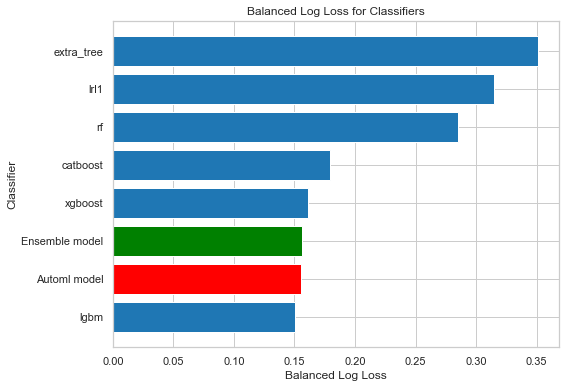

In [63]:

# Add 'Automl' to sorted scores and classifiers
sorted_scores = sorted(zip(balanced_logloss_scores + [balanced_logloss, balanced_logloss_1], list(best_estimators.keys()) + ['Ensemble model', 'Automl model']))
sorted_scores, sorted_classifiers = zip(*sorted_scores)

# Define colors for the bars
colors = ['#1f77b4'] * len(sorted_scores)  # Default color for all bars
colors[np.where(np.array(sorted_classifiers) == 'Automl model')[0][0]] = 'red'  # Color for 'Automl model' bar
colors[np.where(np.array(sorted_classifiers) == 'Ensemble model')[0][0]] = 'green'  # Color for 'Ensemble model' bar

# Plot the balanced log loss results

plt.figure(figsize=(8, 6))
plt.barh(sorted_classifiers, sorted_scores, color=colors)  # Use barh for horizontal bar plot
plt.xlabel('Balanced Log Loss')
plt.ylabel('Classifier')
plt.title('Balanced Log Loss for Classifiers')
plt.show()